# Installs & Imports

In [1]:
!pip install pyro-ppl -q

In [2]:
# Standard libraries
import copy
import os
import sys
import time
import math
import random
import requests
from zipfile import ZipFile

# Data Manipulation & Visualization
import numpy as np
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

# Scipy
import scipy.stats as stats
from scipy.stats import ttest_ind

# Statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.nonparametric.smoothers_lowess import lowess

# Scikit Learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             mean_absolute_percentage_error)
from sklearn.cluster import KMeans

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Pyro
import pyro
import pyro.distributions as dist
from pyro.distributions.zero_inflated import ZeroInflatedNegativeBinomial
from pyro.nn import PyroModule, PyroSample
from pyro.infer import (
    SVI, Trace_ELBO, TraceMeanField_ELBO, TraceGraph_ELBO,
    JitTraceGraph_ELBO, JitTraceEnum_ELBO, autoguide, Predictive
)
from pyro.optim import Adam, AdamW, ClippedAdam
import pyro.contrib.gp as gp
import pyro.poutine as poutine

# Random seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Loading the Data

In [3]:
# URL of the dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip'
zip_filename = 'Bike-Sharing-Dataset.zip'
data_dir = 'Bike-Sharing-Dataset'

In [4]:
# Check if the data directory already exists
if not os.path.exists(data_dir):
    print('Downloading the dataset...')

    # Download the zip file
    response = requests.get(url)
    with open(zip_filename, 'wb') as file:
        file.write(response.content)

    # Unzip the file
    print('Unzipping the dataset...')
    with ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall(data_dir)

    print('Dataset downloaded and unzipped.')
else:
    print('Dataset already downloaded and unzipped.')

Dataset already downloaded and unzipped.


In [5]:
# Load hourly data
df_hourly = pd.read_csv('Bike-Sharing-Dataset/hour.csv')

# Display the first few rows
df_hourly.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

In [6]:
# Get shape
df_hourly.shape

(17379, 17)

In [7]:
# Get basic information
df_hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [8]:
# Parse the date with hour information
df_hourly['datetime'] = pd.to_datetime(df_hourly['dteday'] + ' ' + df_hourly['hr'].astype(str) + ':00')

# Set the new datetime column as the index
df_hourly.set_index('datetime', inplace=True)

# Print the first few observations
df_hourly.head()

instant      dteday  season  yr  mnth  hr  holiday  \
datetime                                                                  
2011-01-01 00:00:00        1  2011-01-01       1   0     1   0        0   
2011-01-01 01:00:00        2  2011-01-01       1   0     1   1        0   
2011-01-01 02:00:00        3  2011-01-01       1   0     1   2        0   
2011-01-01 03:00:00        4  2011-01-01       1   0     1   3        0   
2011-01-01 04:00:00        5  2011-01-01       1   0     1   4        0   

                     weekday  workingday  weathersit  temp   atemp   hum  \
datetime                                                                   
2011-01-01 00:00:00        6           0           1  0.24  0.2879  0.81   
2011-01-01 01:00:00        6           0           1  0.22  0.2727  0.80   
2011-01-01 02:00:00        6           0           1  0.22  0.2727  0.80   
2011-01-01 03:00:00        6           0           1  0.24  0.2879  0.75   
2011-01-01 04:00:00        6           0           1  0.24  0.2879  0.75   

                     windspeed  casual  registered  cnt  
datetime                                                 
2011-01-01 00:00:00        0.0       3          13   16  
2011-01-01 01:00:00        0.0       8          32   40  
2011-01-01 02:00:00        0.0       5          27   32  
2011-01-01 03:00:00        0.0       3          10   13  
2011-01-01 04:00:00        0.0       0           1    1

In [9]:
# Print last few observations
df_hourly.tail()

instant      dteday  season  yr  mnth  hr  holiday  \
datetime                                                                  
2012-12-31 19:00:00    17375  2012-12-31       1   1    12  19        0   
2012-12-31 20:00:00    17376  2012-12-31       1   1    12  20        0   
2012-12-31 21:00:00    17377  2012-12-31       1   1    12  21        0   
2012-12-31 22:00:00    17378  2012-12-31       1   1    12  22        0   
2012-12-31 23:00:00    17379  2012-12-31       1   1    12  23        0   

                     weekday  workingday  weathersit  temp   atemp   hum  \
datetime                                                                   
2012-12-31 19:00:00        1           1           2  0.26  0.2576  0.60   
2012-12-31 20:00:00        1           1           2  0.26  0.2576  0.60   
2012-12-31 21:00:00        1           1           1  0.26  0.2576  0.60   
2012-12-31 22:00:00        1           1           1  0.26  0.2727  0.56   
2012-12-31 23:00:00        1           1           1  0.26  0.2727  0.65   

                     windspeed  casual  registered  cnt  
datetime                                                 
2012-12-31 19:00:00     0.1642      11         108  119  
2012-12-31 20:00:00     0.1642       8          81   89  
2012-12-31 21:00:00     0.1642       7          83   90  
2012-12-31 22:00:00     0.1343      13          48   61  
2012-12-31 23:00:00     0.1343      12          37   49

In [10]:
# Print range of the dates
df_hourly.index.min(), df_hourly.index.max()
print(f'Data spans from {df_hourly.index.min()} to {df_hourly.index.max()}')

Data spans from 2011-01-01 00:00:00 to 2012-12-31 23:00:00


In [11]:
# Rename columns
df_hourly.rename(columns={
    'yr': 'year',
    'mnth': 'month',
    'hr': 'hour',
    'holiday': 'is_holiday',
    'workingday': 'is_working_day',
    'weathersit': 'weather_situation',
    'temp': 'temperature',
    'atemp': 'feeling_temp',
    'hum': 'humidity',
    'windspeed': 'wind_speed',
    'casual': 'casual_users',
    'registered': 'registered_users',
    'cnt': 'total_rentals'
}, inplace=True)
df_hourly.head()

instant      dteday  season  year  month  hour  \
datetime                                                              
2011-01-01 00:00:00        1  2011-01-01       1     0      1     0   
2011-01-01 01:00:00        2  2011-01-01       1     0      1     1   
2011-01-01 02:00:00        3  2011-01-01       1     0      1     2   
2011-01-01 03:00:00        4  2011-01-01       1     0      1     3   
2011-01-01 04:00:00        5  2011-01-01       1     0      1     4   

                     is_holiday  weekday  is_working_day  weather_situation  \
datetime                                                                      
2011-01-01 00:00:00           0        6               0                  1   
2011-01-01 01:00:00           0        6               0                  1   
2011-01-01 02:00:00           0        6               0                  1   
2011-01-01 03:00:00           0        6               0                  1   
2011-01-01 04:00:00           0        6               0                  1   

                     temperature  feeling_temp  humidity  wind_speed  \
datetime                                                               
2011-01-01 00:00:00         0.24        0.2879      0.81         0.0   
2011-01-01 01:00:00         0.22        0.2727      0.80         0.0   
2011-01-01 02:00:00         0.22        0.2727      0.80         0.0   
2011-01-01 03:00:00         0.24        0.2879      0.75         0.0   
2011-01-01 04:00:00         0.24        0.2879      0.75         0.0   

                     casual_users  registered_users  total_rentals  
datetime                                                            
2011-01-01 00:00:00             3                13             16  
2011-01-01 01:00:00             8                32             40  
2011-01-01 02:00:00             5                27             32  
2011-01-01 03:00:00             3                10             13  
2011-01-01 04:00:00             0                 1              1

In [12]:
# Remove columns
df_hourly.drop(columns=['instant', 'dteday'], inplace=True)
df_hourly.head()

season  year  month  hour  is_holiday  weekday  \
datetime                                                              
2011-01-01 00:00:00       1     0      1     0           0        6   
2011-01-01 01:00:00       1     0      1     1           0        6   
2011-01-01 02:00:00       1     0      1     2           0        6   
2011-01-01 03:00:00       1     0      1     3           0        6   
2011-01-01 04:00:00       1     0      1     4           0        6   

                     is_working_day  weather_situation  temperature  \
datetime                                                              
2011-01-01 00:00:00               0                  1         0.24   
2011-01-01 01:00:00               0                  1         0.22   
2011-01-01 02:00:00               0                  1         0.22   
2011-01-01 03:00:00               0                  1         0.24   
2011-01-01 04:00:00               0                  1         0.24   

                     feeling_temp  humidity  wind_speed  casual_users  \
datetime                                                                
2011-01-01 00:00:00        0.2879      0.81         0.0             3   
2011-01-01 01:00:00        0.2727      0.80         0.0             8   
2011-01-01 02:00:00        0.2727      0.80         0.0             5   
2011-01-01 03:00:00        0.2879      0.75         0.0             3   
2011-01-01 04:00:00        0.2879      0.75         0.0             0   

                     registered_users  total_rentals  
datetime                                              
2011-01-01 00:00:00                13             16  
2011-01-01 01:00:00                32             40  
2011-01-01 02:00:00                27             32  
2011-01-01 03:00:00                10             13  
2011-01-01 04:00:00                 1              1

In [13]:
# View columns
df_hourly.columns

Index(['season', 'year', 'month', 'hour', 'is_holiday', 'weekday',
       'is_working_day', 'weather_situation', 'temperature', 'feeling_temp',
       'humidity', 'wind_speed', 'casual_users', 'registered_users',
       'total_rentals'],
      dtype='object')

In [14]:
# Maximum possible weather rating
max_weather_rating = df_hourly['weather_situation'].max()

# The number of hours in a day
representative_day = df_hourly.index.date[0]
hours_in_day = df_hourly[df_hourly.index.date == representative_day].index.hour.nunique()

# Maximum possible daily score
max_daily_score = max_weather_rating * hours_in_day

In [15]:
# Resampling to daily data
df_daily = df_hourly.resample('D').agg({
    'season': lambda x: x.mode()[0],
    'year': lambda x: x.mode()[0],
    'month': lambda x: x.mode()[0],
    'weekday': lambda x: x.mode()[0],
    'is_holiday': 'max',
    'is_working_day': 'max',
    'weather_situation': 'sum',
    'temperature': 'mean',
    'feeling_temp': 'mean',
    'humidity': 'mean',
    'wind_speed': 'mean',
    'casual_users': 'sum',
    'registered_users': 'sum',
    'total_rentals': 'sum'
})

# Normalizing the weather situation score
df_daily['weather_norm'] = df_daily['weather_situation'] / max_daily_score
df_daily.head()

season  year  month  weekday  is_holiday  is_working_day  \
datetime                                                               
2011-01-01       1     0      1        6           0               0   
2011-01-02       1     0      1        0           0               0   
2011-01-03       1     0      1        1           0               1   
2011-01-04       1     0      1        2           0               1   
2011-01-05       1     0      1        3           0               1   

            weather_situation  temperature  feeling_temp  humidity  \
datetime                                                             
2011-01-01                 38     0.344167      0.363625  0.805833   
2011-01-02                 45     0.363478      0.353739  0.696087   
2011-01-03                 22     0.196364      0.189405  0.437273   
2011-01-04                 24     0.200000      0.212122  0.590435   
2011-01-05                 23     0.226957      0.229270  0.436957   

            wind_speed  casual_users  registered_users  total_rentals  \
datetime                                                                
2011-01-01    0.160446           331               654            985   
2011-01-02    0.248539           131               670            801   
2011-01-03    0.248309           120              1229           1349   
2011-01-04    0.160296           108              1454           1562   
2011-01-05    0.186900            82              1518           1600   

            weather_norm  
datetime                  
2011-01-01      0.395833  
2011-01-02      0.468750  
2011-01-03      0.229167  
2011-01-04      0.250000  
2011-01-05      0.239583

In [16]:
# Number of zero values in the 'total_rentals'
zero_count = (df_hourly['total_rentals'] == 0).sum()

print(f"Number of zero values in 'total_rentals': {zero_count}")

Number of zero values in 'total_rentals': 0


# Exploring the Data

## Summary Statistics

In [17]:
# Get summary statistics
columns_to_include = ['temperature', 'feeling_temp', 'humidity', 'wind_speed',
                      'casual_users', 'registered_users', 'total_rentals']

In [18]:
# Hourly statistics
df_hourly[columns_to_include].describe().style.format("{:.3f}")

In [19]:
# Time series of interest only
df_hourly['total_rentals'].describe().round(2)

count    17379.00
mean       189.46
std        181.39
min          1.00
25%         40.00
50%        142.00
75%        281.00
max        977.00
Name: total_rentals, dtype: float64

In [20]:
# Daily statistics
df_daily[columns_to_include].describe().style.format("{:.3f}")

In [21]:
# Time series of interest only
df_daily['total_rentals'].describe().round(2)

count     731.00
mean     4504.35
std      1937.21
min        22.00
25%      3152.00
50%      4548.00
75%      5956.00
max      8714.00
Name: total_rentals, dtype: float64

## Missing Values

In [22]:
# Check for missing values
missing_values = df_hourly.isnull().sum()
print(f'Missing Values in Each Column: \n{missing_values}\n')

Missing Values in Each Column: 
season               0
year                 0
month                0
hour                 0
is_holiday           0
weekday              0
is_working_day       0
weather_situation    0
temperature          0
feeling_temp         0
humidity             0
wind_speed           0
casual_users         0
registered_users     0
total_rentals        0
dtype: int64



## Histograms

In [23]:
# Function to plot histograms for each column
def plot_histograms(dataframe):
    num_columns = len(dataframe.columns)
    fig, axes = plt.subplots(nrows=num_columns, figsize=(10, num_columns * 5))

    for i, column in enumerate(dataframe.columns):
        dataframe[column].hist(ax=axes[i])
        axes[i].set_title(column)

    plt.tight_layout()
    plt.show()

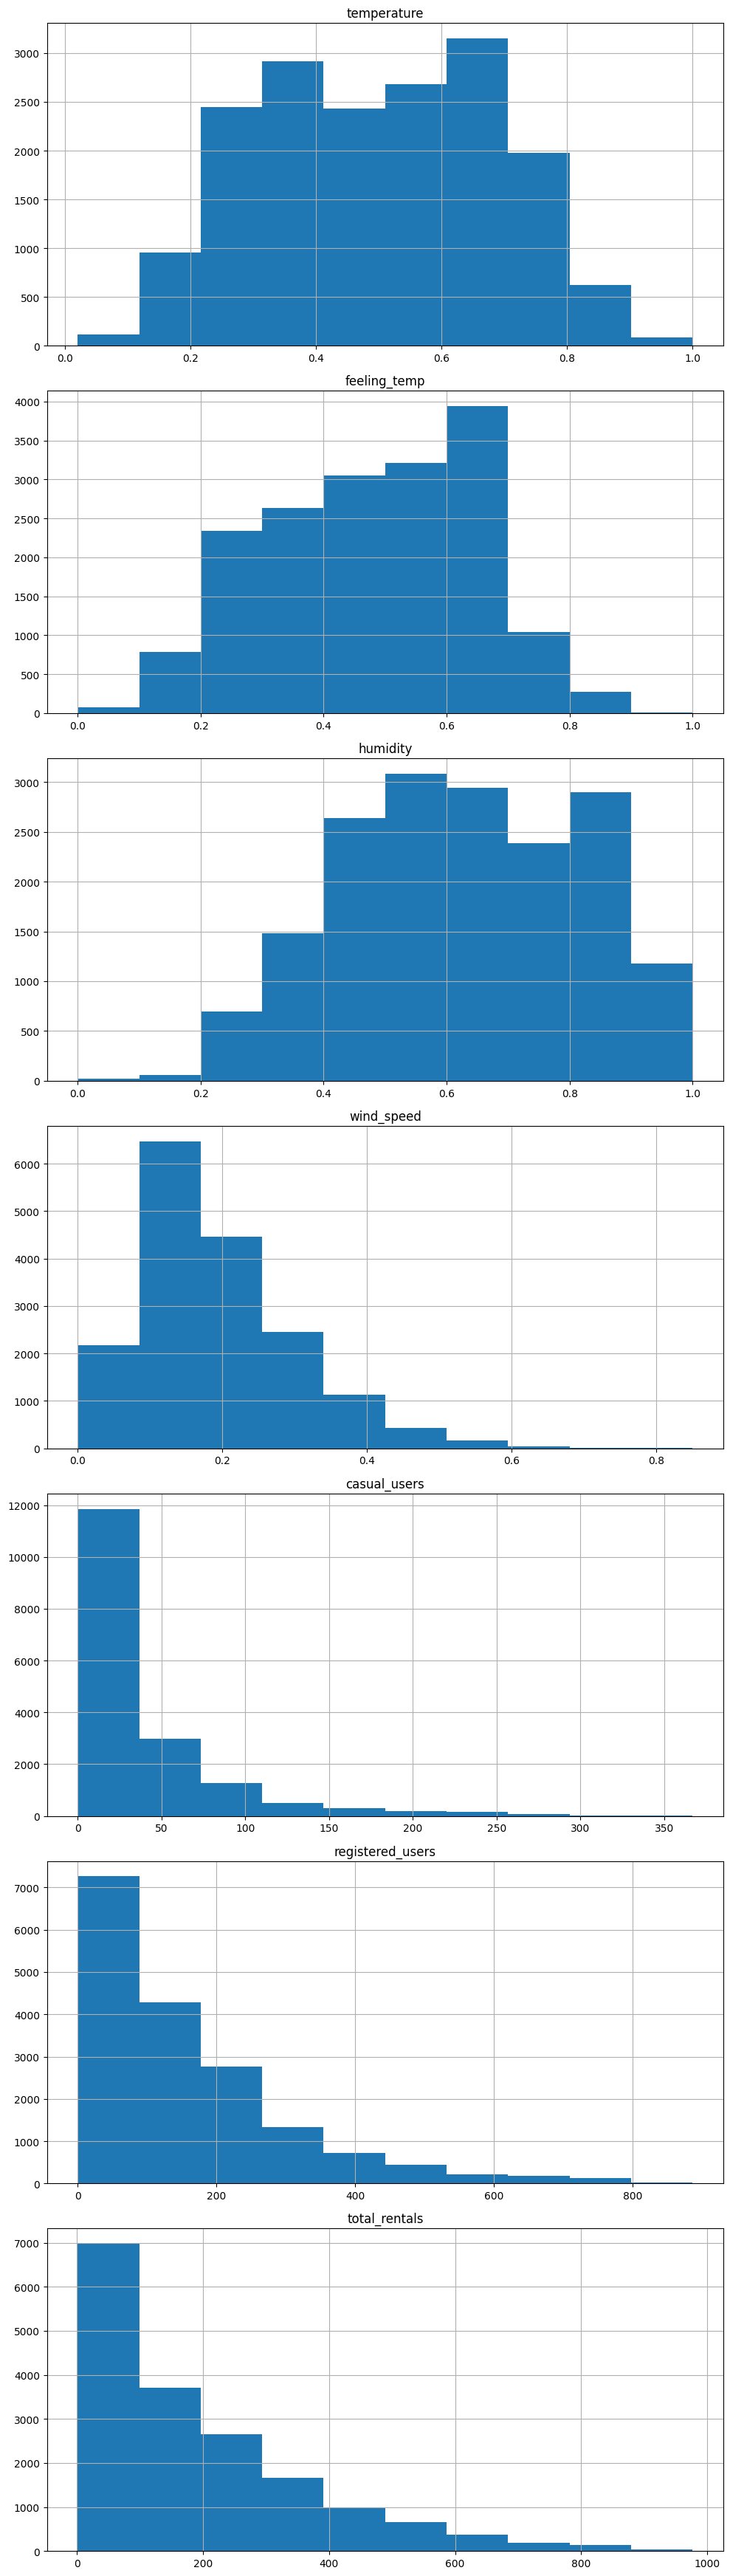

In [24]:
# Call the function
plot_histograms(df_hourly[columns_to_include])

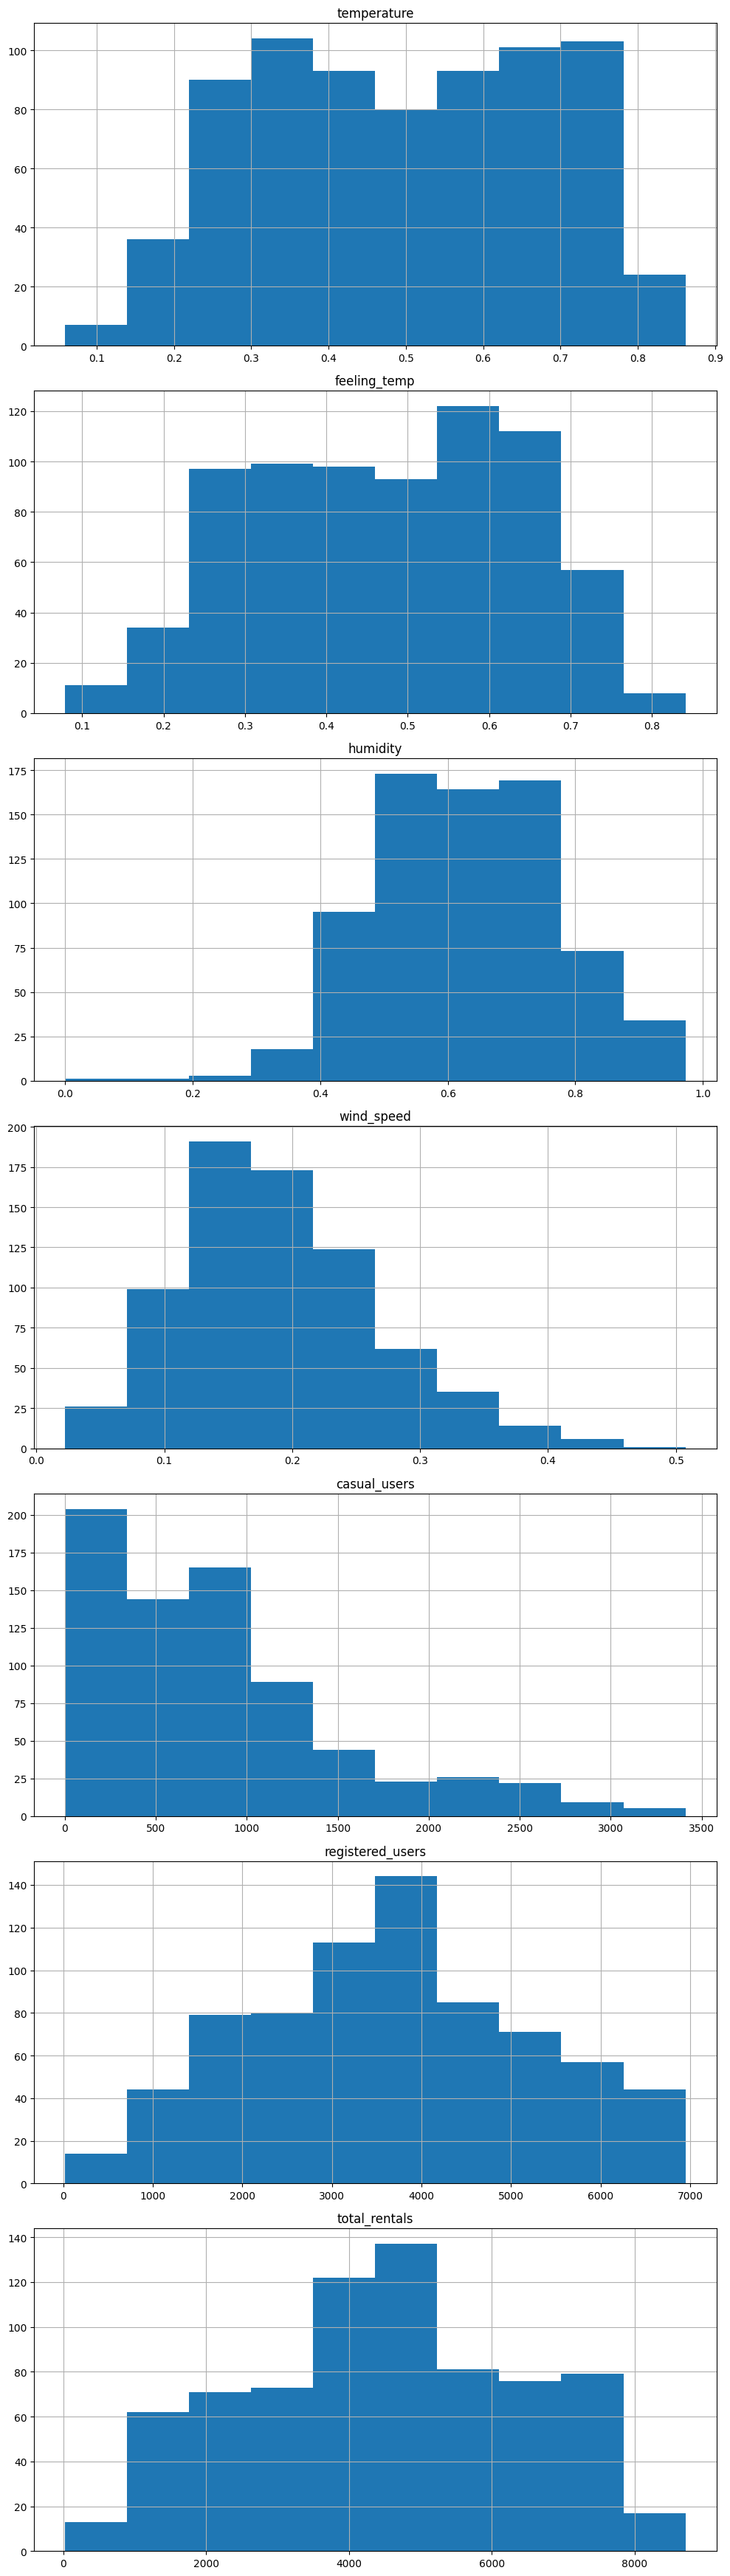

In [25]:
# Call the function
plot_histograms(df_daily[columns_to_include])

## Demand Analysis

In [26]:
# Maximum possible weekly score
max_weekly_score = max_daily_score * 7

# Resampling to weekly data
df_weekly = df_daily.resample('W').agg({
    'season': lambda x: x.mode()[0],
    'year': lambda x: x.mode()[0],
    'month': lambda x: x.mode()[0],
    'is_holiday': 'max',
    'is_working_day': 'max',
    'weather_situation': 'sum',
    'temperature': 'mean',
    'feeling_temp': 'mean',
    'humidity': 'mean',
    'wind_speed': 'mean',
    'casual_users': 'sum',
    'registered_users': 'sum',
    'total_rentals': 'sum'
})

# Normalizing the weekly weather situation score
df_weekly['weather_norm'] = df_weekly['weather_situation'] / max_weekly_score
df_weekly.head()

season  year  month  is_holiday  is_working_day  \
datetime                                                      
2011-01-02       1     0      1           0               0   
2011-01-09       1     0      1           0               1   
2011-01-16       1     0      1           0               1   
2011-01-23       1     0      1           1               1   
2011-01-30       1     0      1           0               1   

            weather_situation  temperature  feeling_temp  humidity  \
datetime                                                             
2011-01-02                 83     0.353822      0.358682  0.750960   
2011-01-09                204     0.189646      0.193039  0.493089   
2011-01-16                220     0.183360      0.189207  0.537081   
2011-01-23                238     0.182785      0.185474  0.567549   
2011-01-30                226     0.192842      0.208789  0.689379   

            wind_speed  casual_users  registered_users  total_rentals  \
datetime                                                                
2011-01-02    0.204492           462              1324           1786   
2011-01-09    0.211793           668              8740           9408   
2011-01-16    0.203424           674              8351           9025   
2011-01-23    0.216689           605              8165           8770   
2011-01-30    0.148352           622              7077           7699   

            weather_norm  
datetime                  
2011-01-02      0.123512  
2011-01-09      0.303571  
2011-01-16      0.327381  
2011-01-23      0.354167  
2011-01-30      0.336310

In [27]:
# Resampling to monthly data
df_monthly = df_weekly.resample('M').agg({
    'season': lambda x: x.mode()[0],
    'year': lambda x: x.mode()[0],
    'is_holiday': 'max',
    'is_working_day': 'max',
    'weather_situation': 'sum',
    'temperature': 'mean',
    'feeling_temp': 'mean',
    'humidity': 'mean',
    'wind_speed': 'mean',
    'casual_users': 'sum',
    'registered_users': 'sum',
    'total_rentals': 'sum'
})
# Calculate the number of hours in each month
df_monthly['hours_in_month'] = df_monthly.index.days_in_month * 24

# Normalize the weather situation score
df_monthly['weather_norm'] = df_monthly['weather_situation'] / (df_monthly['hours_in_month'] * max_weather_rating)

# Modify the index format and display
df_monthly.index = df_monthly.index.to_period('M').to_timestamp()
df_monthly.head()

season  year  is_holiday  is_working_day  weather_situation  \
datetime                                                                  
2011-01-01       1     0           1               1                971   
2011-02-01       1     0           1               1                933   
2011-03-01       1     0           0               1               1017   
2011-04-01       2     0           1               1               1103   
2011-05-01       2     0           0               1               1199   

            temperature  feeling_temp  humidity  wind_speed  casual_users  \
datetime                                                                    
2011-01-01     0.220491      0.227038  0.607612    0.196950          3031   
2011-02-01     0.274453      0.276774  0.550357    0.224908          6203   
2011-03-01     0.341206      0.334964  0.583816    0.238021         12021   
2011-04-01     0.421875      0.411590  0.650981    0.233434         17822   
2011-05-01     0.566976      0.541797  0.708429    0.199915         34238   

            registered_users  total_rentals  hours_in_month  weather_norm  
datetime                                                                   
2011-01-01             33657          36688             744      0.326277  
2011-02-01             42067          48270             672      0.347098  
2011-03-01             45796          57817             744      0.341734  
2011-04-01             58412          76234             720      0.382986  
2011-05-01            119813         154051             744      0.402890

In [28]:
# Function to plot demand trends over different time periods
def plot_trends(dataframe, frequency, color):
    title_mapping = {
        'hourly': 'Hourly',
        'daily': 'Daily',
        'weekly': 'Weekly',
        'monthly': 'Monthly'
    }
    title = f"{title_mapping.get(frequency, 'Time')} Total Bike Rentals"

    # Plot
    plt.figure(figsize=(15, 5))
    dataframe['total_rentals'].plot(title=title, color=color)
    plt.ylabel('Total Bike Rentals')
    plt.xlabel('Date')
    plt.show()

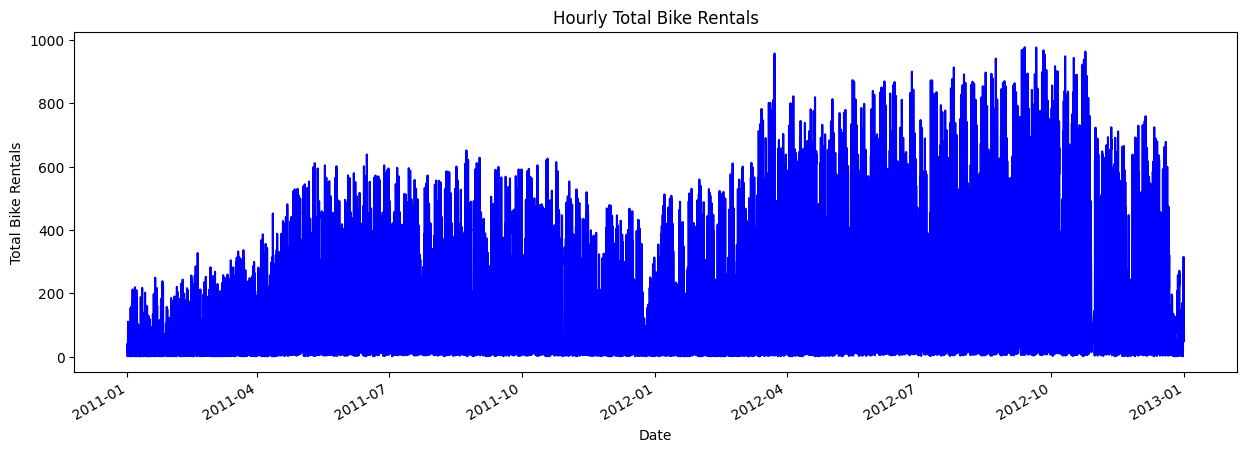

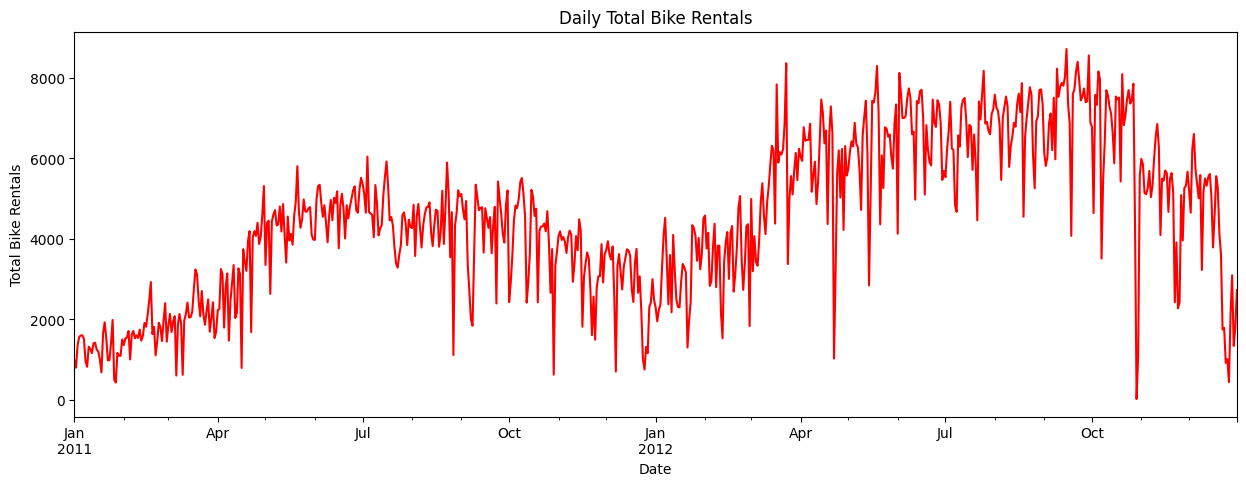

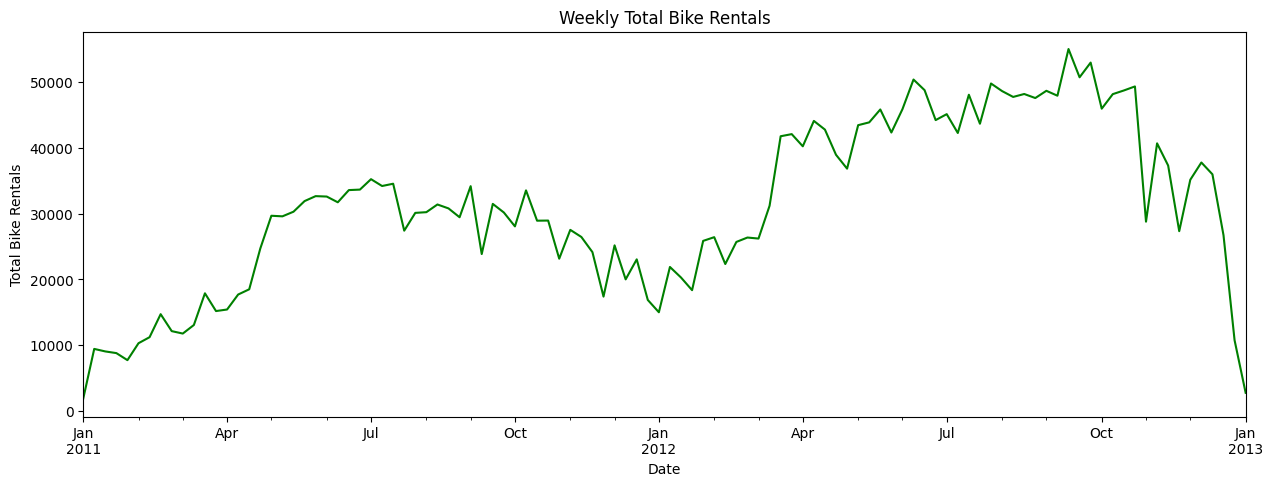

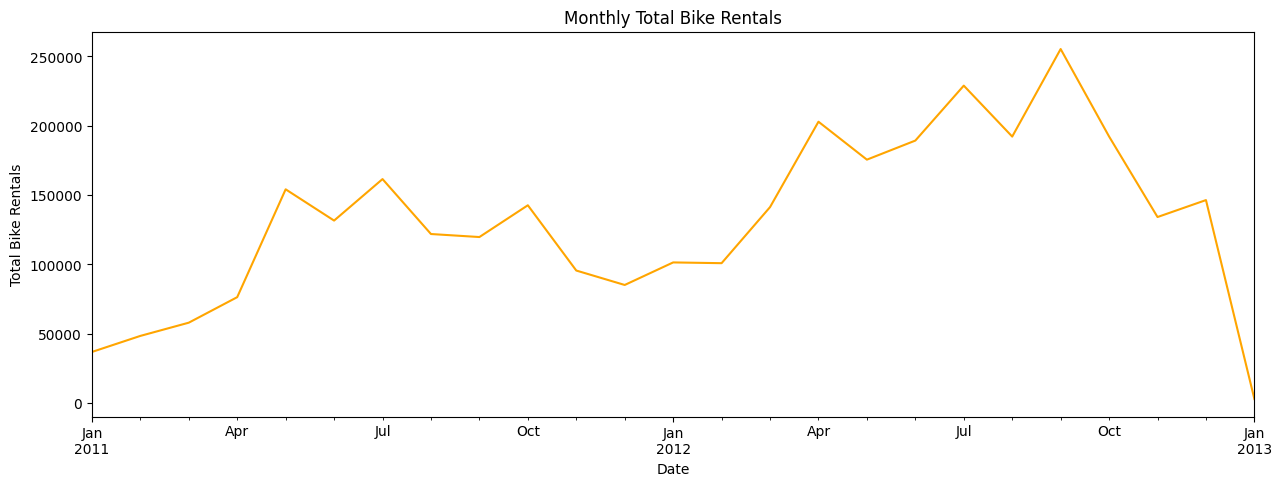

In [29]:
# Call the function for different datasets
plot_trends(df_hourly, 'hourly', 'blue')
plot_trends(df_daily, 'daily', 'red')
plot_trends(df_weekly, 'weekly', 'green')
plot_trends(df_monthly, 'monthly', 'orange')

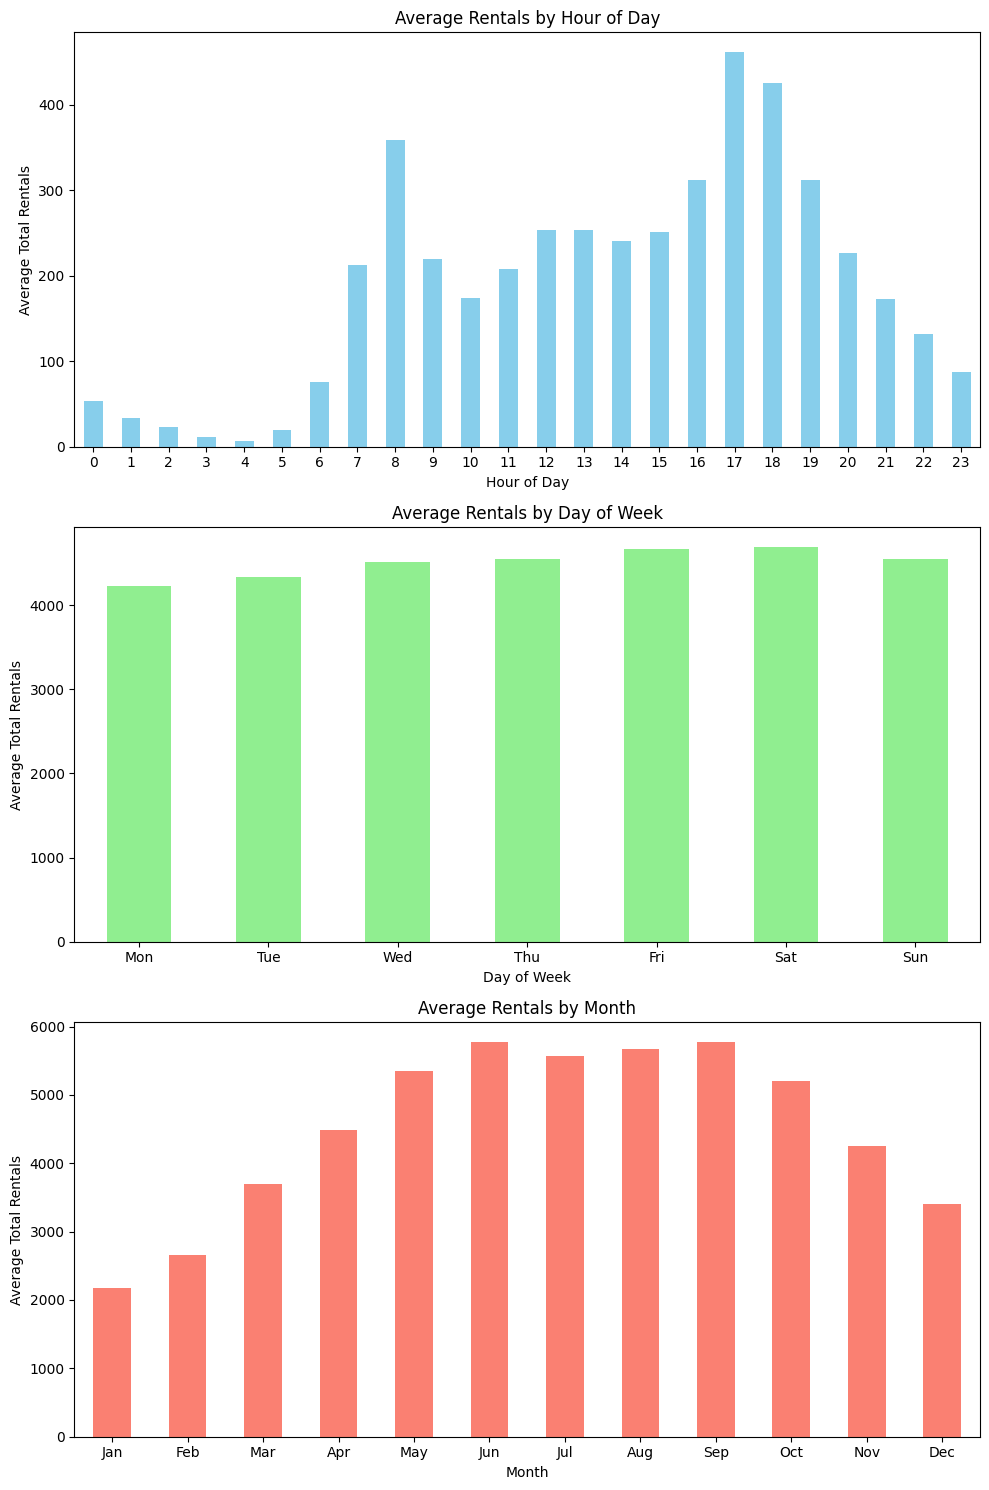

In [30]:
# Hourly patterns
hourly_data = df_hourly.groupby('hour')['total_rentals'].mean()

# Day of the week patterns
week_data = df_daily.groupby('weekday')['total_rentals'].mean()

# Monthly patterns
monthly_data = df_daily.groupby(df_daily.index.month)['total_rentals'].mean()

# Plotting
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# Hourly plot
hourly_data.plot(kind='bar', ax=ax[0], color='skyblue')
ax[0].set_title('Average Rentals by Hour of Day')
ax[0].set_xlabel('Hour of Day')
ax[0].set_ylabel('Average Total Rentals')
ax[0].set_xticks(range(24))
ax[0].set_xticklabels(range(24), rotation=0)

# Day of the week plot
week_data.plot(kind='bar', ax=ax[1], color='lightgreen')
ax[1].set_title('Average Rentals by Day of Week')
ax[1].set_xlabel('Day of Week')
ax[1].set_ylabel('Average Total Rentals')
ax[1].set_xticks(range(7))
ax[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)

# Monthly plot
monthly_data.plot(kind='bar', ax=ax[2], color='salmon')
ax[2].set_title('Average Rentals by Month')
ax[2].set_xlabel('Month')
ax[2].set_ylabel('Average Total Rentals')
ax[2].set_xticks(range(12))
ax[2].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)

plt.tight_layout()
plt.show()

## Pair Plots

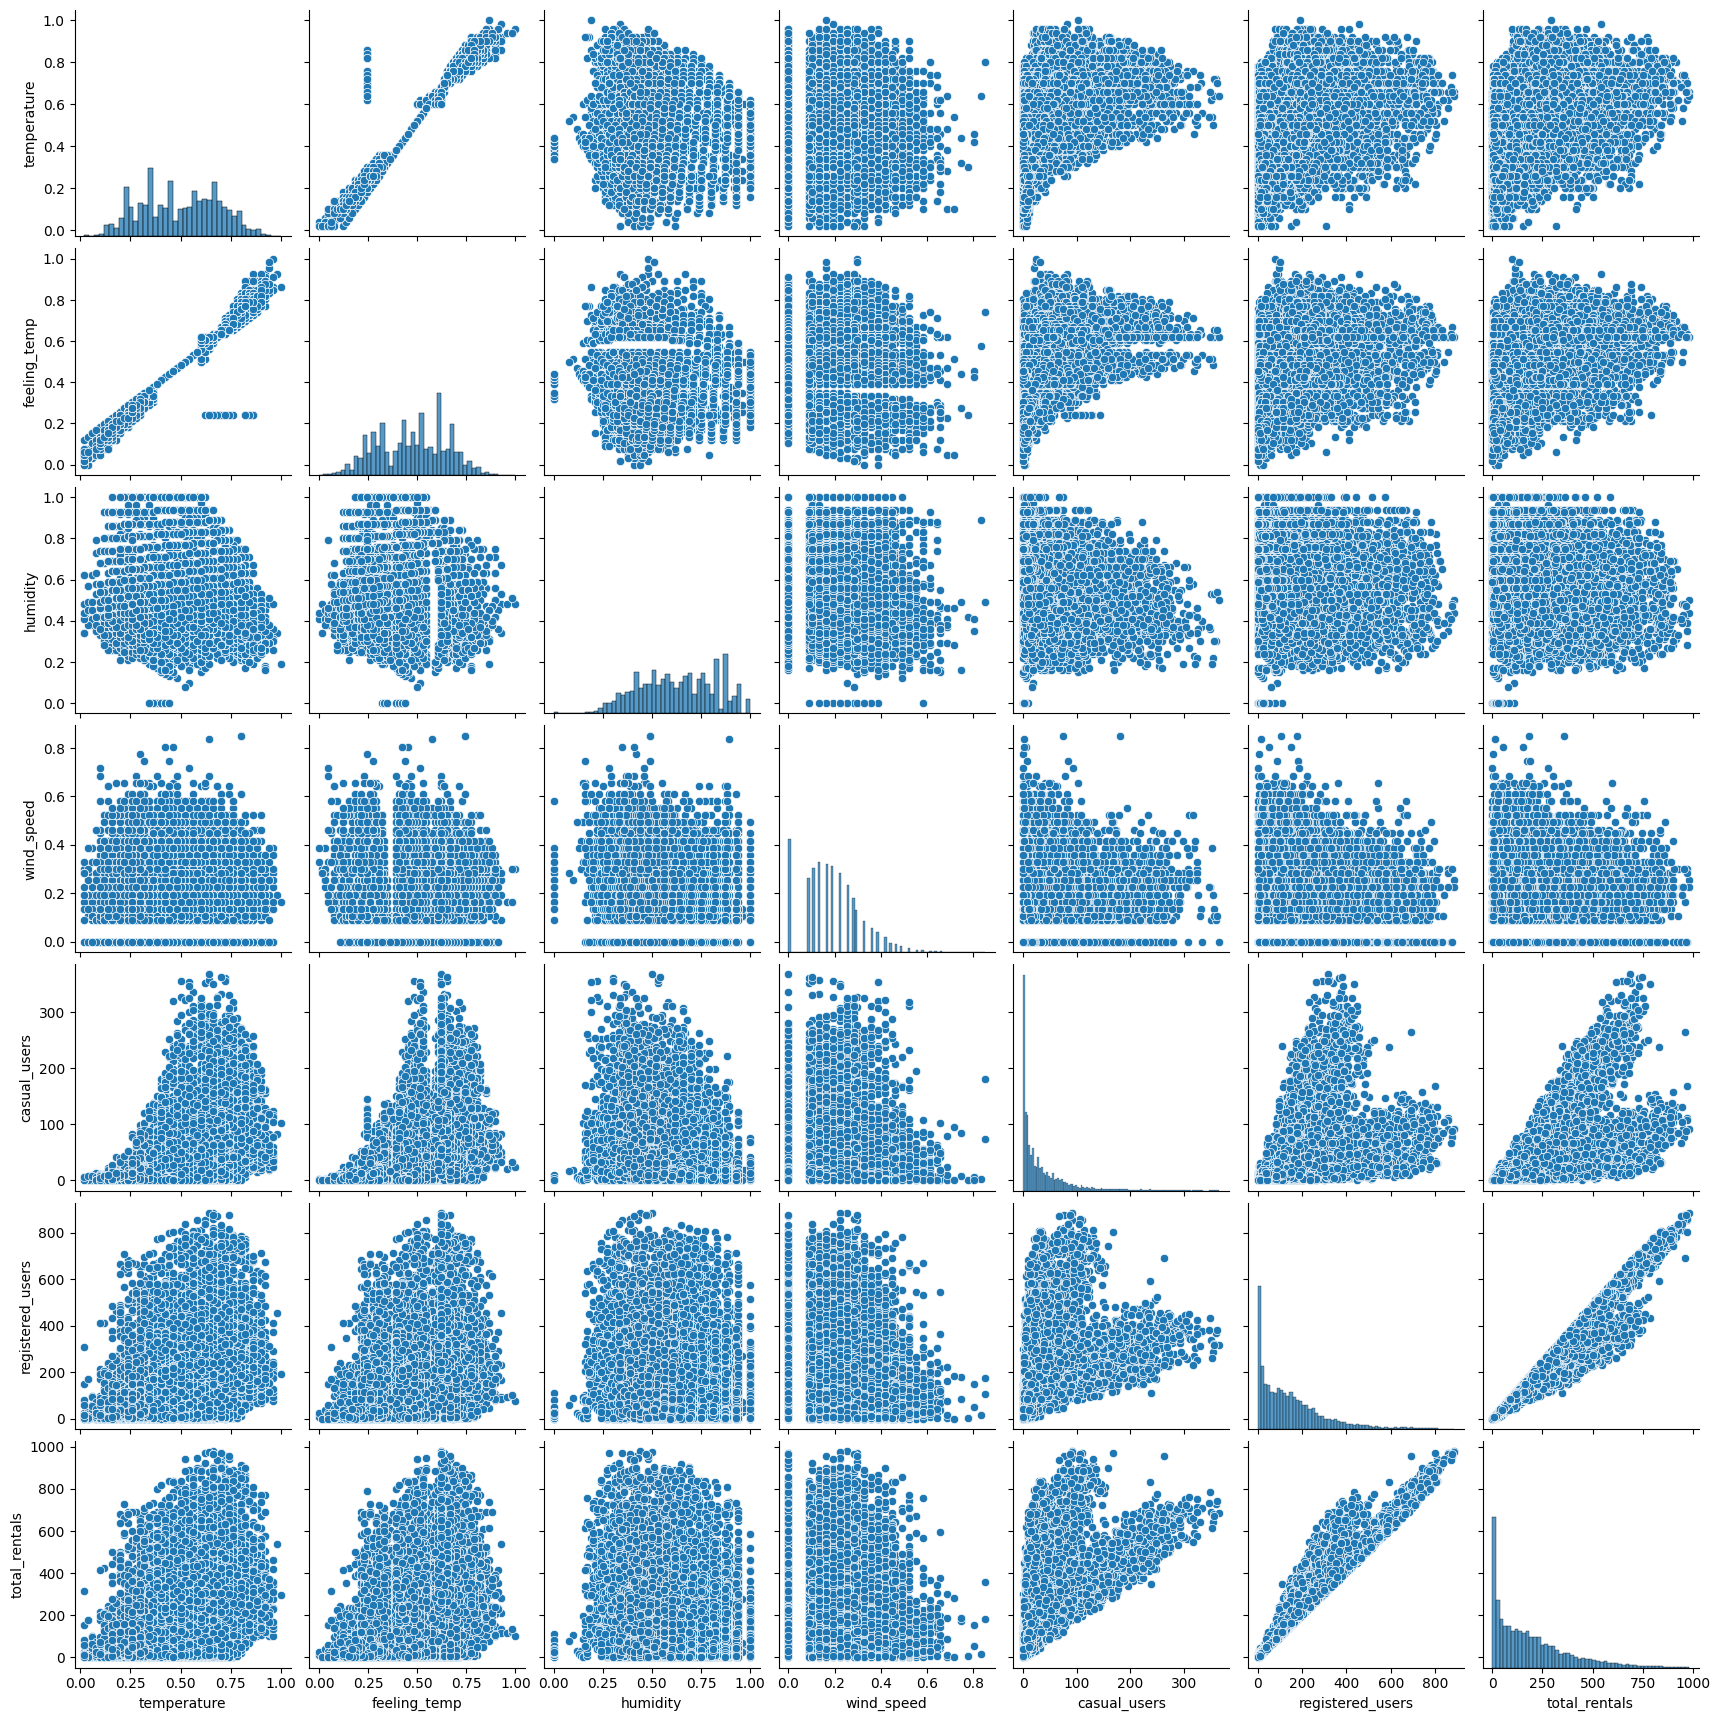

In [31]:
# Pair plots
sns.pairplot(df_hourly[columns_to_include])
plt.show()

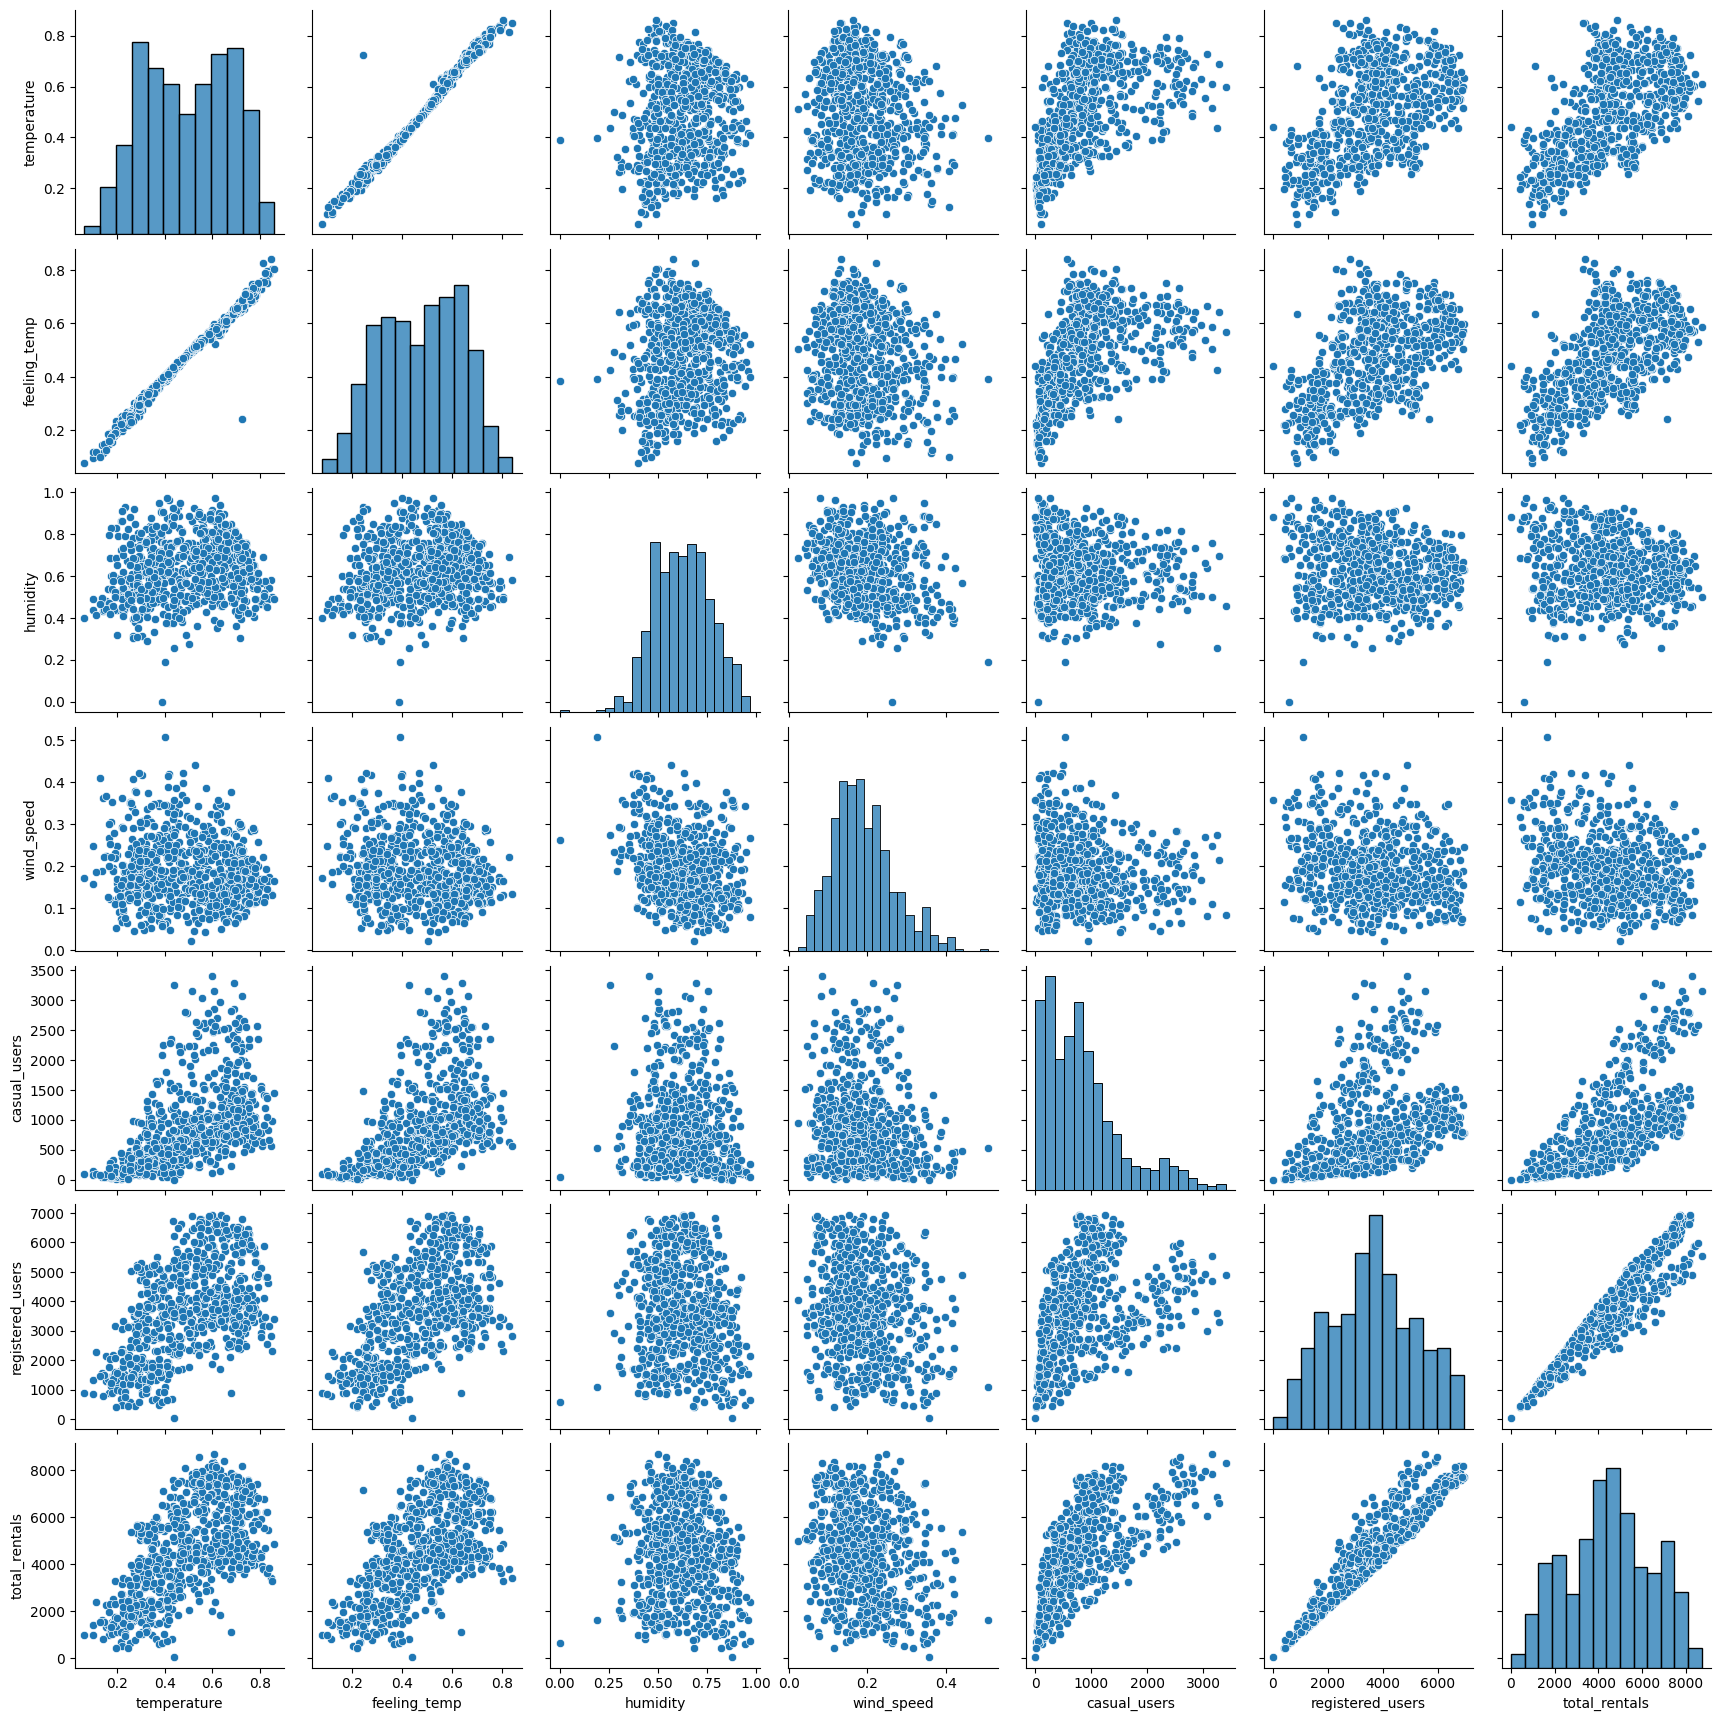

In [32]:
# Pair plots
sns.pairplot(df_daily[columns_to_include])
plt.show()

## Correlation Matrix

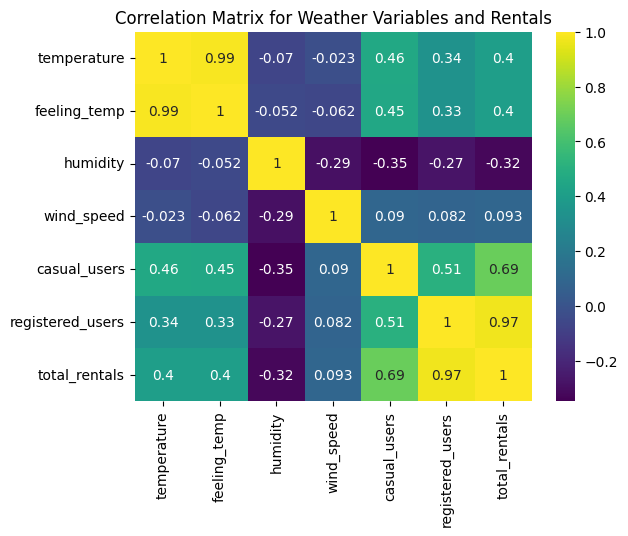

In [33]:
# Correlation matrix for weather variables and rentals
correlation_matrix = df_hourly[columns_to_include].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='viridis')
plt.title('Correlation Matrix for Weather Variables and Rentals')
plt.show()

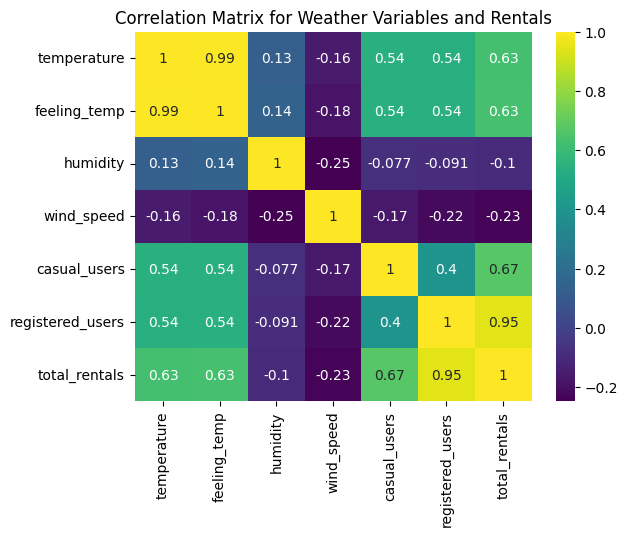

In [34]:
# Correlation matrix for weather variables and rentals
correlation_matrix = df_daily[columns_to_include].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='viridis')
plt.title('Correlation Matrix for Weather Variables and Rentals')
plt.show()

## Seasonality Influence

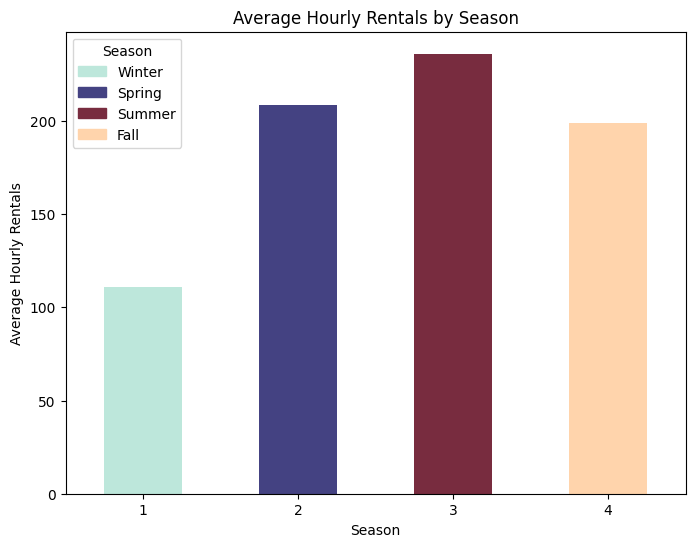

In [35]:
# Colormap and color assignment
season_cmap = plt.get_cmap('icefire')
season_colors = season_cmap(np.linspace(0, 1, df_daily['season'].nunique()))

# Creating the plot
plt.figure(figsize=(8, 6))
ax = df_hourly.groupby('season')['total_rentals'].mean().plot(kind='bar', color=season_colors)
plt.title('Average Hourly Rentals by Season')
plt.xlabel('Season')
plt.ylabel('Average Hourly Rentals')
plt.xticks(rotation=0)

# Adding a legend
season_labels = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
handles = [plt.Rectangle((0,0),1,1, color=season_cmap(i/3)) for i in range(4)]
ax.legend(handles, [season_labels[i+1] for i in range(4)], title="Season")

plt.show()

## Weather Influence

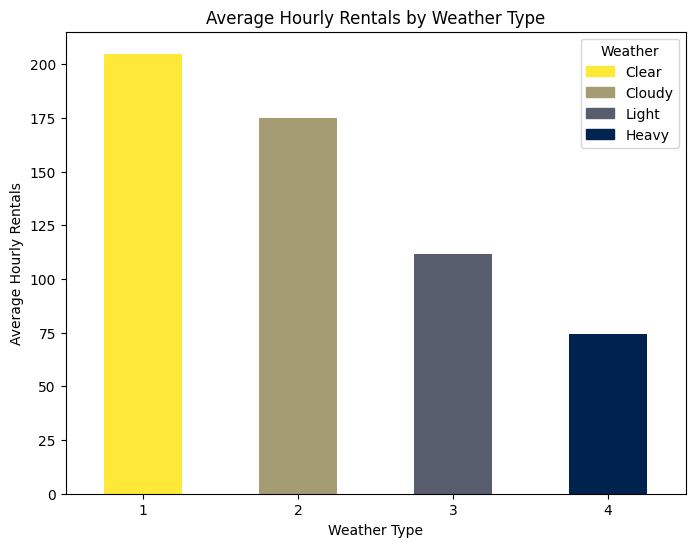

In [36]:
# Colormap and color assignment
weather_cmap = plt.get_cmap('cividis_r')
weather_colors = weather_cmap(np.linspace(0, 1, df_hourly['weather_situation'].nunique()))

# Creating the plot
plt.figure(figsize=(8, 6))
ax = df_hourly.groupby('weather_situation')['total_rentals'].mean().plot(kind='bar', color=weather_colors)
plt.title('Average Hourly Rentals by Weather Type')
plt.xlabel('Weather Type')
plt.ylabel('Average Hourly Rentals')
plt.xticks(rotation=0)

# Adding a legend
weather_labels = {1: 'Clear', 2: 'Cloudy', 3: 'Light', 4: 'Heavy'}
handles = [plt.Rectangle((0,0),1,1, color=weather_cmap(i/3)) for i in range(4)]
ax.legend(handles, [weather_labels[i+1] for i in range(4)], title="Weather")

plt.show()

## Holiday Influence

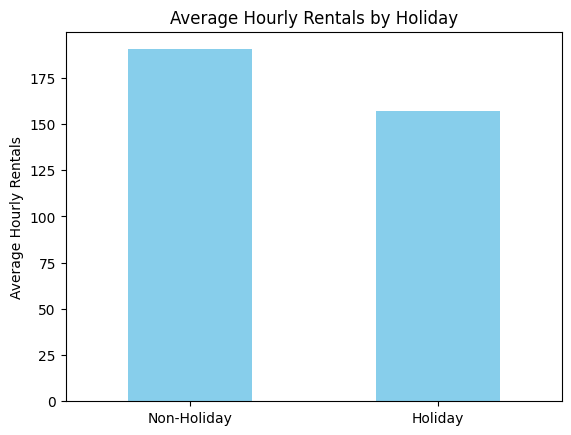

In [37]:
# Convert 'is_holiday' to category
df_hourly['is_holiday'] = df_hourly['is_holiday'].astype('category')

# Group by 'is_holiday' and calculate mean total rentals
holiday_rentals = df_hourly.groupby('is_holiday')['total_rentals'].mean()

# Plotting
holiday_rentals.plot(kind='bar', color='skyblue')
plt.title('Average Hourly Rentals by Holiday')
plt.xlabel(None)
plt.ylabel('Average Hourly Rentals')
plt.xticks(ticks=[0, 1], labels=['Non-Holiday', 'Holiday'],
           rotation=0)
plt.show()

In [38]:
# Shapiro-Wilk Test
w, pvalue = stats.shapiro(df_hourly['total_rentals'])
print(f'Shapiro-Wilk Test P-Value: {pvalue}')
if pvalue < 0.05:
    print('The data is not normally distributed.')
else:
    print('The data is normally distributed.')

Shapiro-Wilk Test P-Value: 0.0
The data is not normally distributed.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [39]:
from scipy.stats import mannwhitneyu

# Separate the data into two groups
rentals_non_holiday = df_hourly[df_hourly['is_holiday'] == 0]['total_rentals']
rentals_holiday = df_hourly[df_hourly['is_holiday'] == 1]['total_rentals']

# Perform the Mann-Whitney U test
u_statistic, p_value = mannwhitneyu(rentals_non_holiday, rentals_holiday)

# Print the results
print(f'U-statistic: {u_statistic}')
print(f'p-value: {p_value:.6f}')

# Conditional print statements
if p_value < 0.05:
    print('Reject the null hypothesis. There is a statistically significant difference.')
else:
    print('Fail to reject the null hypothesis. No statistically significant difference.')

U-statistic: 4650072.5
p-value: 0.000099
Reject the null hypothesis. There is a statistically significant difference.


## Working Day Influence

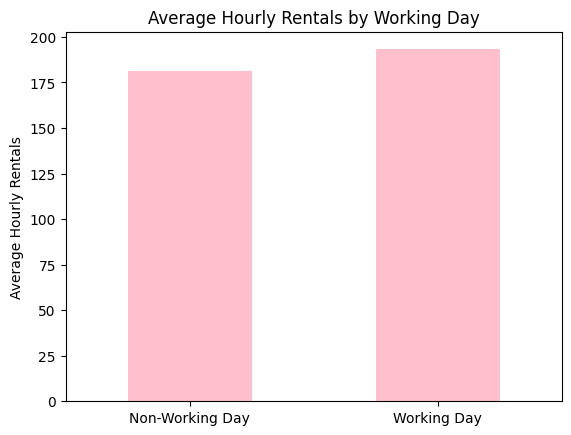

In [40]:
# Convert 'is_working_day' to category
df_hourly['is_working_day'] = df_hourly['is_working_day'].astype('category')

# Group by 'is_working_day' and calculate mean total rentals
working_day_rentals = df_hourly.groupby('is_working_day')['total_rentals'].mean()

# Plotting
working_day_rentals.plot(kind='bar', color='pink')
plt.title('Average Hourly Rentals by Working Day')
plt.xlabel(None)
plt.ylabel('Average Hourly Rentals')
plt.xticks(ticks=[0, 1], labels=['Non-Working Day', 'Working Day'],
           rotation=0)
plt.show()

In [41]:
# Separate the data into two groups
rentals_non_working = df_hourly[df_hourly['is_working_day'] == 0]['total_rentals']
rentals_working = df_hourly[df_hourly['is_working_day'] == 1]['total_rentals']

# Perform the Mann-Whitney U test
u_statistic, p_value = mannwhitneyu(rentals_non_working, rentals_working)

# Print the results
print(f'U-statistic: {u_statistic}')
print(f'p-value: {p_value:.6f}')

# Conditional print statements
if p_value < 0.05:
    print('Reject the null hypothesis. There is a statistically significant difference.')
else:
    print('Fail to reject the null hypothesis. No statistically significant difference.')

U-statistic: 31858297.0
p-value: 0.005558
Reject the null hypothesis. There is a statistically significant difference.


## User Type Analysis

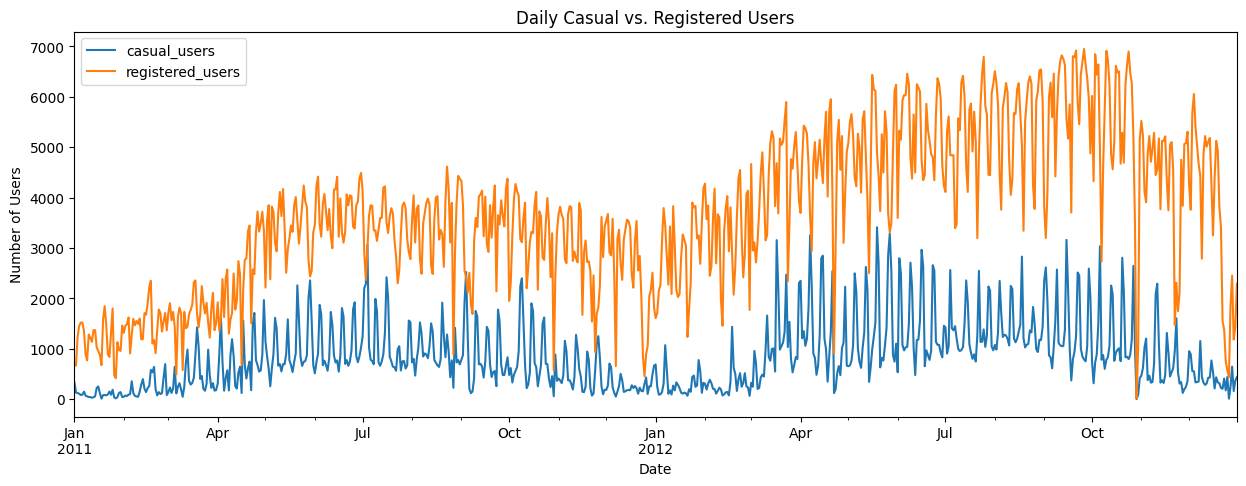

In [42]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 5))

# Plotting
df_daily[['casual_users', 'registered_users']].plot(ax=ax)
ax.set_title('Daily Casual vs. Registered Users')
ax.set_ylabel('Number of Users')
ax.set_xlabel('Date')
plt.show()

## Stationarity

In [43]:
# Augmented Dickey-Fuller test for stationarity
result = adfuller(df_hourly['total_rentals'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Conditional print statements
if result[1] < 0.05:
    print('Reject the null hypothesis. The hourly time series is stationary.')
else:
    print('Fail to reject the null hypothesis. The hourly time series is not stationary.')

ADF Statistic: -6.822919
p-value: 0.000000
Reject the null hypothesis. The hourly time series is stationary.


In [44]:
# Augmented Dickey-Fuller test for stationarity
result = adfuller(df_daily['total_rentals'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Conditional print statements
if result[1] < 0.05:
    print('Reject the null hypothesis. The daily time series is stationary.')
else:
    print('Fail to reject the null hypothesis. The daily time series is not stationary.')

ADF Statistic: -1.877448
p-value: 0.342743
Fail to reject the null hypothesis. The daily time series is not stationary.


## Seasonal Decomposition

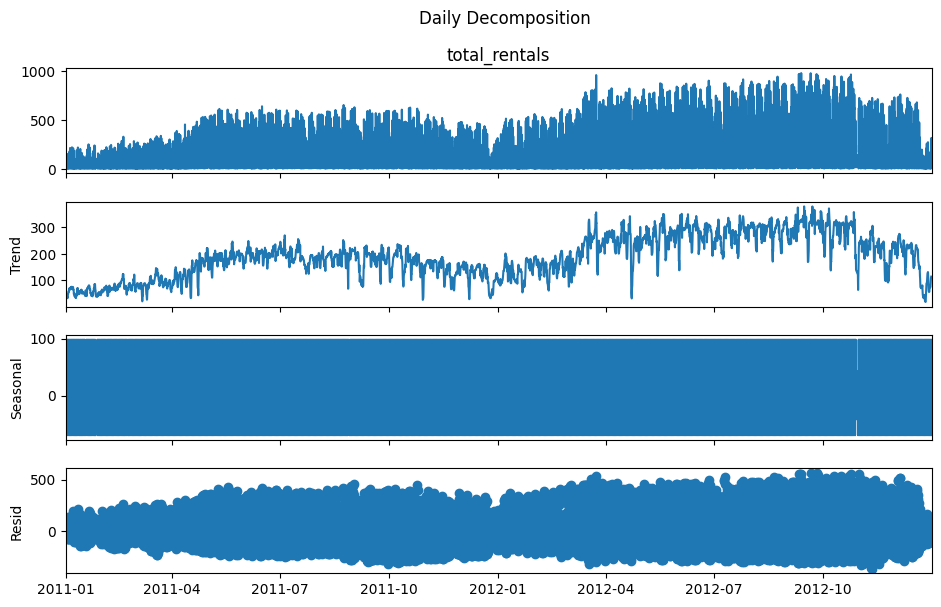

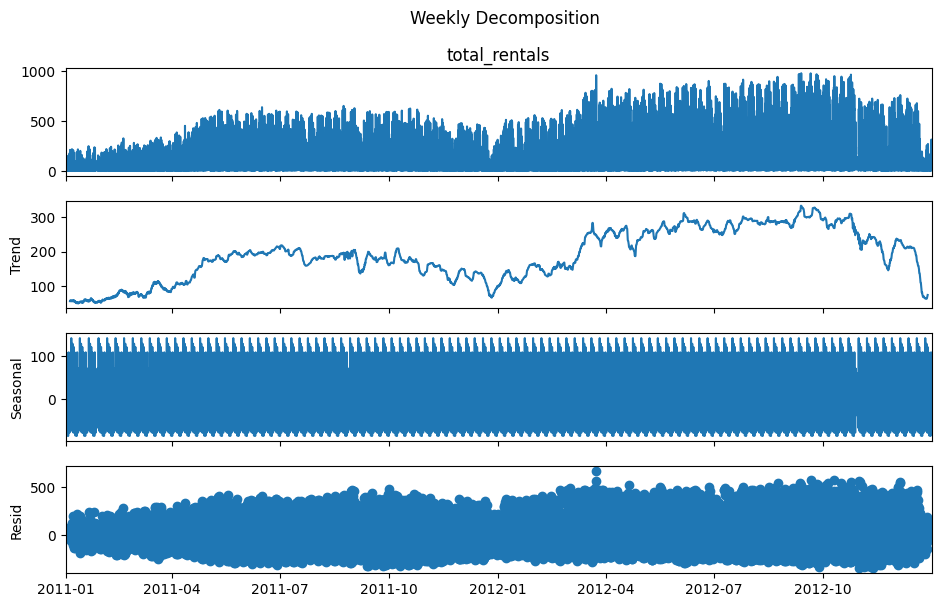

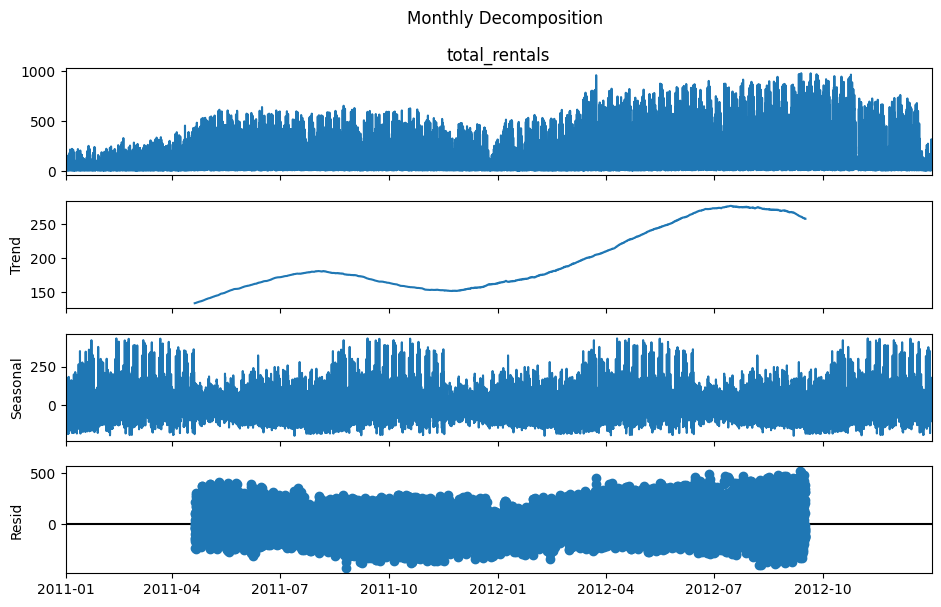

In [45]:
# Decomposition for daily, weekly, and monthly frequencies
decomposition_daily = sm.tsa.seasonal_decompose(df_hourly['total_rentals'], model='add', period=24)  # Daily
decomposition_weekly = sm.tsa.seasonal_decompose(df_hourly['total_rentals'], model='add', period=24*7)  # Weekly
decomposition_monthly = sm.tsa.seasonal_decompose(df_hourly['total_rentals'], model='add', period=24*7*30)  # Monthly (approximation)

# Daily Decomposition Plot
fig_daily = decomposition_daily.plot()
fig_daily.set_size_inches(10, 6)
plt.suptitle('Daily Decomposition', x=0.55, y=1.02)
plt.show()

# Weekly Decomposition Plot
fig_weekly = decomposition_weekly.plot()
fig_weekly.set_size_inches(10, 6)
plt.suptitle('Weekly Decomposition', x=0.55, y=1.02)
plt.show()

# Monthly Decomposition Plot
fig_monthly = decomposition_monthly.plot()
fig_monthly.set_size_inches(10, 6)
plt.suptitle('Monthly Decomposition', x=0.55, y=1.02)
plt.show()

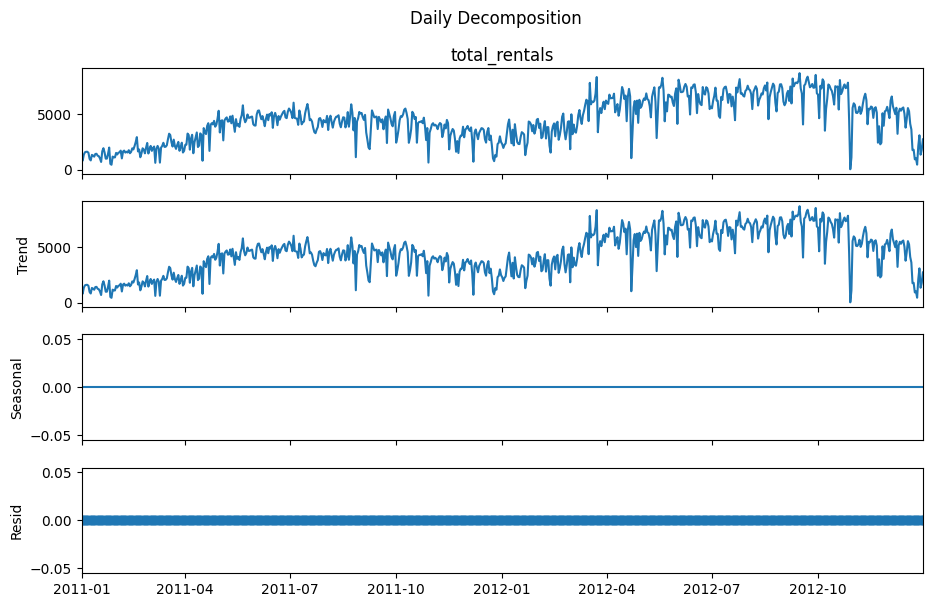

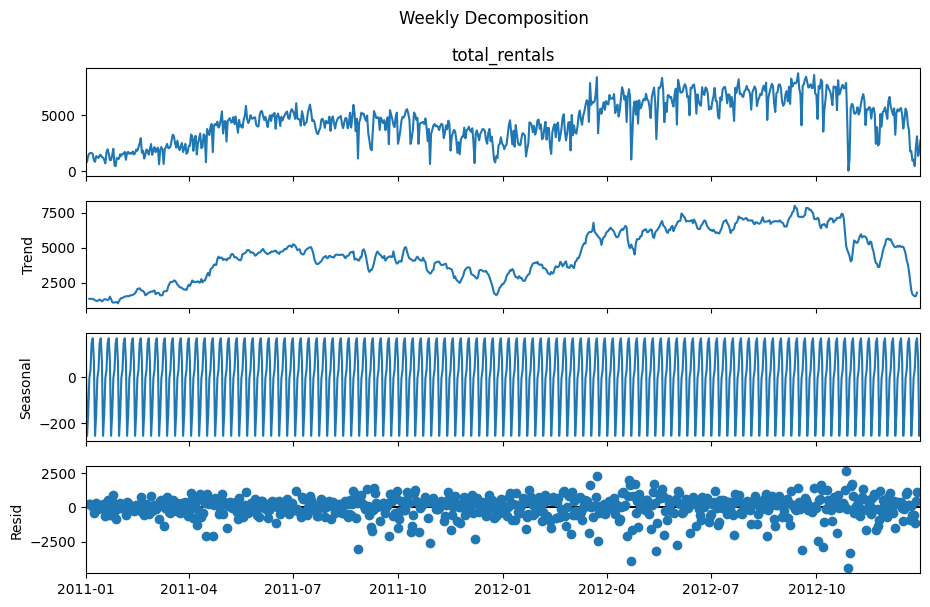

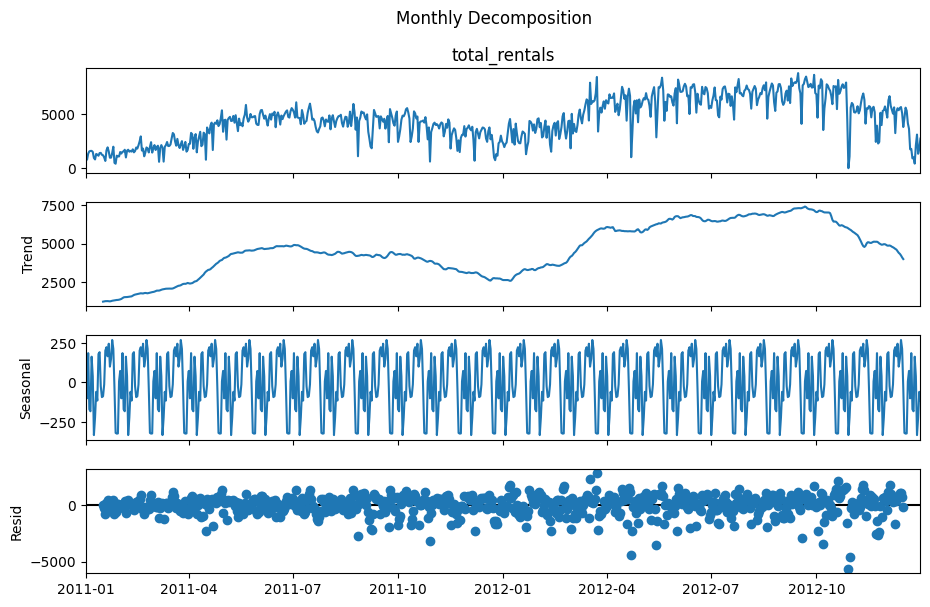

In [46]:
# Decomposition for daily, weekly, and monthly frequencies
decomposition_daily = sm.tsa.seasonal_decompose(df_daily['total_rentals'], model='add', period=1)  # Daily
decomposition_weekly = sm.tsa.seasonal_decompose(df_daily['total_rentals'], model='add', period=7)  # Weekly
decomposition_monthly = sm.tsa.seasonal_decompose(df_daily['total_rentals'], model='add', period=30)  # Monthly (approximation)

# Daily Decomposition Plot
fig_daily = decomposition_daily.plot()
fig_daily.set_size_inches(10, 6)
plt.suptitle('Daily Decomposition', x=0.55, y=1.02)
plt.show()

# Weekly Decomposition Plot
fig_weekly = decomposition_weekly.plot()
fig_weekly.set_size_inches(10, 6)
plt.suptitle('Weekly Decomposition', x=0.55, y=1.02)
plt.show()

# Monthly Decomposition Plot
fig_monthly = decomposition_monthly.plot()
fig_monthly.set_size_inches(10, 6)
plt.suptitle('Monthly Decomposition', x=0.55, y=1.02)
plt.show()

## Autocorrelation

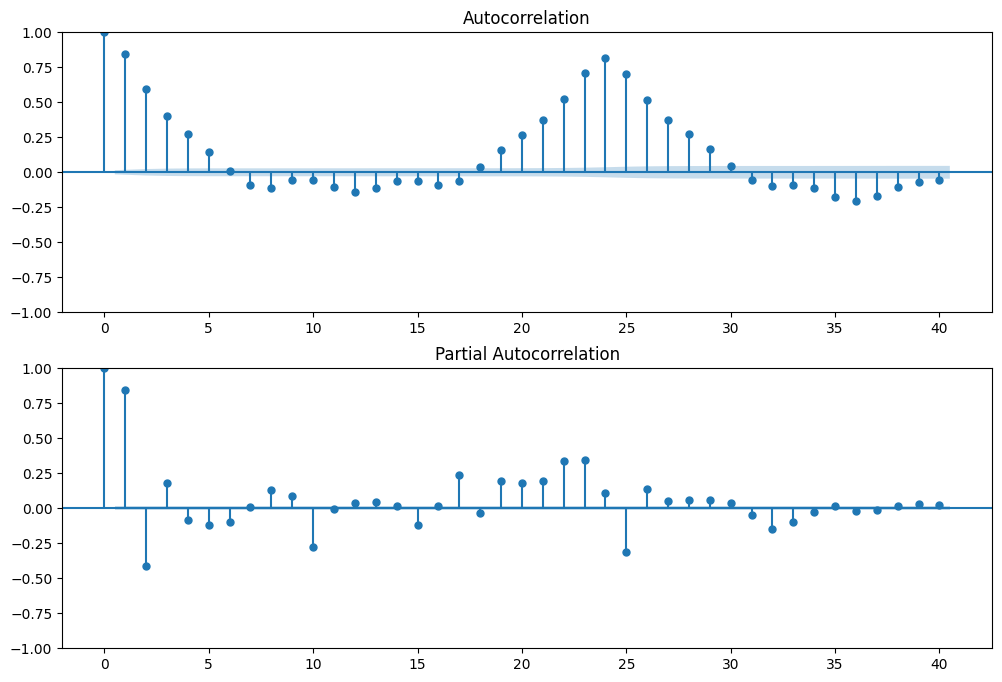

In [47]:
# Autocorrelation and partial autocorrelation plots
fig, ax = plt.subplots(2, figsize=(12,8))
sm.graphics.tsa.plot_acf(df_hourly['total_rentals'], lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(df_hourly['total_rentals'], lags=40, ax=ax[1])
plt.show()

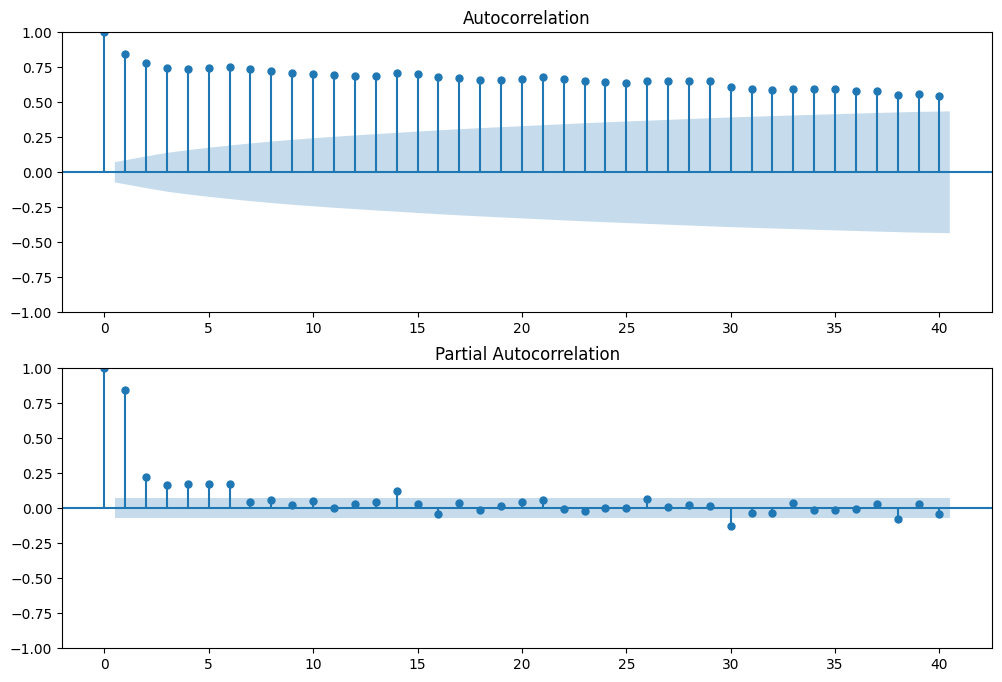

In [48]:
# Autocorrelation and partial autocorrelation plots
fig, ax = plt.subplots(2, figsize=(12,8))
sm.graphics.tsa.plot_acf(df_daily['total_rentals'], lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(df_daily['total_rentals'], lags=40, ax=ax[1])
plt.show()

## Differencing

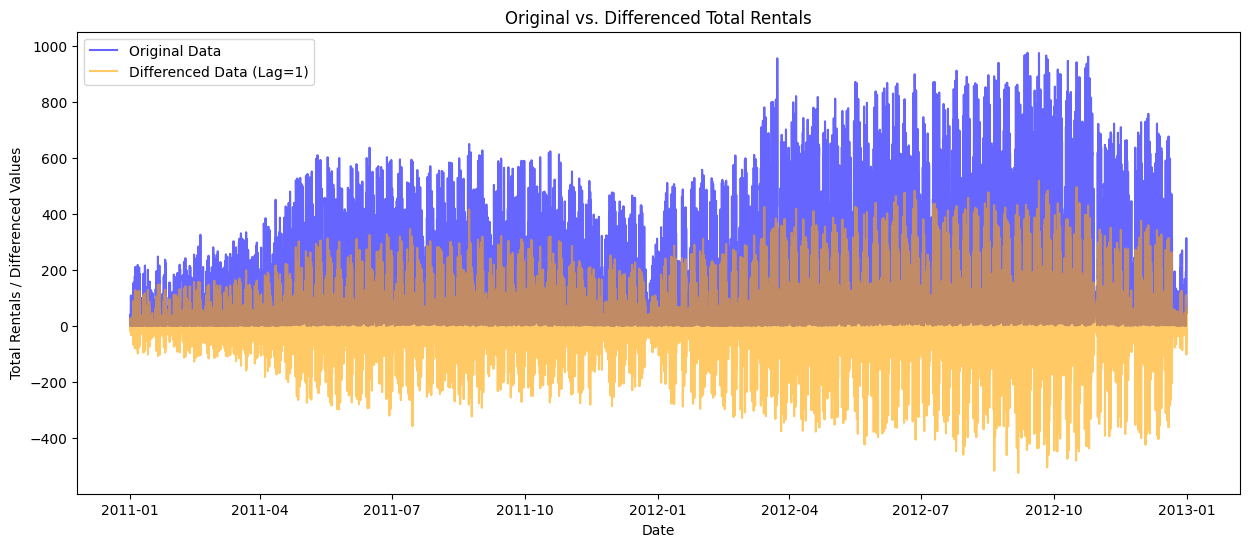

In [49]:
# Difference the data
df_hourly['rentals_diff_1'] = df_hourly['total_rentals'].diff(periods=1)

plt.figure(figsize=(15, 6))

# Plot original data
plt.plot(df_hourly['total_rentals'], label='Original Data', color='blue', alpha=0.6)

# Plot differenced data
plt.plot(df_hourly['rentals_diff_1'], label='Differenced Data (Lag=1)', color='orange', alpha=0.6)

plt.title('Original vs. Differenced Total Rentals')
plt.xlabel('Date')
plt.ylabel('Total Rentals / Differenced Values')
plt.legend()
plt.show()

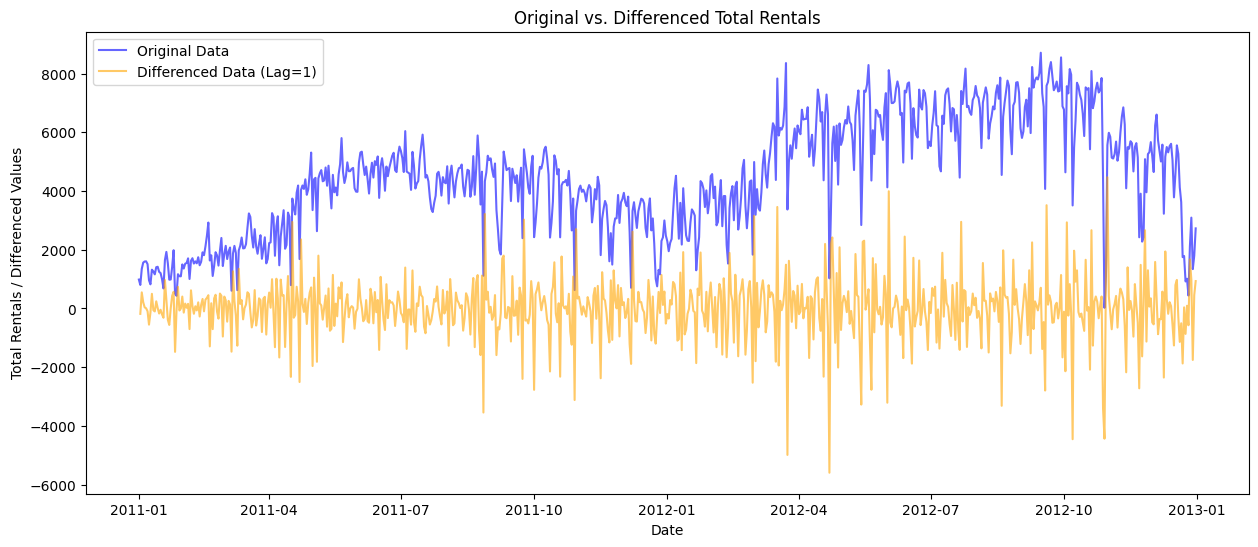

In [50]:
# Difference the data
df_daily['rentals_diff_1'] = df_daily['total_rentals'].diff(periods=1)

plt.figure(figsize=(15, 6))

# Plot original data
plt.plot(df_daily['total_rentals'], label='Original Data', color='blue', alpha=0.6)

# Plot differenced data
plt.plot(df_daily['rentals_diff_1'], label='Differenced Data (Lag=1)', color='orange', alpha=0.6)

plt.title('Original vs. Differenced Total Rentals')
plt.xlabel('Date')
plt.ylabel('Total Rentals / Differenced Values')
plt.legend()
plt.show()

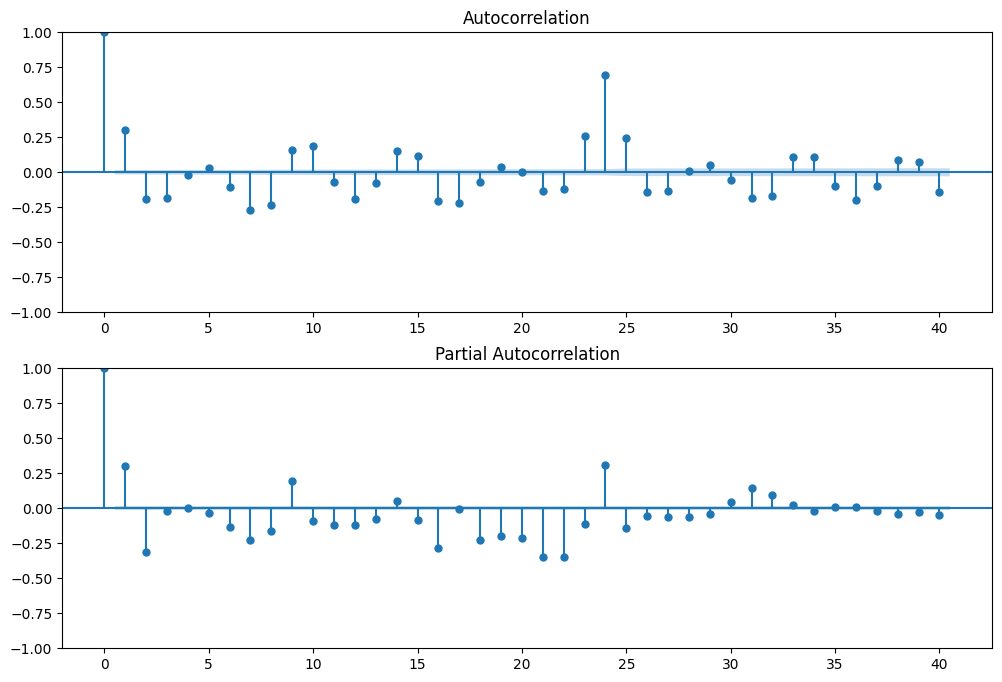

In [51]:
# Autocorrelation and partial autocorrelation plots
fig, ax = plt.subplots(2, figsize=(12,8))
sm.graphics.tsa.plot_acf(df_hourly['rentals_diff_1'].dropna(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(df_hourly['rentals_diff_1'].dropna(), lags=40, ax=ax[1])
plt.show()

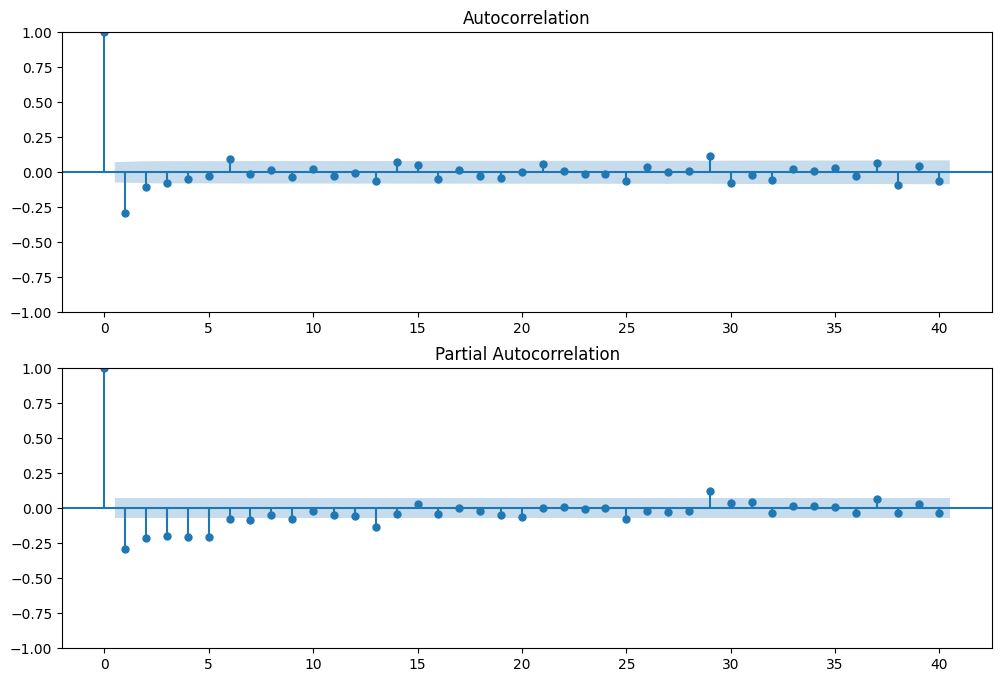

In [52]:
# Autocorrelation and partial autocorrelation plots
fig, ax = plt.subplots(2, figsize=(12,8))
sm.graphics.tsa.plot_acf(df_daily['rentals_diff_1'].dropna(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(df_daily['rentals_diff_1'].dropna(), lags=40, ax=ax[1])
plt.show()

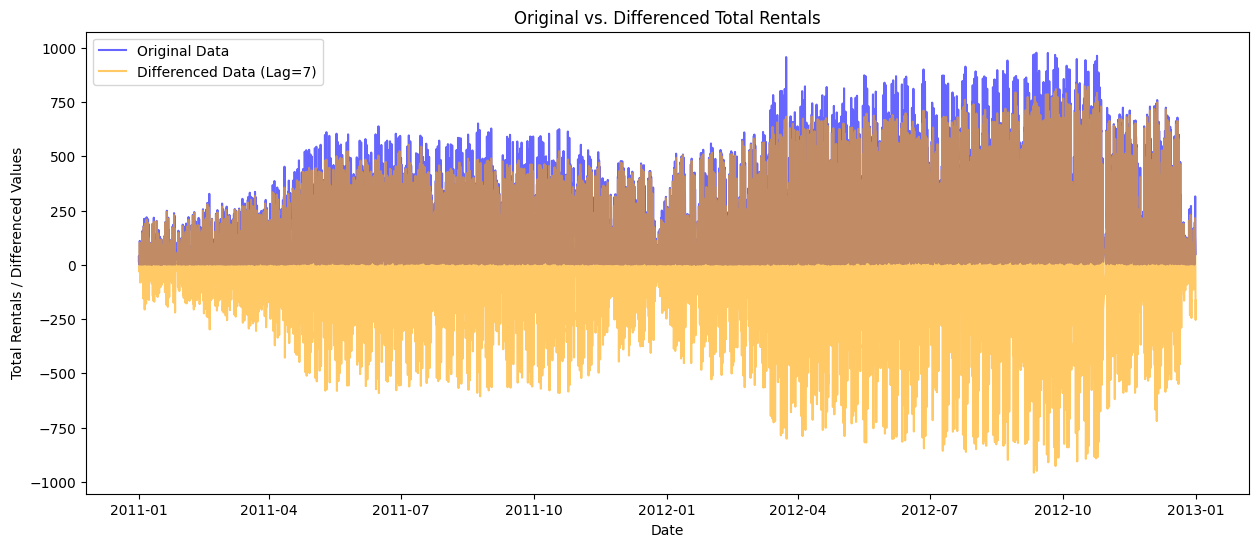

In [53]:
# Difference the data
df_hourly['rentals_diff_7'] = df_hourly['total_rentals'].diff(periods=7)

plt.figure(figsize=(15, 6))

# Plot original data
plt.plot(df_hourly['total_rentals'], label='Original Data', color='blue', alpha=0.6)

# Plot differenced data
plt.plot(df_hourly['rentals_diff_7'], label='Differenced Data (Lag=7)', color='orange', alpha=0.6)

plt.title('Original vs. Differenced Total Rentals')
plt.xlabel('Date')
plt.ylabel('Total Rentals / Differenced Values')
plt.legend()
plt.show()

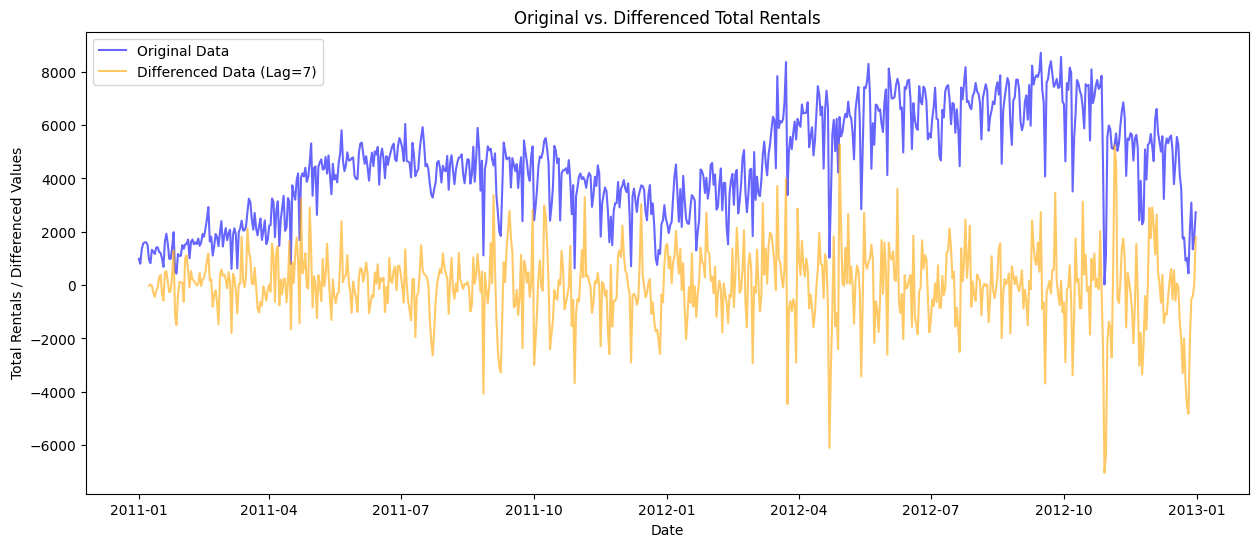

In [54]:
# Difference the data
df_daily['rentals_diff_7'] = df_daily['total_rentals'].diff(periods=7)

plt.figure(figsize=(15, 6))

# Plot original data
plt.plot(df_daily['total_rentals'], label='Original Data', color='blue', alpha=0.6)

# Plot differenced data
plt.plot(df_daily['rentals_diff_7'], label='Differenced Data (Lag=7)', color='orange', alpha=0.6)

plt.title('Original vs. Differenced Total Rentals')
plt.xlabel('Date')
plt.ylabel('Total Rentals / Differenced Values')
plt.legend()
plt.show()

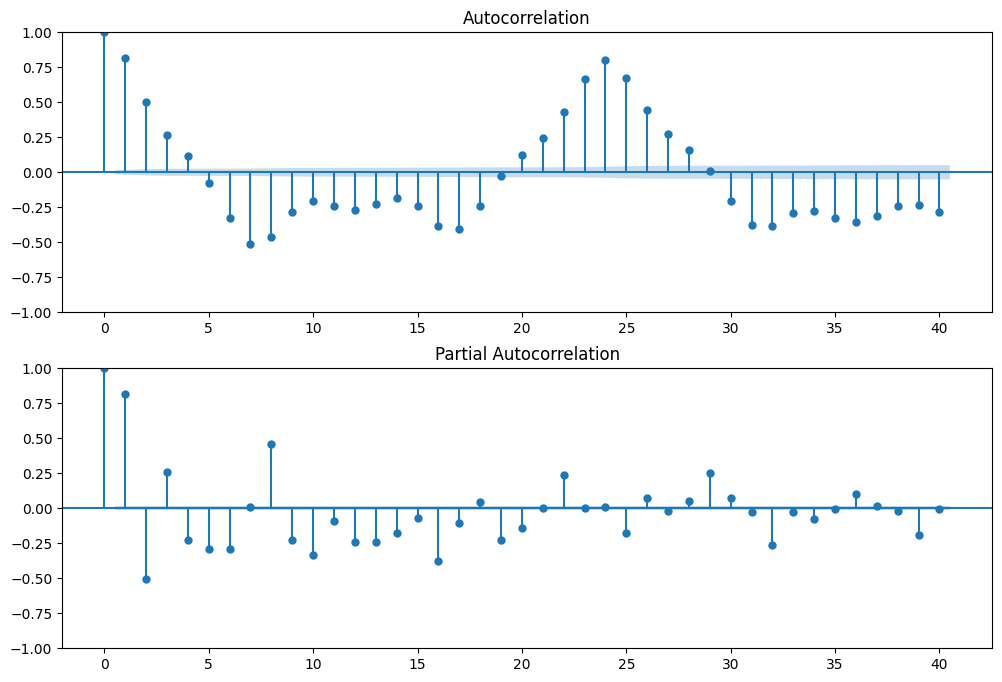

In [55]:
# Autocorrelation and partial autocorrelation plots
fig, ax = plt.subplots(2, figsize=(12,8))
sm.graphics.tsa.plot_acf(df_hourly['rentals_diff_7'].dropna(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(df_hourly['rentals_diff_7'].dropna(), lags=40, ax=ax[1])
plt.show()

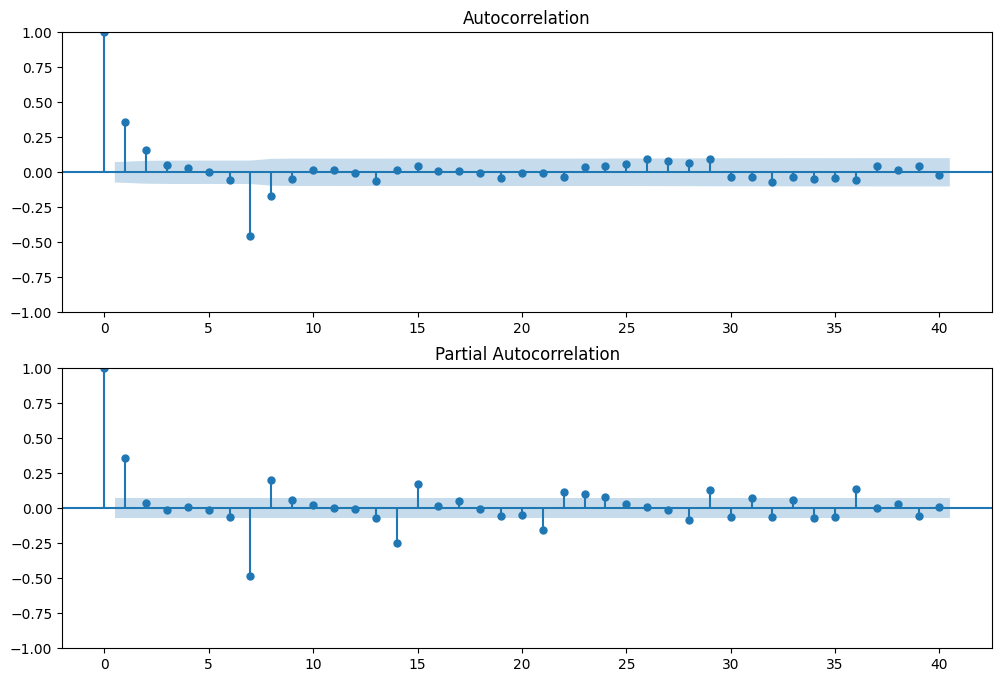

In [56]:
# Autocorrelation and partial autocorrelation plots
fig, ax = plt.subplots(2, figsize=(12,8))
sm.graphics.tsa.plot_acf(df_daily['rentals_diff_7'].dropna(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(df_daily['rentals_diff_7'].dropna(), lags=40, ax=ax[1])
plt.show()

## Smoothing

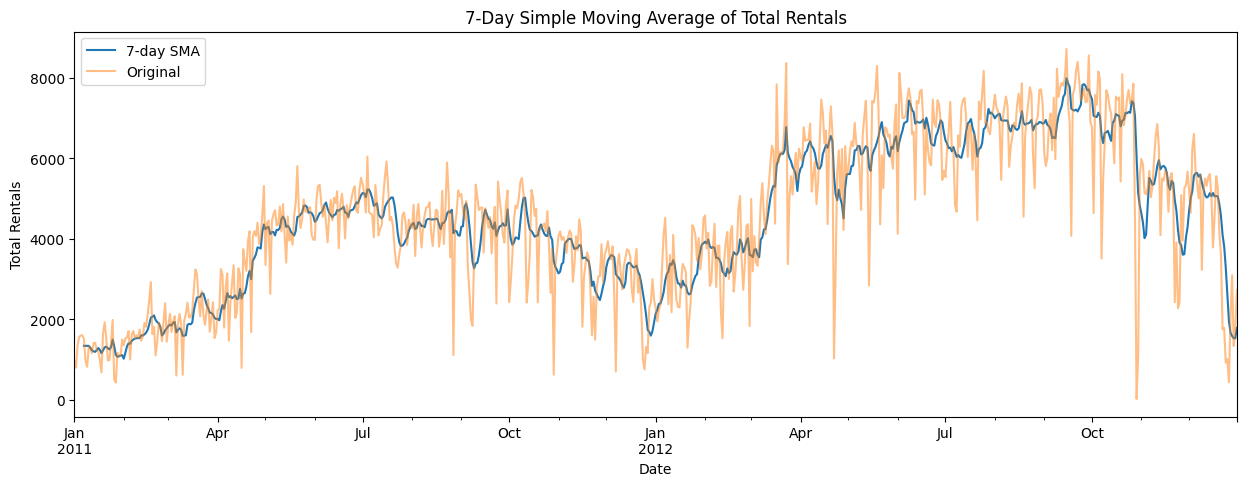

In [57]:
# Set the window size for the Simple Moving Average
window_size = 7

# Create the plot for the Simple Moving Average
plt.figure(figsize=(15, 5))
df_daily['total_rentals'].rolling(window=window_size).mean().plot(label='7-day SMA')
df_daily['total_rentals'].plot(alpha=0.5, label='Original')
plt.title('7-Day Simple Moving Average of Total Rentals')
plt.xlabel('Date')
plt.ylabel('Total Rentals')
plt.legend()
plt.show()

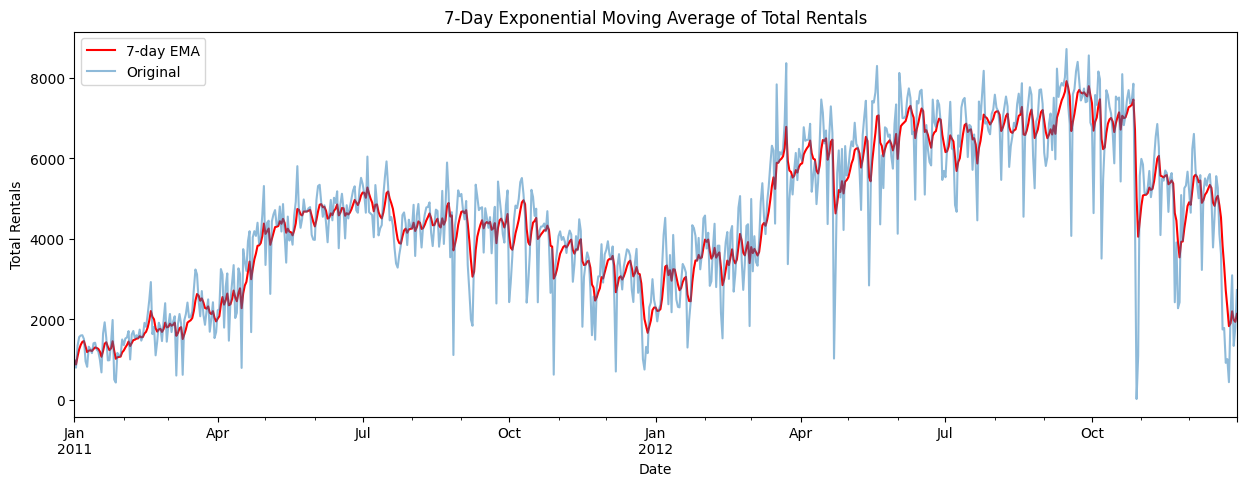

In [58]:
# Set the span for the Exponential Moving Average
span = 7

# Create the plot for the Exponential Moving Average
plt.figure(figsize=(15, 5))
df_daily['total_rentals'].ewm(span=span).mean().plot(color='red', label='7-day EMA')
df_daily['total_rentals'].plot(alpha=0.5, label='Original')
plt.title('7-Day Exponential Moving Average of Total Rentals')
plt.xlabel('Date')
plt.ylabel('Total Rentals')
plt.legend()
plt.show()

In [59]:
!pip install pykalman -q

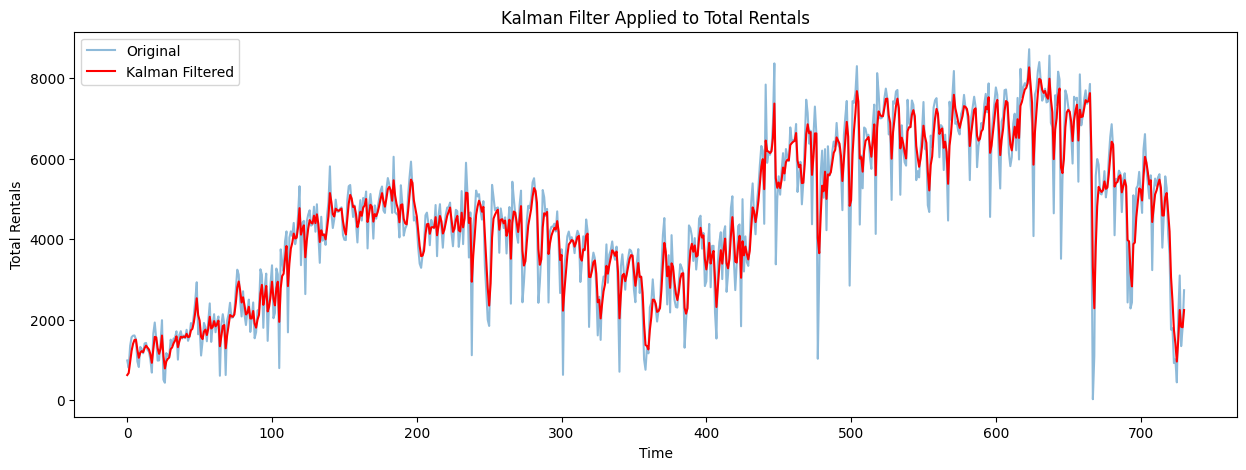

In [60]:
from pykalman import KalmanFilter

data = df_daily['total_rentals'].values

# Initialize the Kalman Filter
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)

# Set the parameters
kf = kf.em(data, n_iter=5)
(filtered_state_means, filtered_state_covariances) = kf.filter(data)

# Plotting the original and the filtered data
plt.figure(figsize=(15, 5))
plt.plot(data, label='Original', alpha=0.5)
plt.plot(filtered_state_means, label='Kalman Filtered', color='r')
plt.title('Kalman Filter Applied to Total Rentals')
plt.xlabel('Time')
plt.ylabel('Total Rentals')
plt.legend()
plt.show()

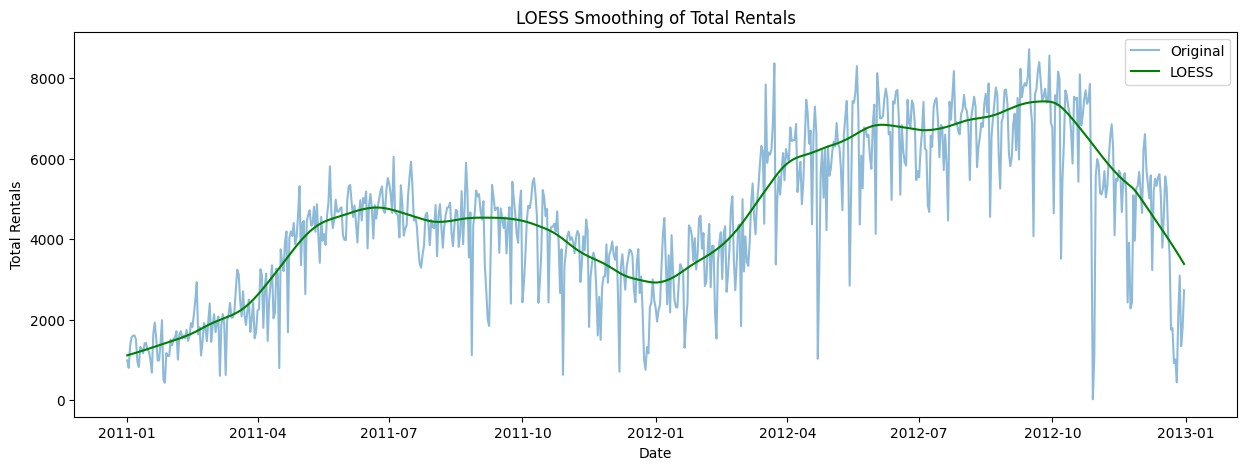

In [61]:
frac = 0.1  # Fraction of data to use for smoothing
loess_result = lowess(df_daily['total_rentals'], np.arange(len(df_daily)), frac=frac)

# Create the plot for LOESS
plt.figure(figsize=(15, 5))
plt.plot(df_daily['total_rentals'], label='Original', alpha=0.5)
plt.plot(df_daily.index, loess_result[:, 1], label='LOESS', color='green')
plt.title('LOESS Smoothing of Total Rentals')
plt.xlabel('Date')
plt.ylabel('Total Rentals')
plt.legend()
plt.show()

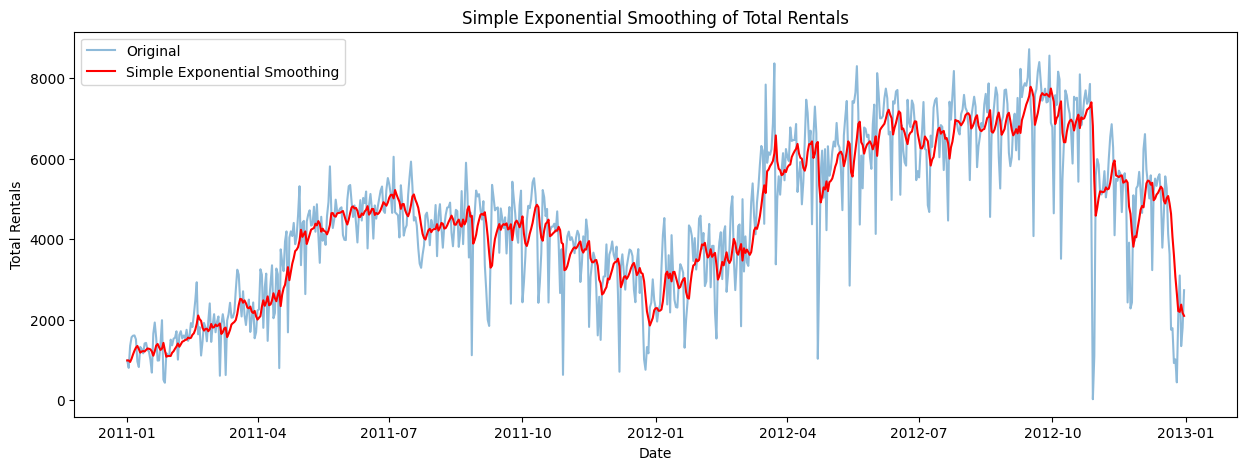

In [62]:
ses_model = SimpleExpSmoothing(df_daily['total_rentals']).fit(smoothing_level=0.2, optimized=False)

# Create the plot for SES
plt.figure(figsize=(15, 5))
plt.plot(df_daily['total_rentals'], label='Original', alpha=0.5)
plt.plot(df_daily.index, ses_model.fittedvalues, label='Simple Exponential Smoothing', color='red')
plt.title('Simple Exponential Smoothing of Total Rentals')
plt.xlabel('Date')
plt.ylabel('Total Rentals')
plt.legend()
plt.show()

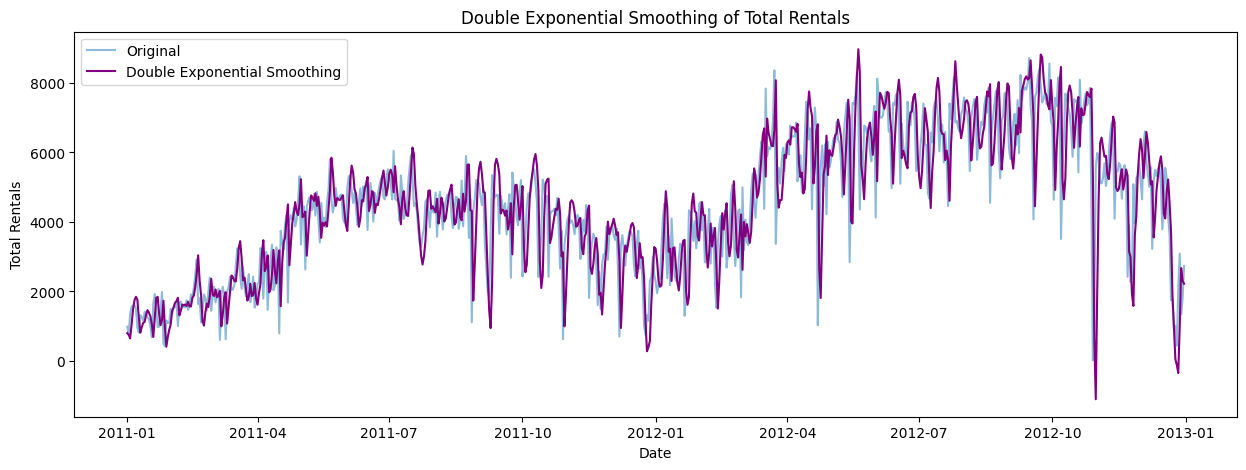

In [63]:
des_model = Holt(df_daily['total_rentals']).fit(smoothing_level=0.5, smoothing_trend=0.5, optimized=False)

# Create the plot for DES
plt.figure(figsize=(15, 5))
plt.plot(df_daily['total_rentals'], label='Original', alpha=0.5)
plt.plot(df_daily.index, des_model.fittedvalues, label='Double Exponential Smoothing', color='purple')
plt.title('Double Exponential Smoothing of Total Rentals')
plt.xlabel('Date')
plt.ylabel('Total Rentals')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


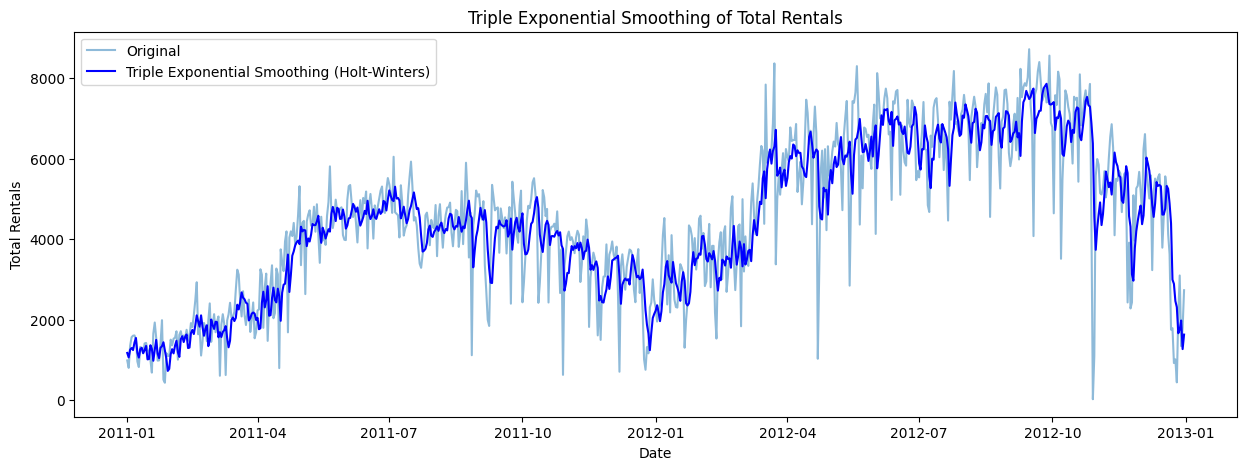

In [64]:
seasonal_periods = 7  # Weekly seasonality
tes_model = ExponentialSmoothing(df_daily['total_rentals'],
                                 trend='add', seasonal='add',
                                 seasonal_periods=seasonal_periods,
                                 initialization_method='estimated',
                                 use_boxcox=True).fit()

# Create the plot for TES
plt.figure(figsize=(15, 5))
plt.plot(df_daily['total_rentals'], label='Original', alpha=0.5)
plt.plot(df_daily.index, tes_model.fittedvalues, label='Triple Exponential Smoothing (Holt-Winters)', color='blue')
plt.title('Triple Exponential Smoothing of Total Rentals')
plt.xlabel('Date')
plt.ylabel('Total Rentals')
plt.legend()
plt.show()

## ARIMA Permutations

  0%|          | 0/27 [00:00<?, ?it/s]

Trying ARIMA Model: pdq=(1, 2, 2) with AIC=12037.455041713103


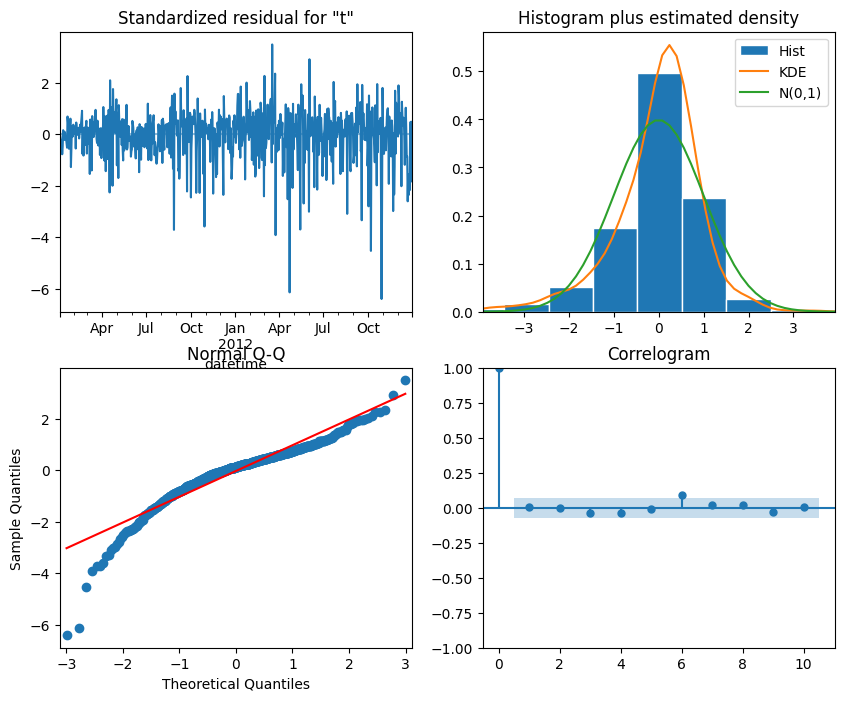

Best ARIMA Model: pdq=(1, 2, 2) with AIC=12037.455041713103


In [65]:
import warnings
import itertools
from tqdm.notebook import tqdm

# Suppress warnings for ARIMA fits
warnings.filterwarnings('ignore')

# Define the p, d, and q parameters
p = d = q = range(0, 3)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))

models_aic = {}

# Grid search for ARIMA models
for param in tqdm(pdq):
    try:
        temp_model = ARIMA(df_daily['total_rentals'], order=param)
        results = temp_model.fit()
        models_aic[param] = results.aic
    except:
        continue

# Sort models by AIC
sorted_models = sorted(models_aic.items(), key=lambda x: x[1])

# Attempt to plot the best models
for pdq, aic in sorted_models:
    try:
        temp_model = ARIMA(df_daily['total_rentals'], order=pdq)
        best_model = temp_model.fit()
        print(f'Trying ARIMA Model: pdq={pdq} with AIC={aic}')
        best_model.plot_diagnostics(figsize=(10, 8))
        plt.show()
        print(f'Best ARIMA Model: pdq={pdq} with AIC={aic}')
        break  # Exit the loop if plot is successful
    except Exception as e:
        print(f'An error occurred while plotting diagnostics for model pdq={pdq}: {e}')
        continue  # Try the next model

if not best_model:
    print('No suitable model was found.')

# Preprocessing the Data

## Splitting the Data

In [66]:
# Define the time series of interest
time_series = df_daily['total_rentals']

# Shape of the daily dataset
shape = time_series.shape
print(f'There are {shape[0]} samples in the hourly dataset.')

There are 731 samples in the hourly dataset.


In [67]:
# Print the time series
time_series[:5]

datetime
2011-01-01     985
2011-01-02     801
2011-01-03    1349
2011-01-04    1562
2011-01-05    1600
Freq: D, Name: total_rentals, dtype: int64

In [68]:
# Calculate the indices for the end of each partition
total_samples = shape[0]
train_end = int(total_samples * 0.6)
val_end = int(total_samples * 0.8)

# Split the dataset
train_set = time_series.iloc[:train_end].values.reshape(-1, 1)
val_set = time_series.iloc[train_end:val_end].values.reshape(-1, 1)
test_set = time_series.iloc[val_end:].values.reshape(-1, 1)

# Print the shapes of the splits
print(f'Training Set Shape: {train_set.shape}')
print(f'Validation Set Shape: {val_set.shape}')
print(f'Test Set Shape: {test_set.shape}')

Training Set Shape: (438, 1)
Validation Set Shape: (146, 1)
Test Set Shape: (147, 1)


In [69]:
# Print an array
train_set[:5]

array([[ 985],
       [ 801],
       [1349],
       [1562],
       [1600]])

In [70]:
# Print mean and std
print(f'Training Set Mean: {train_set.mean()}')
print(f'Training Set Std: {train_set.std()}')

Training Set Mean: 3426.9109589041095
Training Set Std: 1319.1309574637626


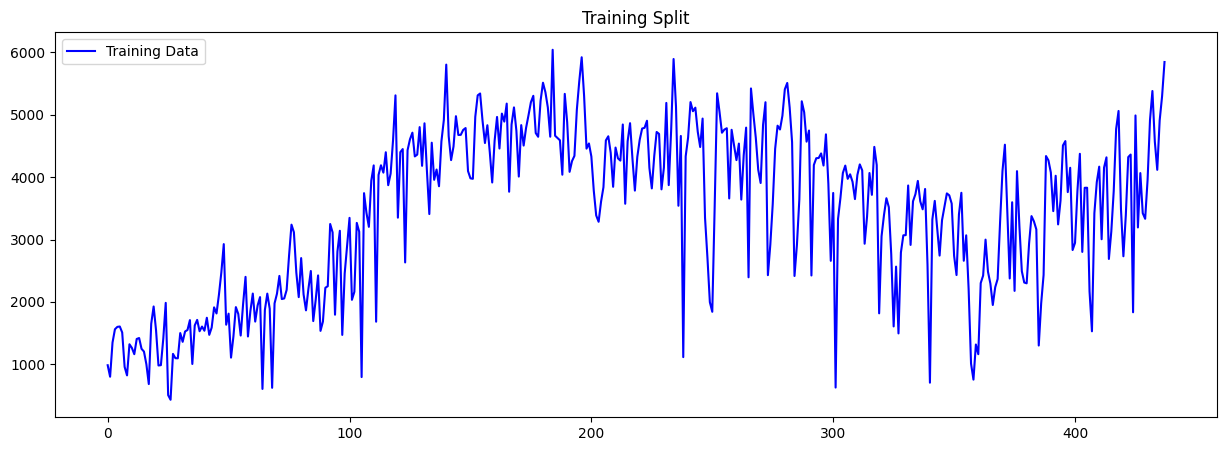

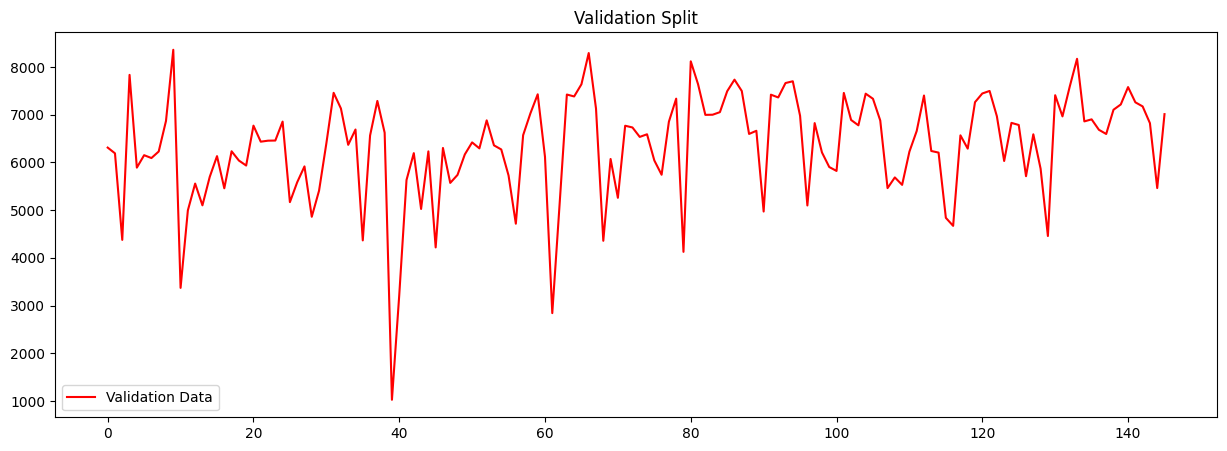

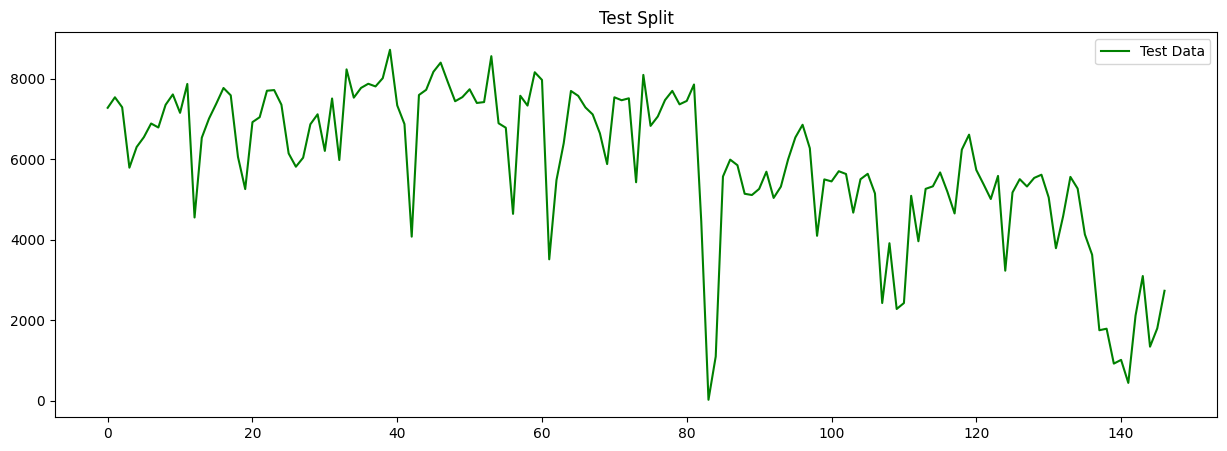

In [71]:
# Function to plot each time series split
def visualize_splits(train_set, val_set, test_set):
    # Create list of splits, names, and colors
    splits = [train_set, val_set, test_set]
    names = ['Training', 'Validation', 'Test']
    colors = ['blue', 'red', 'green']

    # Iterate through lists to plot the sets
    for split, name, color in zip(splits, names, colors):
        split_df = pd.DataFrame(split)
        split_df.plot(color=color, figsize=(15, 5), title=f'{name} Split')
        plt.legend([f'{name} Data'])
        plt.show()

# Call the function
visualize_splits(train_set, val_set, test_set)

## Normalizing the Data

In [72]:
# Initialize the scaler
scaler = MinMaxScaler(feature_range=(1e-8, 1))

In [73]:
# Fit and transform the test set
train_scaled = scaler.fit_transform(train_set)

# Transform the validation and test sets
val_scaled = scaler.transform(val_set)
test_scaled = scaler.transform(test_set)

In [74]:
# Print the shapes of the normalized sequences
print(f'Training Set Shape: {train_scaled.shape}')
print(f'Validation Set Shape: {val_scaled.shape}')
print(f'Test Set Shape: {test_scaled.shape}')

Training Set Shape: (438, 1)
Validation Set Shape: (146, 1)
Test Set Shape: (147, 1)


In [75]:
# Print an array
train_scaled[:5]

array([[0.09871704],
       [0.06593016],
       [0.16357806],
       [0.20153244],
       [0.20830364]])

In [76]:
# Print mean and std
print(f'Training Set Mean: {train_scaled.mean()}')
print(f'Training Set Std: {train_scaled.std()}')

Training Set Mean: 0.5338401612731646
Training Set Std: 0.23505540703358038


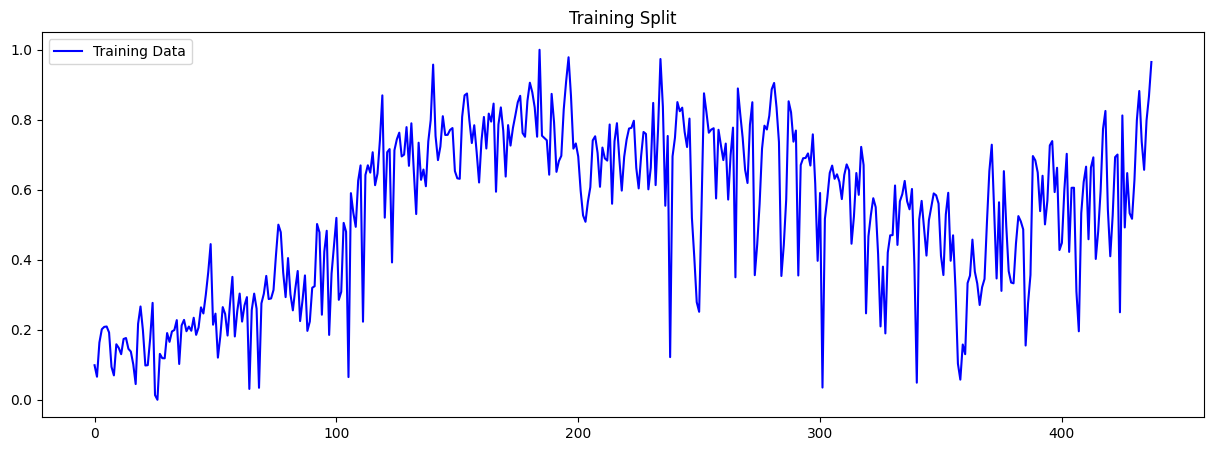

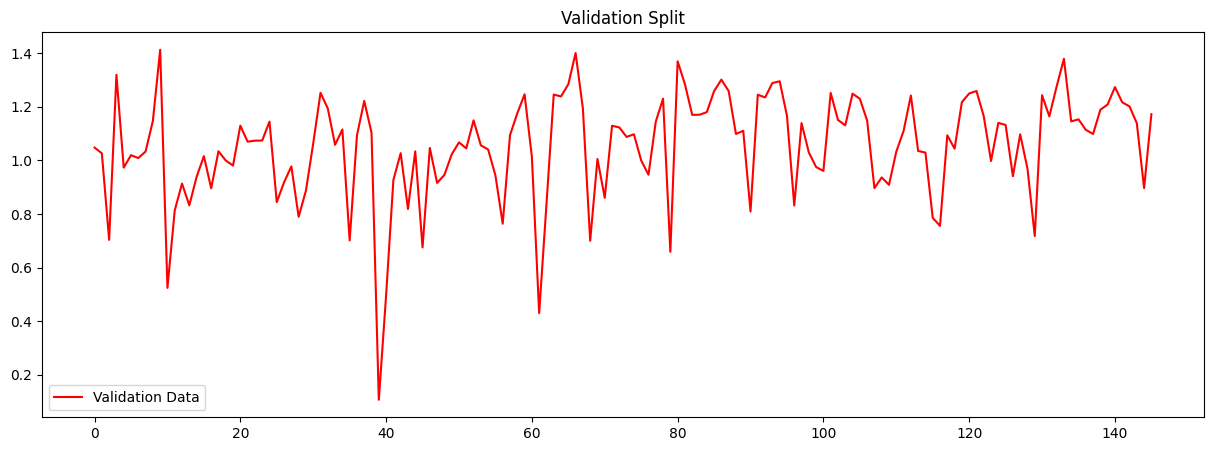

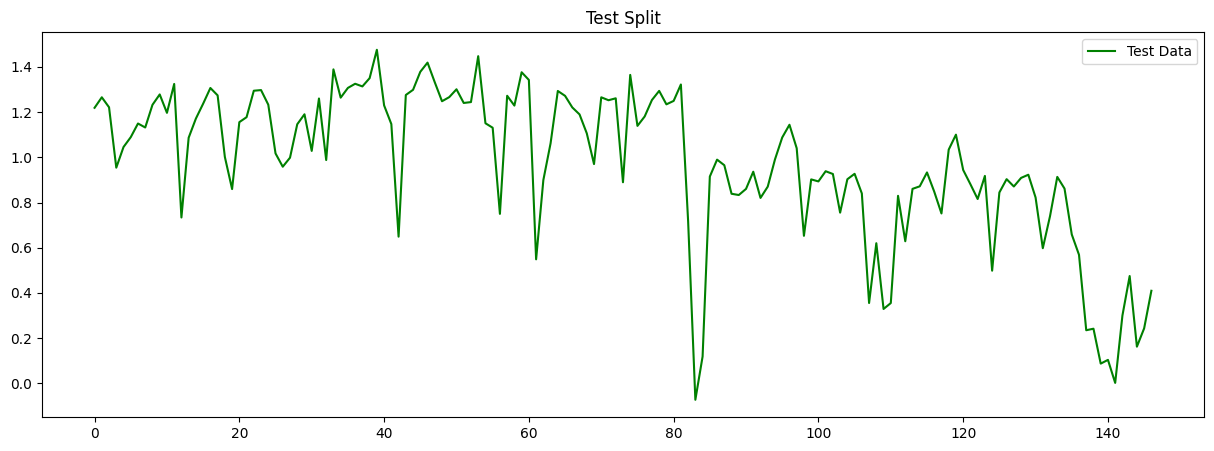

In [77]:
# Visualize the normalized splits
visualize_splits(train_scaled, val_scaled, test_scaled)

## Windowing the Data

In [78]:
# Windowing function for univariate time series analysis
def create_windows(data, window_size, horizon):
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + horizon])
    X, y = np.array(X), np.array(y)
    return torch.tensor(X).float(), torch.tensor(y).float()

In [79]:
# Define window size and horizon
WINDOW_SIZE = 7
HORIZON = 1

# Apply the function to the datasets
X_train, y_train = create_windows(train_scaled, WINDOW_SIZE, HORIZON)
X_val, y_val = create_windows(val_scaled, WINDOW_SIZE, HORIZON)
X_test, y_test = create_windows(test_scaled, WINDOW_SIZE, HORIZON)

In [80]:
# Print the shapes of the sequences
print(f'X Training Set Shape: {X_train.shape}')
print(f'X Validation Set Shape: {X_val.shape}')
print(f'X Test Set Shape: {X_test.shape}\n')

print(f'y Training Set Shape: {y_train.shape}')
print(f'y Validation Set Shape: {y_val.shape}')
print(f'y Test Set Shape: {y_test.shape}')

X Training Set Shape: torch.Size([431, 7, 1])
X Validation Set Shape: torch.Size([139, 7, 1])
X Test Set Shape: torch.Size([140, 7, 1])

y Training Set Shape: torch.Size([431, 1, 1])
y Validation Set Shape: torch.Size([139, 1, 1])
y Test Set Shape: torch.Size([140, 1, 1])


In [81]:
# Print X sequences
X_train[:2]

tensor([[[0.0987],
         [0.0659],
         [0.1636],
         [0.2015],
         [0.2083],
         [0.2094],
         [0.1923]],

        [[0.0659],
         [0.1636],
         [0.2015],
         [0.2083],
         [0.2094],
         [0.1923],
         [0.0941]]])

In [82]:
# Print y sequences
y_train[:2]

tensor([[[0.0941]],

        [[0.0697]]])

## Creating DataLoaders

In [83]:
BATCH_SIZE = 16

# Create Tensor datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [84]:
# Function to print shapes of a single batch in DataLoader
def print_dataloader_shapes(loader, name):
    for X_batch, y_batch in loader:
        print(f'{name} Batch - X Shape: {X_batch.shape}, y Shape: {y_batch.shape}')
        break  # Stop after the first batch

# Print shapes for each DataLoader
print_dataloader_shapes(train_loader, 'Training')
print_dataloader_shapes(val_loader, 'Validation')
print_dataloader_shapes(test_loader, 'Testing')

Training Batch - X Shape: torch.Size([16, 7, 1]), y Shape: torch.Size([16, 1, 1])
Validation Batch - X Shape: torch.Size([16, 7, 1]), y Shape: torch.Size([16, 1, 1])
Testing Batch - X Shape: torch.Size([16, 7, 1]), y Shape: torch.Size([16, 1, 1])


# Bayesian LSTM Model

## Model Architecture

In [85]:
# LSTM Model with Bayesian FC Layer
class BayesianLSTM(PyroModule):
    def __init__(self, input_dim, lstm_hidden_dim, fc_hidden_dim, output_dim,
                 num_layers=4, dropout_rate=0.2, residual_interval=2):
        super(BayesianLSTM, self).__init__()

        # Residual connection interval
        self.residual_interval = residual_interval

        # Device configuration
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # LSTM layers for layer-wise processing
        self.lstm_layers = nn.ModuleList([
            nn.LSTM(input_dim if i == 0 else lstm_hidden_dim, lstm_hidden_dim, 1, batch_first=True)
            for i in range(num_layers)
        ])

        # Residual connections
        self.residuals = nn.ModuleList([
            nn.Linear(input_dim, lstm_hidden_dim) if i == 0 else nn.Identity()
            for i in range(num_layers)
        ])

        # Dropout layers
        self.dropout_layers = nn.ModuleList([
            nn.Dropout(dropout_rate) if i < num_layers - 1 else nn.Identity()  # No dropout on the last layer
            for i in range(num_layers)
        ])

        # Layer normalization
        self.layer_norms = nn.ModuleList([
            nn.LayerNorm(lstm_hidden_dim) for _ in range(num_layers)
        ])

        # First fully connected layer
        self.fc1 = PyroModule[nn.Linear](lstm_hidden_dim, fc_hidden_dim)
        self.fc1.weight = PyroSample(dist.Gamma(
            torch.tensor(1., device=device),
            torch.tensor(2., device=device)).expand(
                [fc_hidden_dim, lstm_hidden_dim]).to_event(2))

        self.fc1.bias = PyroSample(dist.Gamma(
            torch.tensor(1., device=device),
            torch.tensor(2., device=device)).expand(
                [fc_hidden_dim]).to_event(1))

        # Second fully connected layer
        self.fc2 = PyroModule[nn.Linear](fc_hidden_dim, fc_hidden_dim)
        self.fc2.weight = PyroSample(dist.Gamma(
            torch.tensor(1., device=device),
            torch.tensor(2., device=device)).expand(
                [fc_hidden_dim, fc_hidden_dim]).to_event(2))

        self.fc2.bias = PyroSample(dist.Gamma(
            torch.tensor(1., device=device),
            torch.tensor(2., device=device)).expand(
                [fc_hidden_dim]).to_event(1))

        # Third fully connected layer
        self.fc3 = PyroModule[nn.Linear](fc_hidden_dim, output_dim)
        self.fc3.weight = PyroSample(dist.Gamma(
            torch.tensor(1., device=device),
            torch.tensor(2., device=device)).expand(
                [output_dim, fc_hidden_dim]).to_event(2))

        self.fc3.bias = PyroSample(dist.Gamma(
            torch.tensor(1., device=device),
            torch.tensor(2., device=device)).expand(
                [output_dim]).to_event(1))

        # Activation function
        self.activation = nn.ReLU()

    def forward(self, x, y=None):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        lstm_out = self.process_lstm(x)
        mu = self.process_fc(lstm_out)

        # Sample concentration and rate for the Gamma distribution
        concentration = pyro.sample('concentration', dist.Uniform(
            torch.tensor(1., device=device),
            torch.tensor(3., device=device)))
        rate = pyro.sample('rate', dist.Uniform(
            torch.tensor(1., device=device),
            torch.tensor(3., device=device)))

        with pyro.plate('data', x.shape[0]):
            # Observations sampled from a Gamma distribution
            obs = pyro.sample('obs', dist.Gamma(
                concentration, rate/mu), obs=y)

        return mu

    def process_lstm(self, x):
        out = x
        for i, (lstm_layer, dropout_layer, layer_norm, residual) in \
        enumerate(zip(self.lstm_layers,
                      self.dropout_layers,
                      self.layer_norms,
                      self.residuals)):
            lstm_out, _ = lstm_layer(out)

            if i % self.residual_interval == self.residual_interval - 1:
                res_out = residual(out)
                lstm_out = lstm_out + res_out
                lstm_out = layer_norm(lstm_out)
                lstm_out = dropout_layer(lstm_out)

            out = lstm_out

        return out[:, -1, :]  # Return the output of the last time step

    def process_fc(self, lstm_out):
        x = self.activation(self.fc1(lstm_out))
        x = self.activation(self.fc2(x))
        mu = self.fc3(x).view(-1)
        return mu

## Trainer Class

In [86]:
# BayesianLSTM Trainer
class BayesianLSTMTrainer:
    # Initialize the trainer with necessary objects
    def __init__(self, model, guide, train_loader, val_loader, epochs=100,
                 learning_rate=0.0001, weight_decay=1e-4,
                 clip_norm=1.0, beta1=0.9, beta2=0.999,
                 lr_decay=1.0, denom_constant=1e-8,
                 patience=10, min_delta=1.0, mode='min'):
        self.model = model
        self.guide = guide
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.clip_norm = clip_norm
        self.beta1 = beta1
        self.beta2 = beta2
        self.lr_decay = lr_decay
        self.denom_constant = denom_constant
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.guide.to(self.device)
        self.optimizer = pyro.optim.ClippedAdam(
            {'lr': self.learning_rate, 'weight_decay': self.weight_decay,
             'clip_norm': self.clip_norm, 'betas': (self.beta1, self.beta2),
             'lrd': self.lr_decay, 'eps': self.denom_constant})
        self.svi = SVI(self.model, self.guide, self.optimizer,
                       loss=JitTraceGraph_ELBO(num_particles=10))

        # Early stopping parameters
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.best_val_loss = float('inf') if mode == 'min' else -float('inf')
        self.patience_counter = 0

    # Helper function to calculate NLL
    def calculate_nll(self, predictions, targets, sigma=1.0):
        normal_dist = torch.distributions.Normal(predictions, sigma)
        return -normal_dist.log_prob(targets).mean()

    # Train the model for one epoch and caluculate the training loss
    def train_epoch(self):
        self.model.train()
        total_loss, total_nll = 0.0, 0.0
        for X_batch, y_batch in self.train_loader:
            X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
            if y_batch.dim() > 2:
                y_batch = y_batch.view(-1)
            loss = self.svi.step(X_batch, y_batch)
            total_loss += loss

            # Generate predictions and calculate NLL
            predictions = self.model(X_batch)
            nll = self.calculate_nll(predictions, y_batch)
            total_nll += nll.item()

        avg_loss = round(total_loss / len(self.train_loader), 4)
        avg_nll = round(total_nll / len(self.train_loader), 4)
        return avg_loss, avg_nll

    # Validate the model for one epoch and calculate validation loss
    def validate_epoch(self):
        self.model.eval()
        total_loss, total_nll = 0.0, 0.0
        with torch.no_grad():
            for X_val, y_val in self.val_loader:
                X_val, y_val = X_val.to(self.device), y_val.to(self.device)
                if y_val.dim() > 2:
                    y_val = y_val.view(-1)
                loss = self.svi.evaluate_loss(X_val, y_val)
                total_loss += loss

                # Generate predictions and calculate NLL
                predictions = self.model(X_val)
                nll = self.calculate_nll(predictions, y_val)
                total_nll += nll.item()

        avg_loss = round(total_loss / len(self.val_loader), 4)
        avg_nll = round(total_nll / len(self.val_loader), 4)
        return avg_loss, avg_nll

    # Main training loop for the specified number of epochs
    def train(self):
        best_model = None

        train_losses, val_losses, train_nlls, val_nlls = [], [], [], []

        for epoch in range(self.epochs):
            train_loss, train_nll = self.train_epoch()
            train_losses.append(train_loss)
            train_nlls.append(train_nll)

            if self.val_loader is not None:
                val_loss, val_nll = self.validate_epoch()
                val_losses.append(val_loss)
                val_nlls.append(val_nll)

                # Check improvement for early stopping
                improvement = (val_loss < self.best_val_loss - self.min_delta) if self.mode == 'min' else (val_loss > self.best_val_loss + self.min_delta)
                if improvement:
                    self.best_val_loss = val_loss
                    self.patience_counter = 0
                    # Save the best model
                    best_model = copy.deepcopy(self.model.state_dict())
                    best_epoch = epoch + 1
                else:
                    self.patience_counter += 1

                # Check if patience has run out
                if self.patience_counter > self.patience:
                    print('Early stopping triggered')
                    break

            if (epoch + 1) % 10 == 0:
                print(f'Epoch {epoch + 1}/{self.epochs}, Training Loss: {train_loss}, Training NLL: {train_nll}, Validation Loss: {val_loss}, Validation NLL: {val_nll}')

        # Save the best model after training is complete
        if best_model is not None:
            torch.save(best_model, 'best_model_bayesian.pth')
            print(f'Best model saved from epoch {best_epoch} with Validation Loss: {self.best_val_loss}')

        return train_losses, val_losses, train_nlls, val_nlls

## Training Configuration & Run

In [87]:
# Clear the parameter store
pyro.clear_param_store()

In [88]:
# Set the parameters for the training loop
INPUT_DIM = 1
LSTM_HIDDEN_DIM = 2
FC_HIDDEN_DIM = 2
OUTPUT_DIM = 1
NUM_LAYERS = 1
RESIDUAL_INTERVAL = 1
DROPOUT_RATE = 0.001
LEARNING_RATE = 0.005
WEIGHT_DECAY = 1e-3
CLIP_NORM = 1.0
BETA1 = 0.9
BETA2 = 0.999
LR_DECAY = 1.0
DENOM_CONSTANT = 1e-8
PATIENCE = 50
MIN_DELTA = 5
EPOCHS = 100

In [89]:
# Create model instance
bayesian_model = BayesianLSTM(INPUT_DIM,
                              LSTM_HIDDEN_DIM,
                              FC_HIDDEN_DIM,
                              OUTPUT_DIM,
                              NUM_LAYERS,
                              DROPOUT_RATE,
                              RESIDUAL_INTERVAL)

# Define the guide
guide = pyro.infer.autoguide.AutoDiagonalNormal(bayesian_model)

In [90]:
# Create Trainer instance
trainer_bayesian = BayesianLSTMTrainer(bayesian_model, guide,
                                       train_loader, val_loader,
                                       EPOCHS, LEARNING_RATE,
                                       WEIGHT_DECAY,CLIP_NORM,
                                       BETA1, BETA2,
                                       LR_DECAY, DENOM_CONSTANT,
                                       PATIENCE, MIN_DELTA)

# Run the training loop with Trainer
train_losses_bayesian, val_losses_bayesian, \
train_nlls_bayesian, val_nlls_bayesian = trainer_bayesian.train()

Epoch 10/100, Training Loss: 19.3676, Training NLL: 3.4297, Validation Loss: 31.6536, Validation NLL: 1.0978
Epoch 20/100, Training Loss: 10.6614, Training NLL: 1.6213, Validation Loss: 23.5344, Validation NLL: 1.3965
Epoch 30/100, Training Loss: 8.7649, Training NLL: 1.4688, Validation Loss: 22.3994, Validation NLL: 1.1004
Epoch 40/100, Training Loss: 9.8665, Training NLL: 1.4029, Validation Loss: 22.3049, Validation NLL: 1.0918
Epoch 50/100, Training Loss: 9.6717, Training NLL: 1.6763, Validation Loss: 24.5319, Validation NLL: 1.1574
Epoch 60/100, Training Loss: 9.5623, Training NLL: 1.3316, Validation Loss: 21.5513, Validation NLL: 1.2496
Early stopping triggered
Best model saved from epoch 15 with Validation Loss: 25.8067


## Plotting Training Results

In [91]:
# Training Plotter Class
class TrainingPlotter:
    def __init__(self, max_epochs):
        self.max_epochs = max_epochs

    def _choose_scale(self, values):
        # Determine the range of the values
        value_range = np.max(values) - np.min(values)
        # If the range is large, use a logarithmic scale
        return 'log' if value_range > 1e3 else 'linear'

    def plot_losses(self, train_losses, val_losses):
        actual_epochs = len(train_losses)
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, actual_epochs + 1), train_losses, label='Training Loss')
        plt.plot(range(1, actual_epochs + 1), val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Losses')
        plt.xticks(range(0, actual_epochs + 1, max(1, actual_epochs // 10)))
        plt.yscale(self._choose_scale(train_losses + val_losses))
        plt.legend()
        plt.show()

    def plot_nlls(self, train_nlls, val_nlls):
        actual_epochs = len(train_nlls)
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, actual_epochs + 1), train_nlls, label='Training NLL')
        plt.plot(range(1, actual_epochs + 1), val_nlls, label='Validation NLL')
        plt.xlabel('Epochs')
        plt.ylabel('Negative Log Likelihood')
        plt.title('Training and Validation NLL')
        plt.xticks(range(0, actual_epochs + 1, max(1, actual_epochs // 10)))
        plt.yscale(self._choose_scale(train_nlls + val_nlls))
        plt.legend()
        plt.show()

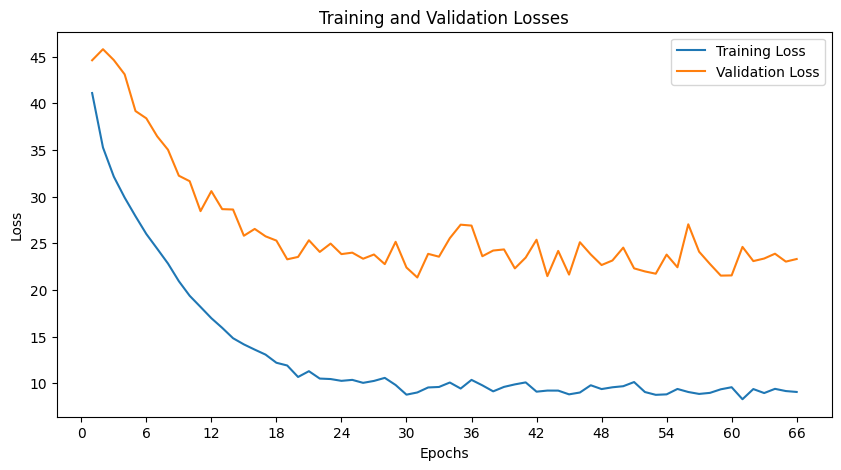

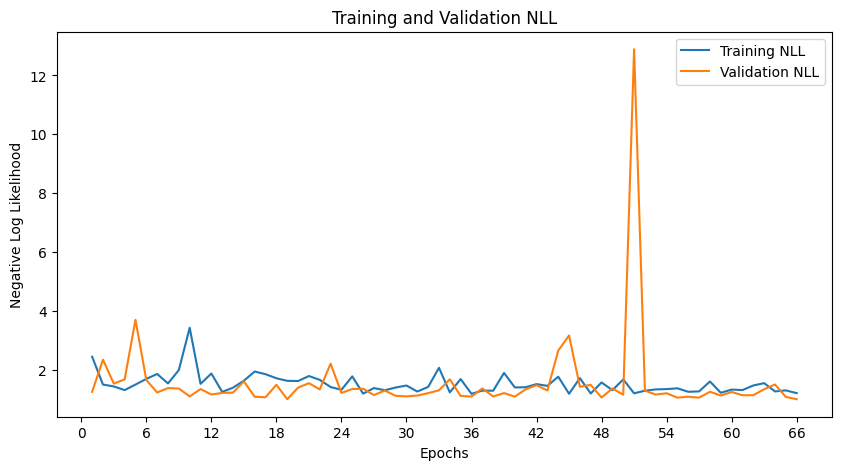

In [92]:
# Create Training Plotter instance
plotter_bayesian = TrainingPlotter(EPOCHS)

# Call the plotting methods
plotter_bayesian.plot_losses(train_losses_bayesian, val_losses_bayesian)
plotter_bayesian.plot_nlls(train_nlls_bayesian, val_nlls_bayesian)

In [93]:
# Load best model
best_model_state_bayesian = torch.load('best_model_bayesian.pth')
bayesian_model.load_state_dict(best_model_state_bayesian)

<All keys matched successfully>

In [94]:
# Examine optimized parameter values from param store
guide.requires_grad_(False)
for name, value in pyro.get_param_store().items():
    print(f'{name}: {pyro.param(name)}')
    print('-' * 50)

lstm_layers$$$0.weight_ih_l0: Parameter containing:
tensor([[ 0.0045],
        [ 0.0318],
        [ 0.0018],
        [ 0.0269],
        [-0.0134],
        [ 0.0397],
        [ 0.0093],
        [ 0.0312]], requires_grad=True)
--------------------------------------------------
lstm_layers$$$0.weight_hh_l0: Parameter containing:
tensor([[-2.0142e-04, -2.5361e-04],
        [ 1.3476e-03,  1.4633e-03],
        [-1.8952e-04, -8.2465e-05],
        [ 3.4210e-04, -3.3421e-04],
        [-1.8143e-02, -1.6595e-02],
        [ 1.3575e-02,  1.5599e-02],
        [-4.4850e-05, -8.8277e-04],
        [ 3.4399e-04, -8.0772e-04]], requires_grad=True)
--------------------------------------------------
lstm_layers$$$0.bias_ih_l0: Parameter containing:
tensor([ 0.0029,  0.0211, -0.0125,  0.0135,  0.0320, -0.0357, -0.0144,  0.0259],
       requires_grad=True)
--------------------------------------------------
lstm_layers$$$0.bias_hh_l0: Parameter containing:
tensor([-0.0172,  0.0226, -0.0199,  0.0152,  0.0337, 

In [95]:
# Analyze quantiles for latent parameters
quantiles = guide.quantiles([0.25, 0.5, 0.75])
for param, values in quantiles.items():
    print(f'{param} quantiles: \n{values}')
    print('-' * 50)

fc1.weight quantiles: 
tensor([[[0.1579, 0.1722],
         [0.1600, 0.1756]],

        [[0.3141, 0.3319],
         [0.3208, 0.3346]],

        [[0.6247, 0.6394],
         [0.6432, 0.6375]]])
--------------------------------------------------
fc1.bias quantiles: 
tensor([[0.1435, 0.1446],
        [0.2800, 0.2865],
        [0.5464, 0.5679]])
--------------------------------------------------
fc2.weight quantiles: 
tensor([[[0.1331, 0.1321],
         [0.1365, 0.1412]],

        [[0.2700, 0.2683],
         [0.2791, 0.2824]],

        [[0.5477, 0.5450],
         [0.5707, 0.5647]]])
--------------------------------------------------
fc2.bias quantiles: 
tensor([[0.1240, 0.1416],
        [0.2173, 0.2362],
        [0.3806, 0.3941]])
--------------------------------------------------
fc3.weight quantiles: 
tensor([[[0.1133, 0.1278]],

        [[0.1941, 0.2147]],

        [[0.3324, 0.3605]]])
--------------------------------------------------
fc3.bias quantiles: 
tensor([[0.3585],
        [0.417

# Hyperparameter Tuning

In [96]:
import locale

locale.getpreferredencoding = lambda: 'UTF-8'

In [97]:
!pip install 'ray[tune]' -q

In [98]:
import ray
from ray import tune, train
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from ray.tune.experiment.trial import Trial

## Model Modification

In [99]:
# Modify the LSTM Model with Bayesian FC Layer
class BayesianLSTM(PyroModule):
    def __init__(self, input_dim, lstm_hidden_dim, fc_hidden_dim, output_dim,
                 num_layers=4, dropout_rate=0.2, residual_interval=2,
                 loc_w1=1.0, scale_w1=2.0, loc_b1=1.0, scale_b1=2.0,
                 loc_w2=1.0, scale_w2=2.0, loc_b2=1.0, scale_b2=2.0,
                 loc_w3=1.0, scale_w3=2.0, loc_b3=1.0, scale_b3=2.0,
                 conc_min=1.0, conc_max=3.0, rate_min=1.0, rate_max=3.0):
        super(BayesianLSTM, self).__init__()

        # Residual connection interval
        self.residual_interval = residual_interval

        # Device configuration
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # LSTM layers for layer-wise processing
        self.lstm_layers = nn.ModuleList([
            nn.LSTM(input_dim if i == 0 else lstm_hidden_dim, lstm_hidden_dim, 1, batch_first=True)
            for i in range(num_layers)
        ])

        # Residual connections
        self.residuals = nn.ModuleList([
            nn.Linear(input_dim, lstm_hidden_dim) if i == 0 else nn.Identity()
            for i in range(num_layers)
        ])

        # Dropout layers
        self.dropout_layers = nn.ModuleList([
            nn.Dropout(dropout_rate) if i < num_layers - 1 else nn.Identity()  # No dropout on the last layer
            for i in range(num_layers)
        ])

        # Layer normalization
        self.layer_norms = nn.ModuleList([
            nn.LayerNorm(lstm_hidden_dim) for _ in range(num_layers)
        ])

        # First fully connected layer
        self.fc1 = PyroModule[nn.Linear](lstm_hidden_dim, fc_hidden_dim)
        self.fc1.weight = PyroSample(dist.Gamma(
            torch.tensor(loc_w1, device=device),
            torch.tensor(scale_w1, device=device)).expand(
                [fc_hidden_dim, lstm_hidden_dim]).to_event(2))
        self.fc1.bias = PyroSample(dist.Gamma(
            torch.tensor(loc_b1, device=device),
            torch.tensor(scale_b1, device=device)).expand(
                [fc_hidden_dim]).to_event(1))

        # Second fully connected layer
        self.fc2 = PyroModule[nn.Linear](fc_hidden_dim, fc_hidden_dim)
        self.fc2.weight = PyroSample(dist.Gamma(
            torch.tensor(loc_w2, device=device),
            torch.tensor(scale_w2, device=device)).expand(
                [fc_hidden_dim, fc_hidden_dim]).to_event(2))
        self.fc2.bias = PyroSample(dist.Gamma(
            torch.tensor(loc_b2, device=device),
            torch.tensor(scale_b2, device=device)).expand(
                [fc_hidden_dim]).to_event(1))

        # Third fully connected layer
        self.fc3 = PyroModule[nn.Linear](fc_hidden_dim, output_dim)
        self.fc3.weight = PyroSample(dist.Gamma(
            torch.tensor(loc_w3, device=device),
            torch.tensor(scale_w3, device=device)).expand(
                [output_dim, fc_hidden_dim]).to_event(2))
        self.fc3.bias = PyroSample(dist.Gamma(
            torch.tensor(loc_b3, device=device),
            torch.tensor(scale_b3, device=device)).expand(
                [output_dim]).to_event(1))

        # Activation function
        self.activation = nn.ReLU()

        # Values for sigma
        self.conc_min = float(conc_min)
        self.conc_max = float(conc_max)
        self.rate_min = float(rate_min)
        self.rate_max = float(rate_max)

    def forward(self, x, y=None):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        lstm_out = self.process_lstm(x)
        mu = self.process_fc(lstm_out)

        # Sample concentration and rate for the Gamma distribution
        concentration = pyro.sample('concentration', dist.Uniform(
            torch.tensor(self.conc_min, device=device),
            torch.tensor(self.conc_max, device=device)))
        rate = pyro.sample('rate', dist.Uniform(
            torch.tensor(self.rate_min, device=device),
            torch.tensor(self.rate_max, device=device)))

        with pyro.plate('data', x.shape[0]):
            # Observations sampled from a Gamma distribution
            obs = pyro.sample('obs', dist.Gamma(
                concentration, rate/mu), obs=y)

        return mu

    def process_lstm(self, x):
        out = x
        for i, (lstm_layer, dropout_layer, layer_norm, residual) in \
        enumerate(zip(self.lstm_layers,
                      self.dropout_layers,
                      self.layer_norms,
                      self.residuals)):
            lstm_out, _ = lstm_layer(out)

            if i % self.residual_interval == self.residual_interval - 1:
                res_out = residual(out)
                lstm_out = lstm_out + res_out
                lstm_out = layer_norm(lstm_out)
                lstm_out = dropout_layer(lstm_out)

            out = lstm_out

        return out[:, -1, :]  # Return the output of the last time step

    def process_fc(self, lstm_out):
        x = self.activation(self.fc1(lstm_out))
        x = self.activation(self.fc2(x))
        mu = self.fc3(x).view(-1)
        return mu

## Trainer Modification

In [100]:
# Modify the BayesianLSTM Trainer
class BayesianLSTMTrainer:
    # Initialize the trainer with necessary objects
    def __init__(self, model, guide, train_loader, val_loader, epochs=100,
                 learning_rate=0.0001, weight_decay=1e-4,
                 clip_norm=1.0, beta1=0.9, beta2=0.999,
                 lr_decay=1.0, denom_constant=1e-8,
                 patience=10, min_delta=1.0, mode='min', use_ray=False):
        self.model = model
        self.guide = guide
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.clip_norm = clip_norm
        self.beta1 = beta1
        self.beta2 = beta2
        self.lr_decay = lr_decay
        self.denom_constant = denom_constant
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.guide.to(self.device)
        self.optimizer = pyro.optim.ClippedAdam(
            {'lr': self.learning_rate, 'weight_decay': self.weight_decay,
             'clip_norm': self.clip_norm, 'betas': (self.beta1, self.beta2),
             'lrd': self.lr_decay, 'eps': self.denom_constant})
        self.svi = SVI(self.model, self.guide, self.optimizer,
                       loss=JitTraceGraph_ELBO(num_particles=10))

        # Early stopping parameters
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.best_val_loss = float('inf') if mode == 'min' else -float('inf')
        self.patience_counter = 0

        # Clipping values
        self.max_loss_value = 100000.0
        self.max_nll_value = 100000.0

    # Helper function to calculate NLL
    def calculate_nll(self, predictions, targets, sigma=1.0):
        normal_dist = torch.distributions.Normal(predictions, sigma)
        nll = -normal_dist.log_prob(targets).mean()
        # Clip the NLL
        nll = min(nll, self.max_nll_value)
        return nll

    # Train the model for one epoch and caluculate the training loss
    def train_epoch(self):
        self.model.train()
        total_loss, total_nll = 0.0, 0.0
        for X_batch, y_batch in self.train_loader:
            X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
            if y_batch.dim() > 2:
                y_batch = y_batch.view(-1)
            loss = self.svi.step(X_batch, y_batch)
            # Clip the loss
            loss = min(loss, self.max_loss_value)
            total_loss += loss

            # Generate predictions and calculate NLL
            predictions = self.model(X_batch)
            nll = self.calculate_nll(predictions, y_batch)
            total_nll += nll

        len_train_loader = float(len(self.train_loader))
        avg_loss = total_loss / len_train_loader
        avg_nll = total_nll / len_train_loader
        return avg_loss.item() if isinstance(avg_loss, torch.Tensor) else avg_loss, \
           avg_nll.item() if isinstance(avg_nll, torch.Tensor) else avg_nll

    # Validate the model for one epoch and calculate validation loss
    def validate_epoch(self):
        self.model.eval()
        total_loss, total_nll = 0.0, 0.0
        with torch.no_grad():
            for X_val, y_val in self.val_loader:
                X_val, y_val = X_val.to(self.device), y_val.to(self.device)
                if y_val.dim() > 2:
                    y_val = y_val.view(-1)
                loss = self.svi.evaluate_loss(X_val, y_val)
                # Clip the loss
                loss = min(loss, self.max_loss_value)
                total_loss += loss

                # Generate predictions and calculate NLL
                predictions = self.model(X_val)
                nll = self.calculate_nll(predictions, y_val)
                total_nll += nll

        len_val_loader = float(len(self.val_loader))
        avg_loss = total_loss / len_val_loader
        avg_nll = total_nll / len_val_loader
        return avg_loss.item() if isinstance(avg_loss, torch.Tensor) else avg_loss, \
           avg_nll.item() if isinstance(avg_nll, torch.Tensor) else avg_nll

    # Main training loop for the specified number of epochs
    def train(self):
        best_model = None

        train_losses, val_losses, train_nlls, val_nlls = [], [], [], []

        for epoch in range(self.epochs):
            train_loss, train_nll = self.train_epoch()
            train_losses.append(train_loss)
            train_nlls.append(train_nll)

            if self.val_loader is not None:
                val_loss, val_nll = self.validate_epoch()
                val_losses.append(val_loss)
                val_nlls.append(val_nll)

                # Check improvement for early stopping
                improvement = (val_loss < self.best_val_loss - self.min_delta) if self.mode == 'min' else (val_loss > self.best_val_loss + self.min_delta)
                if improvement:
                    self.best_val_loss = val_loss
                    self.patience_counter = 0
                    # Save the best model
                    best_model = copy.deepcopy(self.model.state_dict())
                    best_epoch = epoch + 1
                else:
                    self.patience_counter += 1

                # Check if patience has run out
                if self.patience_counter > self.patience:
                    print('Early stopping triggered')
                    break

            if (epoch + 1) % 10 == 0:
                print(f'Epoch {epoch + 1}/{self.epochs}, Training Loss: {train_loss}, Training NLL: {train_nll}, Validation Loss: {val_loss}, Validation NLL: {val_nll}')

        # Save the best model after training is complete
        if best_model is not None:
            torch.save(best_model, 'best_model_bayesian.pth')
            print(f'Best model saved from epoch {best_epoch} with Validation Loss: {self.best_val_loss}')

        return train_losses, val_losses, train_nlls, val_nlls

## Configuration & Search

In [101]:
# Define the search space
config = {
    'lstm_hidden_dim': tune.randint(1, 4),
    'fc_hidden_dim': tune.randint(1, 4),
    'num_layers': tune.randint(1, 4),
    'residual_interval': tune.randint(1, 3),
    'dropout_rate': tune.uniform(0.01, 0.2),
    'learning_rate': tune.loguniform(1e-5, 1e-2),
    'weight_decay': tune.loguniform(1e-5, 1e-2),
    'clip_norm': tune.uniform(0.7, 1.2),
    'beta1': tune.uniform(0.900, 0.960),
    'beta2': tune.uniform(0.960, 1.000),
    'lr_decay': tune.uniform(0.1, 1.0),
    'denom_constant': tune.loguniform(1e-6, 1e-3)
}

In [102]:
# Training function
def train_bayesian_lstm(config, data_dir=None):
    try:
        # Access the checkpoint if it exists
        checkpoint = train.get_checkpoint()
        checkpoint_path = checkpoint.as_directory() if checkpoint else None

        model = BayesianLSTM(INPUT_DIM, config['lstm_hidden_dim'], config['fc_hidden_dim'],
                            OUTPUT_DIM, config['num_layers'], config['dropout_rate'],
                            config['residual_interval'])

        guide = pyro.infer.autoguide.AutoMultivariateNormal(model)

        trainer = BayesianLSTMTrainer(model, guide, train_loader, val_loader, EPOCHS,
                                    config['learning_rate'], config['weight_decay'],
                                    config['clip_norm'], config['beta1'], config['beta2'],
                                    config['lr_decay'], config['denom_constant'],
                                    PATIENCE, MIN_DELTA, use_ray=True)

        # Capture the metrics from the trainer
        train_losses, val_losses, train_nlls, val_nlls = trainer.train()

        # Helper function to re-order the metric lists
        def reorder_lists(train_losses, val_losses, train_nlls, val_nlls, to_end=True):
            # Find the index of the minimum value in val_losses
            min_index = val_losses.index(min(val_losses))

            # Reorder the lists
            if to_end:
                # Move the elements at min_index to the end of the lists
                for lst in [train_losses, val_losses, train_nlls, val_nlls]:
                    lst.append(lst.pop(min_index))
            else:
                # Move the elements at min_index to the beginning of the lists
                for lst in [train_losses, val_losses, train_nlls, val_nlls]:
                    lst.insert(0, lst.pop(min_index))

            return train_losses, val_losses, train_nlls, val_nlls

        train_losses, val_losses, train_nlls, val_nlls = reorder_lists(
            train_losses, val_losses, train_nlls, val_nlls, to_end=True
        )

        # Report metrics as a dictionary
        ray.train.report({
            'train_loss': train_losses[-1],
            'val_loss': val_losses[-1],
            'train_nll': train_nlls[-1],
            'val_nll': val_nlls[-1]
        })

    except Exception as e:
        # Log the error and report a high loss value to indicate failure
        print(f'Error in trial: {e}')
        ray.train.report({'train_loss': float('inf'),
                          'val_loss': float('inf'),
                          'train_nll': float('inf'),
                          'val_nll': float('inf')})

In [103]:
# Configure the scheduler
scheduler = ASHAScheduler(
    metric='val_loss',
    mode='min',
    max_t=100,
    grace_period=10,
    reduction_factor=2
)

In [104]:
# Run the hyperparameter search
analysis = tune.run(
    train_bayesian_lstm,
    config=config,
    num_samples=100,
    scheduler=scheduler,
    max_failures=3
)

2024-01-24 23:28:16,167	INFO worker.py:1724 -- Started a local Ray instance.
2024-01-24 23:28:16,942	INFO tune.py:220 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2024-01-24 23:28:16,948	INFO tune.py:592 -- [output] This will use the new output engine with verbosity 2. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+----------------------------------------------------------------------------+
| Configuration for experiment     train_bayesian_lstm_2024-01-24_23-28-16   |
+----------------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator                     |
| Scheduler                        AsyncHyperBandScheduler                   |
| Number of trials                 100                                       |
+----------------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_bayesian_lstm_2024-01-24_23-28-16
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/train_bayesian_lstm_2024-01-24_23-28-16`

Trial status: 16 PENDING
Current time: 2024-01-24 23:28:17. Total running time: 0s
Logical resource usage: 0/8 CPUs, 0/0 GPUs
+------------------------------------------------------------------------------------------------------

(train_bayesian_lstm pid=48638) <ipython-input-99-fd810b311096>:89: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
(train_bayesian_lstm pid=48638) <ipython-input-99-fd810b311096>:90: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
(train_bayesian_lstm pid=48638) <ipython-input-99-fd810b311096>:92: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that wou


Trial train_bayesian_lstm_406d9_00001 started with configuration:
+----------------------------------------------------------+
| Trial train_bayesian_lstm_406d9_00001 config             |
+----------------------------------------------------------+
| beta1                                            0.90138 |
| beta2                                            0.98099 |
| clip_norm                                        0.70353 |
| denom_constant                                         0 |
| dropout_rate                                     0.19852 |
| fc_hidden_dim                                          2 |
| learning_rate                                    0.00071 |
| lr_decay                                         0.45987 |
| lstm_hidden_dim                                        2 |
| num_layers                                             2 |
| residual_interval                                      2 |
| weight_decay                                     0.00068 |
+-----------------


Trial train_bayesian_lstm_406d9_00006 finished iteration 1 at 2024-01-24 23:30:54. Total running time: 2min 37s
+----------------------------------------------------------+
| Trial train_bayesian_lstm_406d9_00006 result             |
+----------------------------------------------------------+
| checkpoint_dir_name                                      |
| time_this_iter_s                                 151.297 |
| time_total_s                                     151.297 |
| training_iteration                                     1 |
| train_loss                                       62.4444 |
| train_nll                                         2.4707 |
| val_loss                                         58.7384 |
| val_nll                                          2.34637 |
+----------------------------------------------------------+

Trial train_bayesian_lstm_406d9_00006 completed after 1 iterations at 2024-01-24 23:30:54. Total running time: 2min 37s
(train_bayesian_lstm pid=48637) Ea


Trial train_bayesian_lstm_406d9_00010 started with configuration:
+----------------------------------------------------------+
| Trial train_bayesian_lstm_406d9_00010 config             |
+----------------------------------------------------------+
| beta1                                            0.91633 |
| beta2                                            0.98591 |
| clip_norm                                        1.15341 |
| denom_constant                                     1e-05 |
| dropout_rate                                     0.07163 |
| fc_hidden_dim                                          2 |
| learning_rate                                      2e-05 |
| lr_decay                                         0.10047 |
| lstm_hidden_dim                                        2 |
| num_layers                                             2 |
| residual_interval                                      1 |
| weight_decay                                     0.00012 |
+-----------------


Trial train_bayesian_lstm_406d9_00012 finished iteration 1 at 2024-01-24 23:30:55. Total running time: 2min 37s
+----------------------------------------------------------+
| Trial train_bayesian_lstm_406d9_00012 result             |
+----------------------------------------------------------+
| checkpoint_dir_name                                      |
| time_this_iter_s                                 0.04411 |
| time_total_s                                     0.04411 |
| training_iteration                                     1 |
| train_loss                                           inf |
| train_nll                                            inf |
| val_loss                                             inf |
| val_nll                                              inf |
+----------------------------------------------------------+
(train_bayesian_lstm pid=48637) Error in trial: shape '[1]' is invalid for input of size 0
(train_bayesian_lstm pid=48637)                       Trace Shap


Trial train_bayesian_lstm_406d9_00014 completed after 1 iterations at 2024-01-24 23:30:55. Total running time: 2min 37s
(train_bayesian_lstm pid=48637) Error in trial: 

Trial train_bayesian_lstm_406d9_00015 started with configuration:
+----------------------------------------------------------+
| Trial train_bayesian_lstm_406d9_00015 config             |
+----------------------------------------------------------+
| beta1                                            0.93249 |
| beta2                                            0.98783 |
| clip_norm                                        0.80454 |
| denom_constant                                         0 |
| dropout_rate                                     0.16916 |
| fc_hidden_dim                                          1 |
| learning_rate                                    0.00106 |
| lr_decay                                          0.3057 |
| lstm_hidden_dim                                        1 |
| num_layers                   


Trial train_bayesian_lstm_406d9_00017 finished iteration 1 at 2024-01-24 23:30:55. Total running time: 2min 38s
+----------------------------------------------------------+
| Trial train_bayesian_lstm_406d9_00017 result             |
+----------------------------------------------------------+
| checkpoint_dir_name                                      |
| time_this_iter_s                                 0.21741 |
| time_total_s                                     0.21741 |
| training_iteration                                     1 |
| train_loss                                           inf |
| train_nll                                            inf |
| val_loss                                             inf |
| val_nll                                              inf |
+----------------------------------------------------------+

Trial train_bayesian_lstm_406d9_00017 completed after 1 iterations at 2024-01-24 23:30:55. Total running time: 2min 38s

Trial train_bayesian_lstm_406d9_0

(train_bayesian_lstm pid=48637) Error in trial: 

Trial train_bayesian_lstm_406d9_00020 started with configuration:
+----------------------------------------------------------+
| Trial train_bayesian_lstm_406d9_00020 config             |
+----------------------------------------------------------+
| beta1                                            0.95724 |
| beta2                                            0.99659 |
| clip_norm                                        1.17023 |
| denom_constant                                         0 |
| dropout_rate                                     0.01462 |
| fc_hidden_dim                                          1 |
| learning_rate                                    0.00086 |
| lr_decay                                         0.43314 |
| lstm_hidden_dim                                        1 |
| num_layers                                             3 |
| residual_interval                                      2 |
| weight_decay                

(train_bayesian_lstm pid=48637) Error in trial: 
(train_bayesian_lstm pid=48637) Error in trial: shape '[1]' is invalid for input of size 0
(train_bayesian_lstm pid=48637)                       Trace Shapes:           
(train_bayesian_lstm pid=48637)                        Param Sites:           
(train_bayesian_lstm pid=48637)          AutoMultivariateNormal.loc    24     
(train_bayesian_lstm pid=48637)        AutoMultivariateNormal.scale    24     
(train_bayesian_lstm pid=48637)   AutoMultivariateNormal.scale_tril 24 24     
(train_bayesian_lstm pid=48637)                       Sample Sites:           
(train_bayesian_lstm pid=48637) _AutoMultivariateNormal_latent dist     | 24  
(train_bayesian_lstm pid=48637)                               value     | 24  
(train_bayesian_lstm pid=48637)                     fc1.weight dist     |  3 2
(train_bayesian_lstm pid=48637)                               value     |  3 2
(train_bayesian_lstm pid=48637)                       fc1.bias dist   

(train_bayesian_lstm pid=48637) Error in trial: shape '[1]' is invalid for input of size 0
(train_bayesian_lstm pid=48637)                       Trace Shapes:           
(train_bayesian_lstm pid=48637)                        Param Sites:           
(train_bayesian_lstm pid=48637)          AutoMultivariateNormal.loc    24     
(train_bayesian_lstm pid=48637)        AutoMultivariateNormal.scale    24     
(train_bayesian_lstm pid=48637)   AutoMultivariateNormal.scale_tril 24 24     
(train_bayesian_lstm pid=48637)                       Sample Sites:           
(train_bayesian_lstm pid=48637) _AutoMultivariateNormal_latent dist     | 24  
Trial train_bayesian_lstm_406d9_00025 finished iteration 1 at 2024-01-24 23:30:56. Total running time: 2min 38s
+----------------------------------------------------------+
| Trial train_bayesian_lstm_406d9_00025 result             |
+----------------------------------------------------------+
| checkpoint_dir_name                                      |



Trial train_bayesian_lstm_406d9_00028 started with configuration:
+----------------------------------------------------------+
| Trial train_bayesian_lstm_406d9_00028 config             |
+----------------------------------------------------------+
| beta1                                            0.92051 |
| beta2                                            0.96367 |
| clip_norm                                        0.76008 |
| denom_constant                                     1e-05 |
| dropout_rate                                     0.01907 |
| fc_hidden_dim                                          2 |
| learning_rate                                     0.0005 |
| lr_decay                                         0.18474 |
| lstm_hidden_dim                                        1 |
| num_layers                                             1 |
| residual_interval                                      1 |
| weight_decay                                       3e-05 |
+-----------------

(train_bayesian_lstm pid=48637) Error in trial: 

Trial train_bayesian_lstm_406d9_00031 finished iteration 1 at 2024-01-24 23:30:56. Total running time: 2min 39s
+----------------------------------------------------------+
| Trial train_bayesian_lstm_406d9_00031 result             |
+----------------------------------------------------------+
| checkpoint_dir_name                                      |
| time_this_iter_s                                 0.02108 |
| time_total_s                                     0.02108 |
| training_iteration                                     1 |
| train_loss                                           inf |
| train_nll                                            inf |
| val_loss                                             inf |
| val_nll                                              inf |
+----------------------------------------------------------+

Trial train_bayesian_lstm_406d9_00031 completed after 1 iterations at 2024-01-24 23:30:56. Total running 

(train_bayesian_lstm pid=48637) Error in trial: 

Trial train_bayesian_lstm_406d9_00034 finished iteration 1 at 2024-01-24 23:30:56. Total running time: 2min 39s
+----------------------------------------------------------+
| Trial train_bayesian_lstm_406d9_00034 result             |
+----------------------------------------------------------+
| checkpoint_dir_name                                      |
| time_this_iter_s                                 0.03402 |
| time_total_s                                     0.03402 |
| training_iteration                                     1 |
| train_loss                                           inf |
| train_nll                                            inf |
| val_loss                                             inf |
| val_nll                                              inf |
+----------------------------------------------------------+

Trial train_bayesian_lstm_406d9_00034 completed after 1 iterations at 2024-01-24 23:30:56. Total running 

(train_bayesian_lstm pid=48637) Error in trial: 

Trial train_bayesian_lstm_406d9_00037 finished iteration 1 at 2024-01-24 23:30:57. Total running time: 2min 39s
+----------------------------------------------------------+
| Trial train_bayesian_lstm_406d9_00037 result             |
+----------------------------------------------------------+
| checkpoint_dir_name                                      |
| time_this_iter_s                                 0.03176 |
| time_total_s                                     0.03176 |
| training_iteration                                     1 |
| train_loss                                           inf |
| train_nll                                            inf |
| val_loss                                             inf |
| val_nll                                              inf |
+----------------------------------------------------------+
(train_bayesian_lstm pid=48637) Error in trial: 

Trial train_bayesian_lstm_406d9_00037 completed after 1 

(train_bayesian_lstm pid=48637) Error in trial: shape '[1, 3]' is invalid for input of size 0
(train_bayesian_lstm pid=48637)                       Trace Shapes:           
(train_bayesian_lstm pid=48637)                        Param Sites:           
(train_bayesian_lstm pid=48637)          AutoMultivariateNormal.loc    24     
(train_bayesian_lstm pid=48637)        AutoMultivariateNormal.scale    24     
(train_bayesian_lstm pid=48637)   AutoMultivariateNormal.scale_tril 24 24     
(train_bayesian_lstm pid=48637)                       Sample Sites:           
(train_bayesian_lstm pid=48637) _AutoMultivariateNormal_latent dist     | 24  
(train_bayesian_lstm pid=48637)                               value     | 24  
(train_bayesian_lstm pid=48637)                     fc1.weight dist     |  3 3
(train_bayesian_lstm pid=48637)                               value     |  3 3
(train_bayesian_lstm pid=48637)                       fc1.bias dist     |  3  
(train_bayesian_lstm pid=48637)      


Trial train_bayesian_lstm_406d9_00041 finished iteration 1 at 2024-01-24 23:30:57. Total running time: 2min 40s
+----------------------------------------------------------+
| Trial train_bayesian_lstm_406d9_00041 result             |
+----------------------------------------------------------+
| checkpoint_dir_name                                      |
| time_this_iter_s                                 0.21584 |
| time_total_s                                     0.21584 |
| training_iteration                                     1 |
| train_loss                                           inf |
| train_nll                                            inf |
| val_loss                                             inf |
| val_nll                                              inf |
+----------------------------------------------------------+

Trial train_bayesian_lstm_406d9_00041 completed after 1 iterations at 2024-01-24 23:30:57. Total running time: 2min 40s

Trial train_bayesian_lstm_406d9_0


Trial train_bayesian_lstm_406d9_00044 completed after 1 iterations at 2024-01-24 23:30:58. Total running time: 2min 40s

Trial train_bayesian_lstm_406d9_00045 started with configuration:
+----------------------------------------------------------+
| Trial train_bayesian_lstm_406d9_00045 config             |
+----------------------------------------------------------+
| beta1                                             0.9415 |
| beta2                                            0.98137 |
| clip_norm                                        0.73768 |
| denom_constant                                   0.00055 |
| dropout_rate                                       0.017 |
| fc_hidden_dim                                          1 |
| learning_rate                                      3e-05 |
| lr_decay                                         0.77492 |
| lstm_hidden_dim                                        1 |
| num_layers                                             1 |
| residual_interval


Trial train_bayesian_lstm_406d9_00048 started with configuration:
+----------------------------------------------------------+
| Trial train_bayesian_lstm_406d9_00048 config             |
+----------------------------------------------------------+
| beta1                                            0.90087 |
| beta2                                            0.97402 |
| clip_norm                                        0.76819 |
| denom_constant                                     2e-05 |
| dropout_rate                                     0.12786 |
| fc_hidden_dim                                          3 |
| learning_rate                                    0.00129 |
| lr_decay                                         0.63093 |
| lstm_hidden_dim                                        3 |
| num_layers                                             3 |
| residual_interval                                      1 |
| weight_decay                                       4e-05 |
+-----------------


Trial train_bayesian_lstm_406d9_00051 finished iteration 1 at 2024-01-24 23:30:58. Total running time: 2min 41s
+----------------------------------------------------------+
| Trial train_bayesian_lstm_406d9_00051 result             |
+----------------------------------------------------------+
| checkpoint_dir_name                                      |
| time_this_iter_s                                 0.21719 |
| time_total_s                                     0.21719 |
| training_iteration                                     1 |
| train_loss                                           inf |
| train_nll                                            inf |
| val_loss                                             inf |
| val_nll                                              inf |
+----------------------------------------------------------+

Trial train_bayesian_lstm_406d9_00051 completed after 1 iterations at 2024-01-24 23:30:58. Total running time: 2min 41s

Trial train_bayesian_lstm_406d9_0


Trial train_bayesian_lstm_406d9_00054 finished iteration 1 at 2024-01-24 23:30:58. Total running time: 2min 41s
+---------------------------------------------------------+
| Trial train_bayesian_lstm_406d9_00054 result            |
+---------------------------------------------------------+
| checkpoint_dir_name                                     |
| time_this_iter_s                                 0.0271 |
| time_total_s                                     0.0271 |
| training_iteration                                    1 |
| train_loss                                          inf |
| train_nll                                           inf |
| val_loss                                            inf |
| val_nll                                             inf |
+---------------------------------------------------------+

Trial train_bayesian_lstm_406d9_00054 completed after 1 iterations at 2024-01-24 23:30:58. Total running time: 2min 41s

Trial train_bayesian_lstm_406d9_00055 started


Trial train_bayesian_lstm_406d9_00056 completed after 1 iterations at 2024-01-24 23:30:59. Total running time: 2min 41s

Trial train_bayesian_lstm_406d9_00057 started with configuration:
+----------------------------------------------------------+
| Trial train_bayesian_lstm_406d9_00057 config             |
+----------------------------------------------------------+
| beta1                                            0.91119 |
| beta2                                             0.9714 |
| clip_norm                                        0.78034 |
| denom_constant                                   0.00049 |
| dropout_rate                                     0.02934 |
| fc_hidden_dim                                          1 |
| learning_rate                                      3e-05 |
| lr_decay                                         0.25604 |
| lstm_hidden_dim                                        1 |
| num_layers                                             1 |
| residual_interval

(train_bayesian_lstm pid=48637) Error in trial: shape '[1]' is invalid for input of size 0
(train_bayesian_lstm pid=48637)                       Trace Shapes:           
(train_bayesian_lstm pid=48637)                        Param Sites:           
(train_bayesian_lstm pid=48637)          AutoMultivariateNormal.loc    24     
(train_bayesian_lstm pid=48637)        AutoMultivariateNormal.scale    24     
(train_bayesian_lstm pid=48637)   AutoMultivariateNormal.scale_tril 24 24     
(train_bayesian_lstm pid=48637)                       Sample Sites:           
(train_bayesian_lstm pid=48637) _AutoMultivariateNormal_latent dist     | 24  
(train_bayesian_lstm pid=48637)                               value     | 24  
(train_bayesian_lstm pid=48637)                     fc1.weight dist     |  3 2
(train_bayesian_lstm pid=48637)                               value     |  3 2
(train_bayesian_lstm pid=48637)                       fc1.bias dist     |  3  
(train_bayesian_lstm pid=48637)         


Trial train_bayesian_lstm_406d9_00062 finished iteration 1 at 2024-01-24 23:30:59. Total running time: 2min 42s
+----------------------------------------------------------+
| Trial train_bayesian_lstm_406d9_00062 result             |
+----------------------------------------------------------+
| checkpoint_dir_name                                      |
| time_this_iter_s                                 0.18939 |
| time_total_s                                     0.18939 |
| training_iteration                                     1 |
| train_loss                                           inf |
| train_nll                                            inf |
| val_loss                                             inf |
| val_nll                                              inf |
+----------------------------------------------------------+

Trial train_bayesian_lstm_406d9_00062 completed after 1 iterations at 2024-01-24 23:30:59. Total running time: 2min 42s

Trial train_bayesian_lstm_406d9_0


Trial train_bayesian_lstm_406d9_00065 completed after 1 iterations at 2024-01-24 23:30:59. Total running time: 2min 42s
(train_bayesian_lstm pid=48637)                               value     |  3  

Trial train_bayesian_lstm_406d9_00066 started with configuration:
+----------------------------------------------------------+
| Trial train_bayesian_lstm_406d9_00066 config             |
+----------------------------------------------------------+
| beta1                                            0.90664 |
| beta2                                            0.99386 |
| clip_norm                                        1.11063 |
| denom_constant                                     2e-05 |
| dropout_rate                                     0.15487 |
| fc_hidden_dim                                          2 |
| learning_rate                                    0.00427 |
| lr_decay                                         0.21474 |
| lstm_hidden_dim                                        1 |
|


Trial train_bayesian_lstm_406d9_00068 completed after 1 iterations at 2024-01-24 23:31:00. Total running time: 2min 42s
(train_bayesian_lstm pid=48637) Error in trial: 
(train_bayesian_lstm pid=48637) Error in trial: 

Trial train_bayesian_lstm_406d9_00069 started with configuration:
+----------------------------------------------------------+
| Trial train_bayesian_lstm_406d9_00069 config             |
+----------------------------------------------------------+
| beta1                                            0.90625 |
| beta2                                            0.99362 |
| clip_norm                                        0.73866 |
| denom_constant                                         0 |
| dropout_rate                                     0.15654 |
| fc_hidden_dim                                          1 |
| learning_rate                                    0.00013 |
| lr_decay                                         0.91962 |
| lstm_hidden_dim                          

(train_bayesian_lstm pid=48637) Error in trial: 

Trial train_bayesian_lstm_406d9_00071 finished iteration 1 at 2024-01-24 23:31:00. Total running time: 2min 42s
+----------------------------------------------------------+
| Trial train_bayesian_lstm_406d9_00071 result             |
+----------------------------------------------------------+
| checkpoint_dir_name                                      |
| time_this_iter_s                                 0.20859 |
| time_total_s                                     0.20859 |
| training_iteration                                     1 |
| train_loss                                           inf |
| train_nll                                            inf |
| val_loss                                             inf |
| val_nll                                              inf |
+----------------------------------------------------------+

Trial train_bayesian_lstm_406d9_00071 completed after 1 iterations at 2024-01-24 23:31:00. Total running 


Trial train_bayesian_lstm_406d9_00072 finished iteration 1 at 2024-01-24 23:31:00. Total running time: 2min 43s
+----------------------------------------------------------+
| Trial train_bayesian_lstm_406d9_00072 result             |
+----------------------------------------------------------+
| checkpoint_dir_name                                      |
| time_this_iter_s                                 0.20855 |
| time_total_s                                     0.20855 |
| training_iteration                                     1 |
| train_loss                                           inf |
| train_nll                                            inf |
| val_loss                                             inf |
| val_nll                                              inf |
+----------------------------------------------------------+

Trial train_bayesian_lstm_406d9_00072 completed after 1 iterations at 2024-01-24 23:31:00. Total running time: 2min 43s

Trial train_bayesian_lstm_406d9_0



Trial train_bayesian_lstm_406d9_00075 finished iteration 1 at 2024-01-24 23:31:00. Total running time: 2min 43s
+----------------------------------------------------------+
| Trial train_bayesian_lstm_406d9_00075 result             |
+----------------------------------------------------------+
| checkpoint_dir_name                                      |
| time_this_iter_s                                 0.02972 |
| time_total_s                                     0.02972 |
| training_iteration                                     1 |
| train_loss                                           inf |
| train_nll                                            inf |
| val_loss                                             inf |
| val_nll                                              inf |
+----------------------------------------------------------+

Trial train_bayesian_lstm_406d9_00075 completed after 1 iterations at 2024-01-24 23:31:00. Total running time: 2min 43s

Trial train_bayesian_lstm_406d9_


Trial train_bayesian_lstm_406d9_00078 finished iteration 1 at 2024-01-24 23:31:01. Total running time: 2min 43s
+----------------------------------------------------------+
| Trial train_bayesian_lstm_406d9_00078 result             |
+----------------------------------------------------------+
| checkpoint_dir_name                                      |
| time_this_iter_s                                 0.02735 |
| time_total_s                                     0.02735 |
| training_iteration                                     1 |
| train_loss                                           inf |
| train_nll                                            inf |
| val_loss                                             inf |
| val_nll                                              inf |
+----------------------------------------------------------+

Trial train_bayesian_lstm_406d9_00078 completed after 1 iterations at 2024-01-24 23:31:01. Total running time: 2min 43s

Trial train_bayesian_lstm_406d9_0


Trial train_bayesian_lstm_406d9_00079 finished iteration 1 at 2024-01-24 23:31:01. Total running time: 2min 43s
+----------------------------------------------------------+
| Trial train_bayesian_lstm_406d9_00079 result             |
+----------------------------------------------------------+
| checkpoint_dir_name                                      |
| time_this_iter_s                                 0.20702 |
| time_total_s                                     0.20702 |
| training_iteration                                     1 |
| train_loss                                           inf |
| train_nll                                            inf |
| val_loss                                             inf |
| val_nll                                              inf |
+----------------------------------------------------------+
(train_bayesian_lstm pid=48637) Error in trial: Cannot insert a Tensor that requires grad as a constant. Consider making it a parameter or input, or detach


Trial train_bayesian_lstm_406d9_00082 started with configuration:
+----------------------------------------------------------+
| Trial train_bayesian_lstm_406d9_00082 config             |
+----------------------------------------------------------+
| beta1                                            0.92532 |
| beta2                                            0.97415 |
| clip_norm                                        1.08546 |
| denom_constant                                         0 |
| dropout_rate                                     0.11893 |
| fc_hidden_dim                                          1 |
| learning_rate                                    0.00327 |
| lr_decay                                         0.96276 |
| lstm_hidden_dim                                        1 |
| num_layers                                             1 |
| residual_interval                                      1 |
| weight_decay                                     0.00016 |
+-----------------


Trial train_bayesian_lstm_406d9_00085 finished iteration 1 at 2024-01-24 23:31:01. Total running time: 2min 44s
+----------------------------------------------------------+
| Trial train_bayesian_lstm_406d9_00085 result             |
+----------------------------------------------------------+
| checkpoint_dir_name                                      |
| time_this_iter_s                                 0.01516 |
| time_total_s                                     0.01516 |
| training_iteration                                     1 |
| train_loss                                           inf |
| train_nll                                            inf |
| val_loss                                             inf |
| val_nll                                              inf |
+----------------------------------------------------------+
(train_bayesian_lstm pid=48637) Error in trial: 
(train_bayesian_lstm pid=48637) Error in trial: 

Trial train_bayesian_lstm_406d9_00085 completed after 1 


Trial train_bayesian_lstm_406d9_00089 started with configuration:
+----------------------------------------------------------+
| Trial train_bayesian_lstm_406d9_00089 config             |
+----------------------------------------------------------+
| beta1                                            0.93182 |
| beta2                                            0.97764 |
| clip_norm                                         1.1425 |
| denom_constant                                     5e-05 |
| dropout_rate                                     0.07929 |
| fc_hidden_dim                                          1 |
| learning_rate                                    0.00048 |
| lr_decay                                         0.46404 |
| lstm_hidden_dim                                        3 |
| num_layers                                             2 |
| residual_interval                                      1 |
| weight_decay                                     0.00028 |
+-----------------


Trial train_bayesian_lstm_406d9_00092 finished iteration 1 at 2024-01-24 23:31:02. Total running time: 2min 44s
+----------------------------------------------------------+
| Trial train_bayesian_lstm_406d9_00092 result             |
+----------------------------------------------------------+
| checkpoint_dir_name                                      |
| time_this_iter_s                                 0.01698 |
| time_total_s                                     0.01698 |
| training_iteration                                     1 |
| train_loss                                           inf |
| train_nll                                            inf |
| val_loss                                             inf |
| val_nll                                              inf |
+----------------------------------------------------------+
(train_bayesian_lstm pid=48637) Error in trial: shape '[1, 3]' is invalid for input of size 0
(train_bayesian_lstm pid=48637)                       Trace S


Trial train_bayesian_lstm_406d9_00096 started with configuration:
+----------------------------------------------------------+
| Trial train_bayesian_lstm_406d9_00096 config             |
+----------------------------------------------------------+
| beta1                                            0.90549 |
| beta2                                             0.9951 |
| clip_norm                                        0.99004 |
| denom_constant                                         0 |
| dropout_rate                                     0.05253 |
| fc_hidden_dim                                          3 |
| learning_rate                                    0.00041 |
| lr_decay                                         0.33904 |
| lstm_hidden_dim                                        3 |
| num_layers                                             2 |
| residual_interval                                      1 |
| weight_decay                                      0.0006 |
+-----------------

(train_bayesian_lstm pid=48637) Error in trial: 
(train_bayesian_lstm pid=48637) Error in trial: shape '[1]' is invalid for input of size 0
(train_bayesian_lstm pid=48637)                       Trace Shapes:           
(train_bayesian_lstm pid=48637)                        Param Sites:           
(train_bayesian_lstm pid=48637)          AutoMultivariateNormal.loc    24     
(train_bayesian_lstm pid=48637)        AutoMultivariateNormal.scale    24     
(train_bayesian_lstm pid=48637)   AutoMultivariateNormal.scale_tril 24 24     
(train_bayesian_lstm pid=48637)                       Sample Sites:           
(train_bayesian_lstm pid=48637) _AutoMultivariateNormal_latent dist     | 24  
(train_bayesian_lstm pid=48637)                               value     | 24  
(train_bayesian_lstm pid=48637)                     fc1.weight dist     |  3 2
(train_bayesian_lstm pid=48637)                               value     |  3 2
(train_bayesian_lstm pid=48637)                       fc1.bias dist   

In [105]:
# Retrieve the best trial
best_trial = analysis.get_best_trial('val_loss', 'min', 'last')

print('Best trial config:')
for key, value in best_trial.config.items():
    print(f'{key}: {value}')
print('Best trial final validation loss:', best_trial.last_result['val_loss'])

Best trial config:
lstm_hidden_dim: 3
fc_hidden_dim: 1
num_layers: 3
residual_interval: 1
dropout_rate: 0.15814129005182617
learning_rate: 0.0006173770394704579
weight_decay: 0.00021751953118777657
clip_norm: 0.7499874579090013
beta1: 0.927554933517952
beta2: 0.9733483444455608
lr_decay: 0.2285801361297467
denom_constant: 8.967376801947966e-05
Best trial final validation loss: 33.47632847891914


## Model Retraining

In [106]:
# BayesianLSTM Trainer
class BayesianLSTMTrainer:
    # Initialize the trainer with necessary objects
    def __init__(self, model, guide, train_loader, val_loader, epochs=100,
                 learning_rate=0.0001, weight_decay=1e-4,
                 clip_norm=1.0, beta1=0.9, beta2=0.999,
                 lr_decay=1.0, denom_constant=1e-8,
                 patience=10, min_delta=1.0, mode='min'):
        self.model = model
        self.guide = guide
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.clip_norm = clip_norm
        self.beta1 = beta1
        self.beta2 = beta2
        self.lr_decay = lr_decay
        self.denom_constant = denom_constant
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.guide.to(self.device)
        self.optimizer = pyro.optim.ClippedAdam(
            {'lr': self.learning_rate, 'weight_decay': self.weight_decay,
             'clip_norm': self.clip_norm, 'betas': (self.beta1, self.beta2),
             'lrd': self.lr_decay, 'eps': self.denom_constant})
        self.svi = SVI(self.model, self.guide, self.optimizer,
                       loss=JitTraceGraph_ELBO(num_particles=10))

        # Early stopping parameters
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.best_val_loss = float('inf') if mode == 'min' else -float('inf')
        self.patience_counter = 0

    # Helper function to calculate NLL
    def calculate_nll(self, predictions, targets, sigma=1.0):
        normal_dist = torch.distributions.Normal(predictions, sigma)
        return -normal_dist.log_prob(targets).mean()

    # Train the model for one epoch and caluculate the training loss
    def train_epoch(self):
        self.model.train()
        total_loss, total_nll = 0.0, 0.0
        for X_batch, y_batch in self.train_loader:
            X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
            if y_batch.dim() > 2:
                y_batch = y_batch.view(-1)
            loss = self.svi.step(X_batch, y_batch)
            total_loss += loss

            # Generate predictions and calculate NLL
            predictions = self.model(X_batch)
            nll = self.calculate_nll(predictions, y_batch)
            total_nll += nll.item()

        avg_loss = round(total_loss / len(self.train_loader), 4)
        avg_nll = round(total_nll / len(self.train_loader), 4)
        return avg_loss, avg_nll

    # Validate the model for one epoch and calculate validation loss
    def validate_epoch(self):
        self.model.eval()
        total_loss, total_nll = 0.0, 0.0
        with torch.no_grad():
            for X_val, y_val in self.val_loader:
                X_val, y_val = X_val.to(self.device), y_val.to(self.device)
                if y_val.dim() > 2:
                    y_val = y_val.view(-1)
                loss = self.svi.evaluate_loss(X_val, y_val)
                total_loss += loss

                # Generate predictions and calculate NLL
                predictions = self.model(X_val)
                nll = self.calculate_nll(predictions, y_val)
                total_nll += nll.item()

        avg_loss = round(total_loss / len(self.val_loader), 4)
        avg_nll = round(total_nll / len(self.val_loader), 4)
        return avg_loss, avg_nll

    # Main training loop for the specified number of epochs
    def train(self):
        best_model = None

        train_losses, val_losses, train_nlls, val_nlls = [], [], [], []

        for epoch in range(self.epochs):
            train_loss, train_nll = self.train_epoch()
            train_losses.append(train_loss)
            train_nlls.append(train_nll)

            if self.val_loader is not None:
                val_loss, val_nll = self.validate_epoch()
                val_losses.append(val_loss)
                val_nlls.append(val_nll)

                # Check improvement for early stopping
                improvement = (val_loss < self.best_val_loss - self.min_delta) if self.mode == 'min' else (val_loss > self.best_val_loss + self.min_delta)
                if improvement:
                    self.best_val_loss = val_loss
                    self.patience_counter = 0
                    # Save the best model
                    best_model = copy.deepcopy(self.model.state_dict())
                    best_epoch = epoch + 1
                else:
                    self.patience_counter += 1

                # Check if patience has run out
                if self.patience_counter > self.patience:
                    print('Early stopping triggered')
                    break

            if (epoch + 1) % 10 == 0:
                print(f'Epoch {epoch + 1}/{self.epochs}, Training Loss: {train_loss}, Training NLL: {train_nll}, Validation Loss: {val_loss}, Validation NLL: {val_nll}')

        # Save the best model after training is complete
        if best_model is not None:
            torch.save(best_model, 'best_model_bayesian.pth')
            print(f'Best model saved from epoch {best_epoch} with Validation Loss: {self.best_val_loss}')

        return train_losses, val_losses, train_nlls, val_nlls

In [117]:
# Clear the parameter store
pyro.clear_param_store()

In [118]:
# Extract the best hyperparameters
best_params = best_trial.config

# Initialize the model with the best hyperparameters
tuned_model = BayesianLSTM(INPUT_DIM,
                          best_params['lstm_hidden_dim'],
                          best_params['fc_hidden_dim'],
                          OUTPUT_DIM,
                          best_params['num_layers'],
                          best_params['dropout_rate'],
                          best_params['residual_interval'])

# Define the guide
tuned_guide = pyro.infer.autoguide.AutoMultivariateNormal(tuned_model)

In [119]:
# Create the trainer with the best hyperparameters
tuned_trainer = BayesianLSTMTrainer(tuned_model, tuned_guide,
                                   train_loader, val_loader,
                                   EPOCHS, best_params['learning_rate'],
                                   best_params['weight_decay'],
                                   best_params['clip_norm'], best_params['beta1'],
                                   best_params['beta2'], best_params['lr_decay'],
                                   best_params['denom_constant'],
                                   PATIENCE, min_delta=0.1)

In [120]:
# Train the model
tuned_train_losses, tuned_val_losses, \
tuned_train_nlls, tuned_val_nlls = tuned_trainer.train()

Epoch 10/100, Training Loss: 25.539, Training NLL: 1.3476, Validation Loss: 33.6225, Validation NLL: 1.1471
Epoch 20/100, Training Loss: 25.3278, Training NLL: 1.4218, Validation Loss: 33.7825, Validation NLL: 2.2737
Epoch 30/100, Training Loss: 25.4037, Training NLL: 1.1614, Validation Loss: 33.2634, Validation NLL: 1.0909
Epoch 40/100, Training Loss: 25.8891, Training NLL: 1.3207, Validation Loss: 33.9893, Validation NLL: 1.1313
Epoch 50/100, Training Loss: 25.3907, Training NLL: 1.684, Validation Loss: 33.9382, Validation NLL: 1.6028
Epoch 60/100, Training Loss: 25.601, Training NLL: 1.484, Validation Loss: 33.664, Validation NLL: 1.3464
Early stopping triggered
Best model saved from epoch 15 with Validation Loss: 33.1378


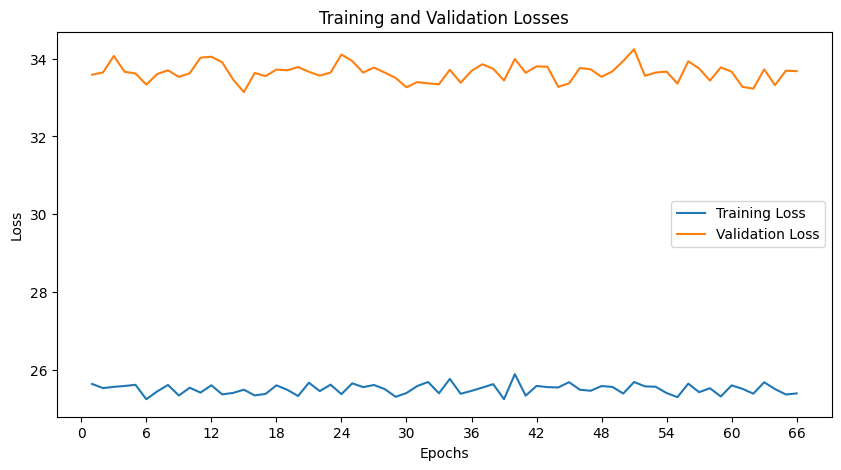

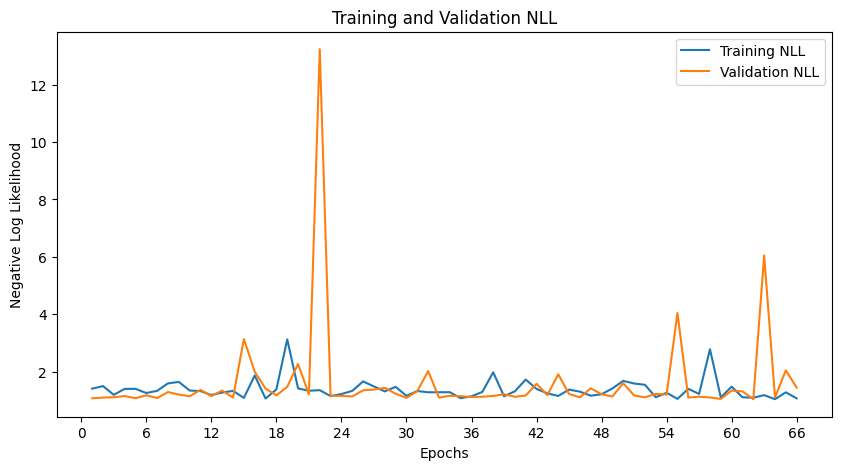

In [121]:
# Create Training Plotter instance
tuned_plotter = TrainingPlotter(EPOCHS)

# Call the plotting methods
tuned_plotter.plot_losses(tuned_train_losses, tuned_val_losses)
tuned_plotter.plot_nlls(tuned_train_nlls, tuned_val_nlls)

# Model Predictions

## Processing the Samples

In [124]:
# Create Predictive Class instance
predictive = Predictive(tuned_model, guide=tuned_guide, num_samples=5000,
                        return_sites=('fc3.weight', 'obs', '_RETURN'))

# Initialize results dictionary
results_dict = {'fc3.weight': [], 'obs': [], '_RETURN': []}

In [125]:
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loop over the test DataLoader
for X_batch, _ in test_loader:
    X_batch = X_batch.to(device)
    results = predictive(X_batch)

    # Append results for each site to the respective list
    for site in results_dict.keys():
        results_dict[site].append(results[site].detach().cpu())

# Concatenate results for each site
for site in results_dict.keys():
    results_dict[site] = torch.cat(results_dict[site], dim=1)  # Concatenate along the second dimension

# Print concatenated results for each site
print({k: v.shape for k, v in results_dict.items()})

{'fc3.weight': torch.Size([5000, 9, 1, 1]), 'obs': torch.Size([5000, 140]), '_RETURN': torch.Size([5000, 140])}


Key: fc3.weight
Array Shape: (5000, 9, 1, 1)
Array Elements: 
[[[[0.6339907 ]]

  [[0.55684084]]

  [[0.6924468 ]]

  [[0.5107316 ]]

  [[0.6638487 ]]]


 [[[0.4868106 ]]

  [[0.62773377]]

  [[0.6280479 ]]

  [[0.58325016]]

  [[0.57880944]]]


 [[[0.6165656 ]]

  [[0.70241463]]

  [[0.5973202 ]]

  [[0.54407096]]

  [[0.666456  ]]]


 ...


 [[[0.5532791 ]]

  [[0.53936464]]

  [[0.7130947 ]]

  [[0.5327094 ]]

  [[0.61983347]]]


 [[[0.6916246 ]]

  [[0.70503354]]

  [[0.58295316]]

  [[0.6872044 ]]

  [[0.668303  ]]]


 [[[0.6066859 ]]

  [[0.60240835]]

  [[0.6124276 ]]

  [[0.6474072 ]]

  [[0.6007543 ]]]]
--------------------------------------------------


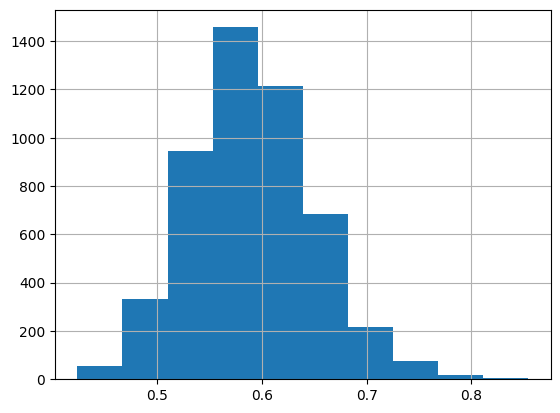

Key: obs
Array Shape: (5000, 140)
Array Elements: 
[[1.4056172  0.10047225 1.1299703  0.6290597  1.3801783 ]
 [0.84313715 0.21679261 0.3650997  0.7314259  1.2514547 ]
 [0.6369348  0.534795   0.781112   1.3320357  0.46935982]
 ...
 [0.5306133  0.7253147  1.4747671  1.1029807  0.72953326]
 [0.7105878  0.5969481  1.5142663  0.30561763 0.8834457 ]
 [0.93479085 0.35588953 0.18656906 1.0404928  0.9080905 ]]
--------------------------------------------------


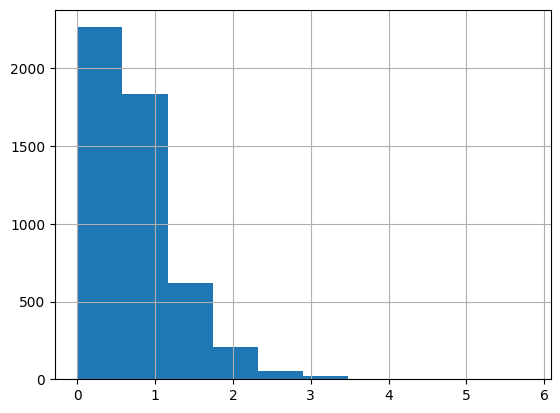

Key: _RETURN
Array Shape: (5000, 140)
Array Elements: 
[[0.9476119  0.9473618  0.9476276  0.94743294 0.9470496 ]
 [0.6986667  0.69840026 0.6986833  0.69847596 0.69806767]
 [0.77665937 0.7763304  0.77667993 0.7764239  0.7759198 ]
 ...
 [0.7946197  0.7943694  0.7946353  0.7944405  0.7940569 ]
 [0.99568963 0.99528337 0.995715   0.99539876 0.9947762 ]
 [0.7671285  0.7669095  0.76714224 0.7669717  0.76663595]]
--------------------------------------------------


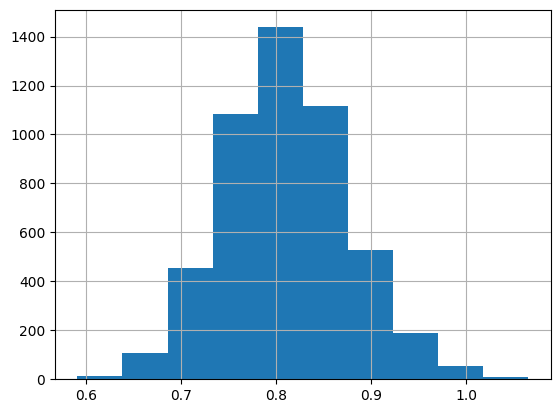

In [126]:
# Convert to NumPy array dictionary
numpy_results_dict = {k: v.numpy() for k, v in results_dict.items()}

# Iterate over items in dictionary
for key, array in numpy_results_dict.items():
    print(f'Key: {key}')
    print(f'Array Shape: {array.shape}')
    print(f'Array Elements: \n{array[:, :5]}')
    print('-' * 50)

    # Convert the multi-dimensional array into a 2D array
    if array.ndim > 2:
        array_2d = array.reshape(array.shape[0], -1)  # Flatten the array while keeping the first dimension
        df = pd.DataFrame(array_2d)
    else:
        df = pd.DataFrame(array)

    # Plot the histogram of the samples
    df.iloc[:, 0].hist()
    plt.show()

In [127]:
# Function to get predictive summary
def predictive_summary(samples):
    site_stats = {}
    for key, value in samples.items():
        # Convert list of arrays to a single NumPy array
        value_array = np.concatenate(value, axis=0)
        site_stats[key] = {
            'mean': np.mean(value_array, axis=0),
            'std': np.std(value_array, axis=0),
            '5%': np.percentile(value_array, 5, axis=0),
            '95%': np.percentile(value_array, 95, axis=0),
        }
    return site_stats

# Call the function
pred_summary = predictive_summary(numpy_results_dict)

In [128]:
# Inspect pred_summary
for key, value in pred_summary.items():
    print(f'{key}: Type - {type(value)}')
    print(f'Value: {value}\n')

fc3.weight: Type - <class 'dict'>
Value: {'mean': array([[0.590989]], dtype=float32), 'std': array([[0.05900215]], dtype=float32), '5%': array([[0.49956104]]), '95%': array([[0.69235153]])}

obs: Type - <class 'dict'>
Value: {'mean': 0.75380105, 'std': 0.53018683, '5%': 0.1376294046640396, '95%': 1.7831433534622192}

_RETURN: Type - <class 'dict'>
Value: {'mean': 0.8089195, 'std': 0.06623869, '5%': 0.7050407528877258, '95%': 0.9222998917102814}



In [139]:
# Extract samples for '_RETURN' and 'obs'
mu_samples = numpy_results_dict['_RETURN']
y_samples = numpy_results_dict['obs']

In [140]:
# Aggregate predictions
mu_mean = np.mean(mu_samples, axis=0)
y_mean = np.mean(y_samples, axis=0)

# Calculate the 5th and 95th percentiles for the 90% credible interval
mu_perc_5 = np.percentile(mu_samples, 5, axis=0)
mu_perc_95 = np.percentile(mu_samples, 95, axis=0)
y_perc_5 = np.percentile(y_samples, 5, axis=0)
y_perc_95 = np.percentile(y_samples, 95, axis=0)

In [141]:
# Reshape the arrays
mu_mean_reshaped = mu_mean.reshape(-1, 1)
mu_perc_5_reshaped = mu_perc_5.reshape(-1, 1)
mu_perc_95_reshaped = mu_perc_95.reshape(-1, 1)

y_mean_reshaped = y_mean.reshape(-1 ,1)
y_perc_5_reshaped = y_perc_5.reshape(-1, 1)
y_perc_95_reshaped = y_perc_95.reshape(-1, 1)

print(f'Length: {len(y_mean_reshaped)} observations\n')
y_mean_reshaped[:5], y_perc_95_reshaped[:5]

Length: 140 observations



(array([[0.7521314 ],
        [0.7580412 ],
        [0.7604228 ],
        [0.75588024],
        [0.7611296 ]], dtype=float32),
 array([[1.78453342],
        [1.82668296],
        [1.80515839],
        [1.75794838],
        [1.77532798]]))

In [142]:
# Assign original test values that correspond to predictions
y_true = test_set[WINDOW_SIZE:]

print(f'Length: {len(y_true)} observations\n')
y_true[:5]

Length: 140 observations



array([[6784],
       [7347],
       [7605],
       [7148],
       [7865]])

In [143]:
# Inverse transform the scaling
mu_mean_rescaled = scaler.inverse_transform(mu_mean_reshaped)
mu_perc_5_rescaled = scaler.inverse_transform(mu_perc_5_reshaped)
mu_perc_95_rescaled = scaler.inverse_transform(mu_perc_95_reshaped)

y_mean_rescaled = scaler.inverse_transform(y_mean_reshaped)
y_perc_5_rescaled = scaler.inverse_transform(y_perc_5_reshaped)
y_perc_95_rescaled = scaler.inverse_transform(y_perc_95_reshaped)

In [144]:
# Print arrays
y_mean_rescaled[:14], y_perc_95_rescaled[:14]

(array([[4651.9614],
        [4685.127 ],
        [4698.4927],
        [4673.    ],
        [4702.4595],
        [4607.947 ],
        [4664.924 ],
        [4617.4424],
        [4708.335 ],
        [4743.4785],
        [4689.076 ],
        [4646.0117],
        [4686.6616],
        [4621.17  ]], dtype=float32),
 array([[10445.80158149],
        [10682.34482345],
        [10561.54895554],
        [10296.60635507],
        [10394.14067018],
        [10377.59252441],
        [10439.33082168],
        [10400.2045761 ],
        [10530.7305173 ],
        [10735.08811398],
        [10473.0416924 ],
        [10409.39586819],
        [10471.17895518],
        [10360.20565016]]))

In [145]:
# Create predictions DataFrame
predictions = pd.DataFrame({
    'mu_mean': mu_mean_rescaled.flatten(),
    'mu_perc_5': mu_perc_5_rescaled.flatten(),
    'mu_perc_95': mu_perc_95_rescaled.flatten(),
    'y_mean': y_mean_rescaled.flatten(),
    'y_perc_5': y_perc_5_rescaled.flatten(),
    'y_perc_95': y_perc_95_rescaled.flatten(),
    'y_true': y_true.flatten()
})

In [146]:
# View the DataFrame
predictions.head(10)

mu_mean    mu_perc_5   mu_perc_95       y_mean     y_perc_5  \
0  4981.333496  4390.868893  5616.857424  4651.961426  1179.899295   
1  4979.772949  4389.698406  5614.744714  4685.126953  1233.548858   
2  4981.436523  4390.942148  5616.989402  4698.492676  1260.314186   
3  4980.220215  4390.031285  5615.347920  4673.000000  1165.594185   
4  4977.821289  4388.237906  5612.096300  4702.459473  1181.137753   
5  4980.342773  4390.124343  5615.516576  4607.946777  1157.545202   
6  4960.482910  4372.433440  5591.351368  4664.923828  1179.138071   
7  4985.792969  4394.871652  5622.844345  4617.442383  1230.549674   
8  4982.765625  4391.934480  5618.777027  4708.334961  1211.202363   
9  4981.070801  4390.668878  5616.497350  4743.478516  1215.566635   

      y_perc_95  y_true  
0  10445.801581    6784  
1  10682.344823    7347  
2  10561.548956    7605  
3  10296.606355    7148  
4  10394.140670    7865  
5  10377.592524    4549  
6  10439.330822    6530  
7  10400.204576    7006  
8  10530.730517    7375  
9  10735.088114    7765

## Plotting Predictions

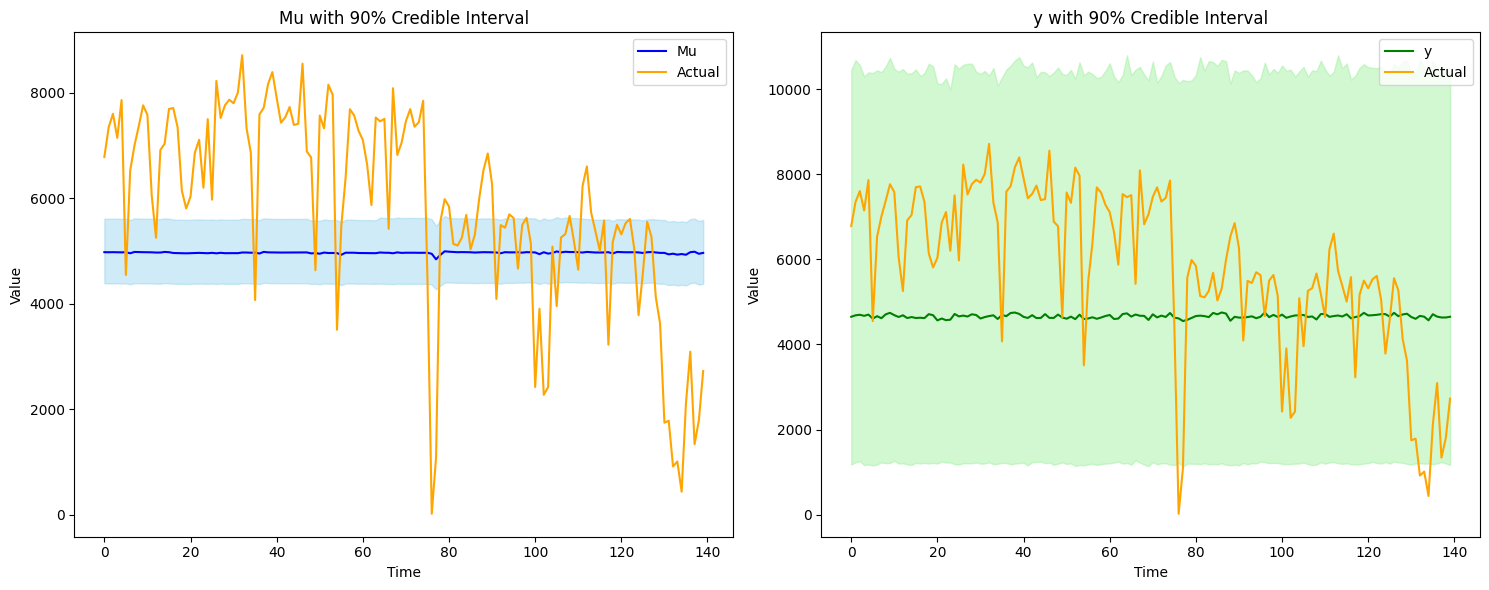

In [147]:
# Plotting
plt.figure(figsize=(15, 6))

# Plot for mu
plt.subplot(1, 2, 1)
plt.fill_between(predictions.index, predictions['mu_perc_5'], predictions['mu_perc_95'], color='skyblue', alpha=0.4)
plt.plot(predictions['mu_mean'], label='Mu', color='blue')
plt.plot(predictions['y_true'], label='Actual', color='orange')
plt.title('Mu with 90% Credible Interval')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# Plot for y
plt.subplot(1, 2, 2)
plt.fill_between(predictions.index, predictions['y_perc_5'], predictions['y_perc_95'], color='lightgreen', alpha=0.4)
plt.plot(predictions['y_mean'], label='y', color='green')
plt.plot(predictions['y_true'], label='Actual', color='orange')
plt.title('y with 90% Credible Interval')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()